In [48]:
import random as rd
import astropy.io.fits as apf
import batman
import eleanor
import emcee
import getpass
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.backends.backend_pdf import PdfPages
from multiprocessing import Pool
from multiprocessing import Process
import multiprocessing
import numpy as np
import os
import pandas as pd
import shutil
import time as tm
from astroquery.mast import Catalogs
import astropy.units as units
from astropy.wcs import WCS
import math
import astropy.io.fits as apf
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings("ignore")
from wotan import flatten
import lightkurve as lk
import corner
import numpy as np
import juliet
import matplotlib.gridspec as gridspec
import mpl_axes_aligner

from astropy.timeseries import BoxLeastSquares
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter, SVOFilter
from ldtk.filters import tess, sdss_z
from astroquery import svo_fps

import mr_forecast as mr
import numba
from math import floor
from functools import partial


from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

import time



In [49]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [50]:
"""I'm going to go ahead and outline the steps to take:
1) Define output and input directories 
2) Check to see if you have already started your search, and if so get the times in transit AND TICIDs/GAIAids
3) Detrend data with wotan
3) Get outliers for each target and create a histogram of frequent outline points. Mask them. 
4) Save new flux+time data in fits file (if you can)
5) Before beginning SNR search: 
    a) calculate CDPP
    b) create SNR grid, getting min rp and duration
    c) calc limb darkening (?)
6) begin SNR search
    a) using """

"I'm going to go ahead and outline the steps to take:\n1) Define output and input directories \n2) Check to see if you have already started your search, and if so get the times in transit AND TICIDs/GAIAids\n3) Detrend data with wotan\n3) Get outliers for each target and create a histogram of frequent outline points. Mask them. \n4) Save new flux+time data in fits file (if you can)\n5) Before beginning SNR search: \n    a) calculate CDPP\n    b) create SNR grid, getting min rp and duration\n    c) calc limb darkening (?)\n6) begin SNR search\n    a) using "

In [51]:
RP_REFERENCE = 0.05

In [52]:
"""Let's start the following cells pretending that I have 
1) detrended data
2) sliced the LC
3) run the periodic search and masked out periodic transits
4) gotten a df including M_star, R_star, Teff_star, aLDC, bLDC"""




@numba.jit(nopython=True)
def interpolation_search(x, z):
    n = len(x)
#     print(n)
    assert n > 1
    if z < x[1] or n == 2:
        return 0
    elif z >= x[-2]:
        return n - 2
    imin = 0
    imax = n - 1
    while imax - imin > 1:
        s = (z - x[imin]) / (x[imax] - x[imin])
        j = int(imin + floor((imax - imin) * s))
        if z >= x[j + 1]:
            imin = j + 1
        elif z < x[j]:
            imax = j
        else:
            return j
    return imin


@numba.jit(nopython=True)
def lerp(y, theta):
    return (1 - theta) * y[..., 0] + theta * y[..., 1]


class interp1d(object):
    """
    Adapted from:
    Fast multithreaded linear interpolation, 1D and 2D - Ver. 3.4
    This versione: 15/06/2018
    @author: Marco Maffezzoli, Universita Bocconi
    http://didattica.unibocconi.it/mypage/upload/49183_20180615_035144_INTERPOLATION.PY
    """

    def __init__(self, x_new, x):
        (self._index, self._theta) = self._locate(x_new, x)
        
    @staticmethod
    @numba.guvectorize("(i8[:],f8[:],f8[:],f8[:])", "(m),(m),(n)->(m)")
    def _linear(index, theta, y, y_new):
        for (j, (i, t)) in enumerate(zip(index, theta)):
            y_new[j] = lerp(y[i : i + 2], t)

    def __call__(self, y):
        return self._linear(self._index, self._theta, y)

    @numba.guvectorize("(f8[:],f8[:],i8[:],f8[:])", "(),(n)->(),()")
    def _locate(x_new, x, index, theta =[]):
        index[0] = i = interpolation_search(x, x_new[0])
        theta[0] = (x_new[0] - x[i]) / (x[i + 1] - x[i])

In [53]:
###DEFAULTS

DURATIONS = np.array(range(2, 25))*30.
MAXWIDTH_IN_SAMPLES = 24
len(DURATIONS)
RP_REFERENCE = 0.05
T0_FIT_MARGIN = 0.01
TRANSIT_DEPTH_MIN = 2.5 * 10 ** -6  # 10 ppm
SIGNAL_DEPTH = 0.5


In [54]:
TRANSIT_DEPTH_MIN

2.4999999999999998e-06

In [55]:
def fractional_transit(
    duration,
    maxwidth,
    depth,
    samples,
    per,
    rp,
    a,
    inc,
    ecc,
    w,
    u,
    limb_dark,
    cached_reference_transit=None,
):
    """Returns a scaled reference transit with fractional width and depth"""

    if cached_reference_transit is None:
#         print('a')
        reference_flux = reference_transit(
            samples=samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
        )
    else:
        reference_flux = cached_reference_transit

    reference_time = np.linspace(-0.5, 0.5, samples)
    occupied_samples = int((duration / maxwidth) * samples)
    x_new = np.linspace(-0.5, 0.5, occupied_samples)
    f = interp1d(x_new, reference_time)
    y_new = f(reference_flux)

    # Patch ends with ones ("1")
    missing_samples = samples - occupied_samples
    emtpy_segment = np.ones(int(missing_samples * 0.5))
    result = np.append(emtpy_segment, y_new)
    result = np.append(result, emtpy_segment)
    if np.size(result) < samples:  # If odd number of samples
        result = np.append(result, np.ones(1))

    # Depth rescaling
    result = 1 - ((1 - result) * depth)

    return result

###Creating cache of models
def reference_transit(per, rp, a, inc, ecc, w, u, limb_dark, samples = 24):
    """Returns an Earth-like transit of width 1 and depth 1"""
    ###Samples = maxwidth of samples = number of points in max duration val
    ###NOTE: TLS requires that his number be EVEN
    f = np.ones(1000)
    duration = 1  # transit duration in days. Increase for exotic cases. ###I want the max trans dur to be 12 hrs
    t = np.linspace(-duration * 0.5, duration * 0.5, 1000)
    t_2_lin = np.linspace(0., duration, 1000)
    ###FOR ME: T=time in lc <- NOT TRUE. WHY: this is a model. I would like each transit 
    ###to start at 0 and then go to x duration BECAUSE ising t0 = 0 is EASY and then i
    ###will SHIFT IT so the transit starts at 0 and t0 is size of shift 
    b_model           = batman.TransitParams()
    b_model.t0        = 0  # time of inferior conjunction
    b_model.per       = per  # orbital period, use Earth as a reference
    b_model.rp        = rp  # planet radius (in units of stellar radii)
    b_model.a         = a  # semi-major axis (in units of stellar radii)
    b_model.inc       = inc  # orbital inclination (in degrees)
    b_model.ecc       = ecc  # eccentricity
    b_model.w         = w  # longitude of periastron (in degrees)
    b_model.u         = u  # limb darkening coefficients
    b_model.limb_dark = limb_dark  # limb darkening model
    m = batman.TransitModel(b_model, t)  # initializes model
    model_flux = m.light_curve(b_model)  # calculates light curve

    # Determine start of transit (first value < 1)
    idx_first = np.argmax(model_flux < 1)
    intransit_model_flux = model_flux[idx_first : -idx_first + 1]
    intransit_time = t[idx_first : -idx_first + 1] 

    # Downsample (bin) to target sample size
    x_new = np.linspace(t[idx_first], t[-idx_first - 1], samples)

    f = interp1d(x_new, intransit_time)
    downsampled_intransit_model_flux = f(intransit_model_flux)

    # Rescale to height [0..1]
    rescaled = (np.min(downsampled_intransit_model_flux) - downsampled_intransit_model_flux) / (
        np.min(downsampled_intransit_model_flux) - 1
    )
    
    return rescaled #, intransit_time


def get_cache(durations, rp = 0.03, per=25., a =0.15*215., inc=89.5, ecc=0., w=180., u=[0.2, 0.1],
              limb_dark='quadratic', verbose=False, maxwidth_in_samples = MAXWIDTH_IN_SAMPLES):
    """Fetches (size(durations)*size(depths)) light curves of length 
        maxwidth_in_samples and returns these LCs in a 2D array, together with 
        their metadata in a separate array."""
    
    if verbose:
        print("Creating model cache for", str(len(durations)), "durations")
    lc_arr = []
    rows = np.size(durations)
    lc_cache_overview = np.zeros(
        rows,
        dtype=[("duration", "float128"), ("width_in_samples", "int64"), ("overshoot", "float128")],
    )
    cached_reference_transit = reference_transit(
        per=per,
        rp=rp,
        a=a,
        inc=inc,
        ecc=ecc,
        w=w,
        u=u,
        limb_dark=limb_dark,
    )

    row = 0
    for duration in durations:
        scaled_transit = fractional_transit(
            duration=duration,
            maxwidth=np.max(durations),
            depth=SIGNAL_DEPTH,
            samples=maxwidth_in_samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
            cached_reference_transit=cached_reference_transit,
        )
        lc_cache_overview["duration"][row] = duration
        used_samples = int((duration / np.max(durations)) * maxwidth_in_samples)
        lc_cache_overview["width_in_samples"][row] = used_samples
        full_values = np.where(
            scaled_transit < (1 - 0.01 * 10 ** -6 )
        )
        first_sample = np.min(full_values)
        last_sample = np.max(full_values) + 1
        signal = scaled_transit[first_sample:last_sample]
        lc_arr.append(signal)

        # Fraction of transit bottom and mean flux
        overshoot = np.mean(signal) / np.min(signal)
        # Later, we multiply the inverse fraction ==> convert to inverse percentage
        lc_cache_overview["overshoot"][row] = 1 / (2 - overshoot)
#         print(overshoot, 1 / (2 - overshoot))
        row += +1
        

    lc_arr = np.array(lc_arr, dtype=object)
    return lc_cache_overview, lc_arr


In [56]:
list_=np.zeros(10)
residuals = np.full(len(list_), np.nan, dtype=[('chi2','object')])
residuals

array([(nan,), (nan,), (nan,), (nan,), (nan,), (nan,), (nan,), (nan,),
       (nan,), (nan,)], dtype=[('chi2', 'O')])

In [57]:
def lowest_residuals_in_this_duration(
    mean,
    time,
    transit_depth_min,
    data_arr,
    duration,
    signal,
    inverse_squared_dy_arr,
    overshoot,
    ootr,
    chosen_transit_row,
    datapoints,
    T0_fit_margin, 
    threshold = 7.3, 
    verbose = False
):
    T0 = []
    T0_st_indx = []
    SNR = threshold
    residuals_depths = np.full(len(time), np.nan, dtype = ([("residuals", "float128"), ("depths", "float128")]))
    # if nothing is fit, we fit a straight line: signal=1. Then, at dy=1,
    # the squared sum of residuals equals the number of datapoints
    summed_residual_in_rows = datapoints

    xth_point = 1  # How many cadences the template shifts forward in each step
    if T0_fit_margin > 0 and duration > T0_fit_margin:
        T0_fit_margin = 1 / T0_fit_margin
        xth_point = int(duration / T0_fit_margin)
        if xth_point < 1:
            xth_point = 1

            
#     print('mean stats: mean val ', np.mean(mean), ' median val ', np.median(mean), ' max ', np.max(mean), ' min ', np.min(mean))
#     print('mean overshoots stats: mean val ', np.mean(mean* overshoot), ' median val ', np.median(mean* overshoot), ' max ', np.max(mean * overshoot), ' min ', np.min(mean* overshoot))

    for i in range(len(mean)):
        if (mean[i] > transit_depth_min) and (i % xth_point == 0):
            data = data_arr[i : i + duration]
            flux_oot = np.delete(data_arr, range(i,i+duration))

            dy = inverse_squared_dy_arr[i : i + duration]
            target_depth = mean[i] * overshoot
#             print('target_depth', target_depth)

            scale = SIGNAL_DEPTH / target_depth
#             print('scale, ', scale)
#             print('mean val, ', mean[i])

            reverse_scale = 1 / scale  # speed: one division now, many mults later
            snr = (mean[i] / (np.std(flux_oot)*np.sqrt(0.5))) * duration ** (0.5)
            if snr>SNR:
                SNR=snr
            intransit_residual = 0
            for j in range(len(signal)):
                sigi = (1 - signal[j]) * reverse_scale
                intransit_residual += ((data[j] - (1 - sigi)) ** 2) * dy[j]
            current_stat = intransit_residual + ootr[i] #- summed_edge_effect_correction
            
            residuals_depths['residuals'][i] = current_stat
            residuals_depths['depths'][i] = 1-target_depth
            
    residuals = residuals_depths['residuals'].astype('float128')

    
    if np.nanmin(residuals)<=np.nanmedian(residuals)-5*np.nanstd(residuals) and SNR>threshold:
        indexes = np.where(residuals<=np.nanmedian(residuals)-5*np.nanstd(residuals))[0]
        
        for jjj in indexes:
            if jjj and jjj+1 in indexes:
                T0_st_indx.extend(np.where(residuals == min(residuals[[jjj, jjj+1]]))[0])
        
        if verbose:
#             print(duration*30/60, 'planets Tdur: ', Toi270_Tdur)#' Tdur_p4:', Toi270_Tdur[3])
            fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20,5))
            axes[0].plot(time, residuals, zorder = 10)

            axes[1].scatter(time, data_arr, s = 1, zorder = 11, alpha = 1, color = 'black')
            for j in range(1,7):
                axes[0].hlines(np.nanmedian(residuals)-j*np.nanstd(residuals), np.min(time), np.max(time), alpha = 0.5, zorder = 3, color = 'violet')
            plt.subplots_adjust(wspace=0.2, hspace=0)
            plt.show()

    
        return SNR, np.array(list(residuals_depths['residuals'].astype('float128'))), np.array(list(residuals_depths['depths'].astype('float128'))), T0_st_indx
    else:
        return 0, [],[], []
    
    

In [58]:
# @numba.jit(fastmath=True, parallel=False, nopython=True)
def out_of_transit_residuals(data, width_signal, inv_sq_dy):
#     print(len(data), data)
    chi2 = np.zeros(len(data) - width_signal + 1)
    fullsum = np.sum(((1 - data) ** 2) * inv_sq_dy)
    window = np.sum(((1 - data[:width_signal]) ** 2) * inv_sq_dy[:width_signal])
    chi2[0] = fullsum - window
    for i in range(1, len(data) - width_signal + 1):
        becomes_visible = i - 1
        becomes_invisible = i - 1 + width_signal
        add_visible_left = (1 - data[becomes_visible]) ** 2 * inv_sq_dy[becomes_visible]
        remove_invisible_right = (1 - data[becomes_invisible]) ** 2 * inv_sq_dy[
            becomes_invisible
        ]
        chi2[i] = chi2[i - 1] + add_visible_left - remove_invisible_right
    return chi2


In [59]:
np.array([[1,3,6,1,4], [0, 6, 4, 6,2], [2,5,1,3,6]])

array([[1, 3, 6, 1, 4],
       [0, 6, 4, 6, 2],
       [2, 5, 1, 3, 6]])

In [60]:
np.array([[1,3,6,1,4], [0, 6, 4, 6,2], [2,5,1,3,6]])

array([[1, 3, 6, 1, 4],
       [0, 6, 4, 6, 2],
       [2, 5, 1, 3, 6]])

In [61]:

def search_best_fit_duration(
#     duration,
    t,
    y,
    dy,
    transit_depth_min,
    lc_arr,
    lc_cache_overview,
    T0_fit_margin,
    verbose = True
):
    """Core routine to search the flux data set 'injected' over all 'periods'"""
    SNR_val = 0.

    # duration (in samples) of widest transit in lc_cache (axis 0: rows; axis 1: columns)
    npoints_in_duration = np.unique(lc_cache_overview["width_in_samples"])
    T0_vals = np.full(
        100, np.nan, 
        dtype=[('T0_start', 'float128'), ('T0', 'float128'), ('residuals', 'float128'), ('best_dur', 'int64'), ('best_depth', 'float128')]
    )

    Residuals_all = []
    inverse_squared_dy = 1 / dy ** 2
#     print('lengths', len(dy), len(y), len(t), len(inverse_squared_dy))

    skipped_all = True
    T0_starts = []
    for i in range(len(npoints_in_duration)):
        dur = npoints_in_duration[i]

        chosen_transit_row = 0
        while lc_cache_overview["width_in_samples"][chosen_transit_row] != dur:
            chosen_transit_row += 1
        if len(t)<=dur:
            continue
        snr, residuals, depths, T0_start_indx = lowest_residuals_in_this_duration(
            mean=1 - running_mean(y, dur),
            time = t,
            transit_depth_min=transit_depth_min,
            data_arr=y,
            duration=dur,
            signal=lc_arr[chosen_transit_row],
            inverse_squared_dy_arr=inverse_squared_dy,
            overshoot=lc_cache_overview["overshoot"][chosen_transit_row],
            ootr=out_of_transit_residuals(
                y, dur, inverse_squared_dy
            ),
            chosen_transit_row=chosen_transit_row,
            datapoints=len(y),
            T0_fit_margin=T0_fit_margin,
        )

       
        SNR_val += snr
        residuals = residuals/np.nanmedian(residuals)
        T0_starts.extend(T0_start_indx)
        T0_starts = list(set(T0_starts))
        if len(residuals)>0:
            Residuals_all.append(residuals)

            for jjj in T0_starts:
                indx = False
                try: 

                    indx = np.where(T0_vals['T0_start']==jjj)[0][0]
                    if float(T0_vals['residuals'][indx])<float(residuals[jjj]):
                        indx = False

                except:
                    indx = min(np.where(T0_vals['best_dur']==-9223372036854775808)[0])


                T0_vals['T0_start'][indx]   = jjj
                T0_vals['T0'][indx]         = t[jjj]+chosen_transit_row/48
                T0_vals['residuals'][indx]  = float(residuals[jjj])
                T0_vals['best_dur'][indx]   = chosen_transit_row
                T0_vals['best_depth'][indx] = float(depths[jjj])

    if verbose:
        color = ['#00E9F5', '#00E9F5', '#22DAD2','#22DAD2', '#44CBAF', '#44CBAF',
                 '#66BC8C','#66BC8C','#88AD69', '#88AD69', '#AA9E46',  '#AA9E46', 
                 '#CC8F23', '#CC8F23', '#EB8300','#EB8300', '#F19508', '#F19508', 
                 '#F8A610','#F8A610', '#FFB718','#FFB718','#FFB718']
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (25, 12))
        

        resids = np.array(Residuals_all).transpose()
        if len(Residuals_all)>0.:
            for i in range(len(Residuals_all)):
                ax1.plot(t, Residuals_all[i], color = color[i], lw = 2)

            print(len(t), np.shape(resids), len(Residuals_all))
            resids = [np.median(np.array(x)) for x in resids]
            ax2.scatter(t, y, color = '#00E9F5', zorder = 2)
            ax3 = ax2.twinx()
            ax3.plot(t, resids, color = '#EB8300', zorder = 10)

            ax3.yaxis.tick_right()
    #         align_yaxis(ax2, 1., ax3, 1.)
            mpl_axes_aligner.align.yaxes(ax2, 1., ax3, 1., 0.75)
            for ax in [ax1, ax2, ax3]:
                ax.set_facecolor('None')

                ax.xaxis.label.set_color('#FFD475')        #setting up X-axis label color to yellow
                ax.yaxis.label.set_color('#FFD475')          #setting up Y-axis label color to blue

                ax.tick_params(axis='x', colors='#FFD475', labelsize = 35, width=3, length = 10)    #setting up X-axis tick color to red
                ax.tick_params(axis='y', colors='#FFD475', labelsize = 35, width=3, length = 10)  #setting up Y-axis tick color to black
                ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
                ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

                ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
                ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red
                ax.set_xlabel('Time (BJD)', color = '#FFD475', fontsize = 40)
                ax.set_ylabel('Relative Flux', color = '#FFD475', fontsize = 40);

            ax3.yaxis.set_label_position("right")
            ax1.set_ylabel(r'$\chi^2$ of Transit Fit', fontsize = 40)
            ax3.set_ylabel(r'$\chi^2$ Median Values', fontsize = 40, rotation=270, labelpad=75)

            plt.show()
    return np.array(list(T0_vals['T0_start'])), np.array(list(T0_vals['T0'])), np.array(list(T0_vals['best_dur'])), np.array(list(T0_vals['best_depth'])), np.array(list(T0_vals['residuals']))

        

In [62]:
ctlfile = './Total_Mdwarf_files/by_sector/PM_year_1/mdwarf_params_sector_13.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None)

TOI_904 = pd.concat(
    [chunk[chunk['TICID'].astype(int)==int(261257684)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

In [63]:
 TOI_904[['aLSM', 'bLSM']].values[0].astype(float)

array([0.2581, 0.3609])

In [64]:
def new_binning_function_by_time(time, flux, time_size_of_bins): 
    # Written by Mallory Harris

    # Description: bins data in time, flux, and raw flux arrays as their mean value based on given time interval

    # Arguments : time              = array of time, in days
    #             flux              = array of flux 
    #             time_size_of_bins = bin size for time intervals, in minutes


    # Return    : list of binned time, flux and 
    time = np.array(time).byteswap().newbyteorder()  #changes how the arrays are represented in memory
    flux = np.array(flux).byteswap().newbyteorder() 

    interval = time_size_of_bins/60./24.#change units from minutes to days
    df = pd.DataFrame({'time': time, 'flux':flux})
    df = df.append(df)
    #print(df)
    numbins = np.array(list(range(int(np.ceil((max(time)-min(time))/interval))+1)))
    #print(df)
    print(numbins, min(time), interval)
    bins = min(time) + interval*numbins
    print(bins)
    
    #print(bins)
    df['time_bins'] = pd.cut(df.time, bins)
    new_time = [x for x in df.groupby('time_bins').median()['time'] if not math.isnan(x)] #finds the mean value of binned time
    new_flux = [x for x in df.groupby('time_bins').median()['flux'] if not math.isnan(x)] #finds the mean value of binned flux
    #print(len(new_time), len(new_flux), len(new_raw))
    return np.array(new_time), np.array(new_flux)


In [65]:
def running_mean(data, window_size):
    """Returns the moving average of an array `data`.
    Parameters
    ----------
    data : array of numbers
        The running mean will be computed on this data.
    window_size : int
        Window length used to compute the running mean.
    """
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)


def remove_outliers(time, flux, sigma = 5., sigma_lower=None, sigma_upper=None, **kwargs):
    outlier_mask = sigma_clip(data=flux,
                              sigma=sigma,
                              sigma_lower=sigma_lower,
                              sigma_upper=sigma_upper,
                              **kwargs).mask
    # Second, we return the masked light curve and optionally the mask itself
    return time[~outlier_mask], flux[~outlier_mask]
    
def flatten_lc(time, flux):
    flat_flux, flux_trend = flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='biweight',
    window_length=1.,    # The length of the filter window in units of ``time``
#     edge_cutoff=0.1,      # length (in units of time) to be cut off each edge.
#     break_tolerance=1,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
#     cval=5.0              # Tuning parameter for the robust estimators
    )
    return flat_flux, flux_trend

def cleaning_up_data(time, flux):
#     flux = flux/np.nanmedian(flux)
#     try: 
#         flattened_flux = flatten_lc(time, flux)

#     except Exception as error: 
#         flattened_flux = flux

    cleaned_time, cleaned_flux = remove_outliers(time, flux)
    return cleaned_time, cleaned_flux

In [66]:
def mkdir_if_doesnt_exist(outdir, str_new_dir_name):
    # Written by Mallory Harris

    # Description: creates new directory to save data to if it does not already exist

    # Arguments : outdir             = existing directory in which new directory will be located
    #             str_new_dir_name   = string of the new subdirectory of outdir's name


    if os.path.exists(outdir+str_new_dir_name)==False:
        new_outdir = os.path.join(outdir, str_new_dir_name)
        os.mkdir(new_outdir)


def fetch(ticid, sector_num, pipeline, exptime): 
    # Written by Mallory Harris

    # Description: uses lightkurve to download TESS fits file based on sector number, source pipeline, exposure time and star id

    # Arguments : ticid       = TESS Input Catalog identification number of star
    #             sector_num  = sector from which to download data
    #             pipeline    = source pipeline from which to get data (options are 'QLP', 'SPOC', 'TESS-SPOC')
    #             exptime     = exposure length of observations (2 or 30 minutes, depending on pipeline) units of seconds
    #                           'QLP', 'TESS-SPOC' = 30 minute (1800 s) exptime
    #                           'SPOC'             = 2  minutte (120 s) exptime


    good_authors = [pipeline]
    if pipeline == 'SPOC':
        Path = './known_Mdwarfs_data/mastDownload'
        small_dir_path_lst = glob.glob(Path+"/TESS/*"+str(ticid).zfill(16)+"*")
    else:
        Path = './known_Mdwarfs_data/FFI_data/sector_'+str(sector_num)+'/mastDownload'
        small_dir_path_lst = glob.glob(Path+"/HLSP/*"+str(ticid).zfill(16)+"*")

        if pipeline == 'QLP':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'ffi' in i]
        elif pipeline == 'TESS-SPOC':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'tess-spoc' in i]
            
    for i in small_dir_path_lst:
        file = glob.glob(i+'/*.fits')
        print('there is something already in the folder:', len(file))
        os.remove(file[0])
        print('it was removed')
        
    search = lk.search_lightcurve('TIC '+str(ticid), mission='TESS', sector=sector_num, exptime =exptime)
#     print(search)
    try:
        result = all(elem in list(search.author)  for elem in good_authors)
    except:
        print(search)
        result = False

    if result == True:
        search = search[search.author == pipeline]
        search.download(quality_bitmask='default', download_dir = './known_Mdwarfs_data/FFI_data/sector_'+str(sector_num))

        print('done downloading')
    else:
        print('No '+pipeline+' obervations')

def get_lcf_files(df, sector_num, pipeline, last_hung_ticid = 0):
    # Written by Mallory Harris

    # Description: takes dataframe of TICIDs observed in a given sector (identified by a column in df, explained below)
    #              to download light curves of that sector for each ticid from given pipeline 
            

    # Arguments : df              = panda dataframe. Must include at least one column of "TICID" with TESS identification number
    #                               and one column denoting whether or not observations were taken in the named sector.
    #                               example: if targets are observed in sector 20, their value in the column "S20" will be >0
    #             sector_num      = sector from which to download data
    #             pipeline        = source pipeline from which to get data (options are 'QLP', 'SPOC', 'TESS-SPOC')
    #             last_hung_ticid = if, for any reason, this function is stopped, one can enter that last downloaded TICID to avoid re-downloading data

    if pipeline == 'SPOC':
        exptime = 'short'
    else:
        exptime = 'long'
    new_df = df[df['S'+str(sector_num)]>0.].reset_index(drop = True)
    print('sector '+str(sector_num), 'num targets', len(new_df))
    indx = 0

    if last_hung_ticid != 0:
        indx = new_df[new_df['TICID'] == last_hung_ticid].index[0]
    print('starting index: ', indx)
    r = indx
    sector_PS_targets = new_df[indx:]
    #start_time = time.time()
    masteroutdir = './known_Mdwarfs_data/'
    if pipeline == 'QLP' or pipeline == 'TESS-SPOC':
        mkdir_if_doesnt_exist(masteroutdir, 'FFI_data/')
        masteroutdir = masteroutdir + 'FFI_data/'
    else:
        mkdir_if_doesnt_exist(masteroutdir, 'tic_data/')

        masteroutdir = masteroutdir + 'tic_data/'
    mkdir_if_doesnt_exist(masteroutdir, 'sector_'+str(sector_num))


    
    for i in sector_PS_targets['TICID']:
        print(r)
        r +=1

        ticid = int(i)
        
        print('TIC '+str(ticid))
        #print(time.localtime())
        while 1<2:
            proc = Process(target=fetch, args=(ticid, sector_num, pipeline, exptime))
            proc.start()
            proc.join(timeout = 10)
            proc.terminate()
            if proc.exitcode is None:
                print('timeout')
                continue
            else:
                print('success!')
                break
    print('All done!')


In [67]:

from math import gcd, log10, pow

def cf(num1,num2):
    n=[]
    g=gcd(num1, num2)
    for i in range(1, int(np.sqrt(g))+1):
        if g%i==0:
            n.append(i)
            if g!=i*i:
                n.append(int(g/i))
    return n

def float_scale(x):
    max_digits = 3
    int_part = int(abs(x))
    magnitude = 1 if int_part == 0 else int(log10(int_part)) + 1
    if magnitude >= max_digits:
        return 0
    frac_part = abs(x) - int_part
    multiplier = 10 ** (max_digits - magnitude)
    frac_digits = multiplier + int(multiplier * frac_part + 0.5)
    while frac_digits % 10 == 0:
        frac_digits /= 10
    return int(log10(frac_digits))


def float_gcd(a, b):
    sc = float_scale(a)
    sc_b = float_scale(b)
    sc = sc_b if sc_b > sc else sc
    fac = pow(10, sc)

    a = int(round(a*fac))
    b = int(round(b*fac))

#     print(type(cf(a,b)))
    return [round(x, sc) for x in np.array(cf(a, b))/fac]

def find_common_denom_given_two_differences(a, b):
    c = abs(a-b)
    if (c == a) or (c == b) or (a==b):
        return []
    else:
        A_cd = float_gcd(a, b)
        B_cd = float_gcd(a, c)
        C_cd = float_gcd(b, c)

        return list(set.intersection(*map(set,[A_cd, B_cd, C_cd])))

def check_if_singles_are_periodic(T0_lst):
    new_rrr = []
    T0_vals = []
    for j in range(len(T0_lst)):
        diff = np.array(T0_lst)-T0_lst[j]
        for i in range(len(diff)):
            for k in range(len(diff)):
                if k == j or i == j:
                    continue
                else:
                    rrr = np.array(find_common_denom_given_two_differences(diff[i], diff[k]))
                    if len(rrr[rrr>12.])>0:
                        new_rrr.append(list(rrr[rrr>12.]))
                        T0_vals.extend([T0_lst[i], T0_lst[j], T0_lst[k]])


    set_rrr = [ele for ind, ele in enumerate(new_rrr) if ele not in new_rrr[:ind]]    
    T0_vals = list(set(T0_vals))
    
    T0_per_vals = []
    for val in list(set_rrr):
        pers = new_rrr[new_rrr == val]
        T0_min = min(T0_vals)
#         print(T0_vals)
        per_max = max(pers)
        T0_per_vals.append([T0_min, per_max, T0_vals])
    return T0_per_vals




In [68]:



def lnprob_MCMC_global(pars):
    flux,unc,time,cad,tc, ld_params = PARAMS
    u1, u2 = ld_params
    t0 = pars[0]
    P = pars[1]
    rp_rs = pars[2]
    cosi = pars[3]
    a = pars[4]
    norm = pars[5]
    b = np.abs(a*cosi)
    #make sure all pars are good

    if np.abs(tc-t0)>0.25: return -np.inf
    if np.max([u1,u2,cosi,rp_rs]) > 1.: return -np.inf
    if np.min([u1,u2,cosi,rp_rs]) < 0.: return -np.inf
    if a < 1: return -np.inf
    if b > 1: return -np.inf

    flux_theo = predict_lc(time,t0,P,rp_rs,cosi,a,u1,u2,cad)
    flux=flux*norm
    unc=unc*norm
    result = 0.-0.5*np.sum(((flux_theo-flux)/unc)**2.)
    if np.isfinite(result) != True:
        #print('bad result')
        return -np.inf
    return result



def predict_lc(time_lc,t0,P,rp_rs,cosi,a,u1,u2,cad):
    oversample = 4
    e,omega = 0., np.pi/2.
    inc = np.arccos(cosi)*180./np.pi

    params = batman.TransitParams()
    params.t0 = t0
    params.per = P
    params.rp = rp_rs
    params.a = a
    params.inc = inc
    params.ecc = e
    params.w = omega*180./np.pi
    params.u = [u1,u2]
    params.limb_dark = "quadratic"

    m = batman.TransitModel(params, time_lc ,supersample_factor = oversample, exp_time = cad/24./60.)

    flux_theo = m.light_curve(params)

    return(flux_theo)


def create_model_lc(time,t0,P,rp_rs,i,a,ld_params,cad):
    oversample = 4
    e,omega = 0., 90.

    params = batman.TransitParams()
    params.t0 = t0
    params.per = P
    params.rp = rp_rs
    params.a = a
    params.inc = i
    params.ecc = e
    params.w = omega
    params.u = ld_params
    params.limb_dark = "quadratic"

    m = batman.TransitModel(params, time ,supersample_factor = oversample, exp_time = cad/24./60.)

    flux_theo = m.light_curve(params)

    return(flux_theo)



def run_mcmc_code_for_tdur_and_depth(time, flux, T0, per, ld_params, cad = 30.,
                           e = 0., inc = 90., b= 0., omega = 90., rp = 0.05, verbose =True):

    nwalkers = 40
    nchain = 1000
    bchain = int(0.25*nchain)

    ini_names = ['t0','per','rp/R*','cosi','a/R*','norm']
    ini = np.array([T0,per,0.01,0.,per,1.0],dtype=float)

    ndim = len(ini)
    err = np.array([0.001,0.001, 0.001,0.01,0.1,0.01])
    pos = [ini+5e-3*err*np.random.randn(ndim) for rrr in range(nwalkers)]
    #print(ini)

    ff=flux
    uu=np.full(len(flux), np.std(flux))
    tt=time
    PP=per
    cad=cad

    global PARAMS
    

    PARAMS = [ff,uu,tt,cad,T0, ld_params]
    #     print('globals 1 ',  len(globals()))

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob_MCMC_global,pool=pool)

    #         start = time.time()
        sampler.run_mcmc(pos,nchain,progress=True)

    del globals()['PARAMS']
#     sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(ff,uu,tt,cad,T0, ld_params))
#     sampler.run_mcmc(pos,nchain,progress=True)
    samples = sampler.chain[:, bchain:, :].reshape((-1,ndim))

    fig = corner.corner(samples, labels = ini_names)
    plt.show()

    report = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0))))
    

    t0 = report[0][0]
    period = report[1][0]
    rp_rs = report[2][0]
    cosi = report[3][0]
    v=np.percentile(np.arccos(samples[:,3])*180/np.pi, [50, 16, 84])
    inc = v[1]
    a = report[4][0]
    b = np.abs(a*cosi)
    depth = rp_rs**2.
    T0 = (per*24.)/(a*np.pi)
    tau = rp*T0/np.sqrt(1.-(b**2.))
    dur = np.sqrt(1.-(b**2.))*T0+tau
    if verbose:
#         fig = corner.corner(samples, labels = ini_names)
#         plt.show()
        
        flux_mcmc = create_model_lc(time,t0,period,rp_rs,inc,a,ld_params,cad)
        plt.xlim(T0-dur*4, T0+dur*4)
        plt.plot(time, flux_mcmc, color = 'r')
        plt.scatter(time, flux, s=2, color = 'k')
        plt.xlabel("Time from central transit")
        plt.ylabel("Relative flux")
        plt.show()
    return dur, depth, t0, period

In [69]:

def find_breaks(time, val = 0.5):
    time = time[np.argsort(time)] 
    t   = np.diff(time)
    inds = np.where( t>val)[0]
    return inds + 1

def sort_data_by_times(time, flux):
    return time[np.argsort(time)], flux[np.argsort(time)]


def breaking_up_data(time, flux, break_val = 0.5):
    brk = np.append(np.append([0], find_breaks(time, break_val)), [len(time)])
    new_time, new_flux = sort_data_by_times(time, flux)
    times = []
    fluxes = []
    for i in range(len(brk)-1):
    # np.arange(brk[0], brk[1], 1)
        r = np.arange(brk[i],brk[i+1], 1)
    #     print(brk[i], brk[i+1])
    #     print(min(time[r]), max(time[r]), len(time[r]))
        if len(new_time[r]>2):
            times.append(new_time[r])
            fluxes.append(new_flux[r])
    return np.array(times), np.array(fluxes), np.array(new_time), np.array(new_flux)
#     t1 = time[r1]; f1 = flux[r1]
#     t2 = time[r2]; f2 = flux[r2]


In [70]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)


In [71]:
def get_catalog_info(ticid, df = False):
    if type(df) == bool:
        ctlfile = './Total_Mdwarf_files/final_mdwarf_params_new.csv'
        mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None, header = 0)
        df = pd.concat(
            [chunk[chunk['TICID'].astype(int) == ticid] 
            for chunk in mdwarfs]
        ).reset_index(drop=True)
    else:
        df = df[df['TICID']==ticid]
    return df[['aLSM', 'bLSM']].values[0].astype(float), float(df['Mass']), float(df['eMass']), float(df['eMass']), float(df['Rad']), float(df['eRad']), float(df['eRad'])




In [72]:
def using_TLS_to_find_periodic_signals(time, flux, u, verbose = False, show_progress_info = True, 
                                       intransit = [],
                                       periods = [], T0 = [], Tdur = [], depths = [], first=True):
    if first == True:
        intransit = np.full(len(time), False)
        periods = []
        T0 = []
        Tdur = []
        depths = []

    time_new = time[~intransit]
    flux_new = flux[~intransit]
    if len(time_new)>0:
        model = transitleastsquares(time_new, flux_new)

    if len(time_new)>0:
        model = transitleastsquares(time_new, flux_new)
        try:
            results = model.power(limb_dark='quadratic', u=ab, period_max=100., show_progress_info = show_progress_info)
        except:
            print('is the limb darkening good?', ab)
            results = model.power(period_max=100.)
#     print('params', periods, T0, Tdur, depths)

        if not np.abs(np.diff(np.array(sorted(results.power))[[-1, -2]]))>2*np.std(np.diff(results.power)) or len(time_new)==0 :
            print('done with multis!')

            return np.array(periods), np.array(T0), np.array(Tdur), np.array(depths), intransit
        else:
            intransit = intransit+transit_mask(time, results.period, 2*results.duration+(2*0.04), results.T0)
            if round(results.T0, 4) in [round(x, 4) for x in T0]:
                return using_TLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)
            else:
                if verbose:
                    print('duration picked: ', results.duration)
                    plt.figure(figsize = (10, 10))

                    ax = plt.gca()
                    ax.set_facecolor('None')
                    ax.axvline(results.period, alpha=0.6, lw=3.5,  color='#E4D7BA')
                    plt.xlim(np.min(results.periods), np.max(results.periods))
                    for n in range(2, 10):
                        ax.axvline(n*results.period, alpha=0.25, lw=2, linestyle="dashed",  color='#E4D7BA')
                        ax.axvline(results.period / n, alpha=0.25, lw=2, linestyle="dashed",  color='#E4D7BA')
                    for per in periods:
                        ax.axvline(per, alpha=0.6, lw=2, linestyle="dashed",  color='#E4D7BA')

#                         ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed",  color='#B06200')
                    plt.ylabel(r'SDE', fontsize = 40)
                    plt.xlabel('Period (days)', fontsize = 40)
                    plt.plot(results.periods, results.power, color = '#EB8300', lw=0.65)
                    plt.xlim(0, 100.);
                    ax.xaxis.label.set_color('#BC9B54')        #setting up X-axis label color to yellow
                    ax.yaxis.label.set_color('#BC9B54')          #setting up Y-axis label color to blue

                    ax.tick_params(axis='x', colors='#BC9B54', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
                    ax.tick_params(axis='y', colors='#BC9B54', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black

                    ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
                    ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red
                    ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
                    ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

                    plt.figure(figsize = (10, 10))
                    ax = plt.gca()
                    ax.xaxis.label.set_color('#BC9B54')        #setting up X-axis label color to yellow
                    ax.yaxis.label.set_color('#BC9B54')          #setting up Y-axis label color to blue

                    ax.tick_params(axis='x', colors='#BC9B54', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
                    ax.tick_params(axis='y', colors='#BC9B54', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black
                    ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
                    ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

                    ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
                    ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red

                    ax.set_facecolor('None')

                    ax.plot(
                        results.model_folded_phase,
                        results.model_folded_model,
                        color='#EB8300', lw = 6.5)
                    ax.scatter(
                        results.folded_phase,
                        results.folded_y,
                        color='#E4D7BA',
                        s=10,
                        alpha=0.8,
                        zorder=2)
                    ax.set_xlim(0.49, 0.51)
    #                 plt.ylim(0.9985, 1.00025)
                    ax.set_xlabel('Phase', color = '#BC9B54', fontsize = 40)
                    ax.set_ylabel('Relative Flux', color = '#BC9B54', fontsize = 40);
                    plt.show()
                    print('T0: ', results.T0, 'duration: ', results.duration, 'npoints_dur: ', np.ceil(results.duration/30.))
                depths.append(results.depth)
                periods.append(results.period)
                T0.append(results.T0)
                Tdur.append(results.duration)
                return using_TLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)



In [73]:
def running_median(data, kernel=200):
    """Returns sliding median of width 'kernel' and same length as data """
    idx = np.arange(kernel) + np.arange(len(data) - kernel + 1)[:, None]
    idx = idx.astype(np.int)  # needed if oversampling_factor is not int
    med = np.median(data[idx], axis=1)

    # Append the first/last value at the beginning/end to match the length of
    # data and returned median
    first_values = med[0]
    last_values = med[-1]
    missing_values = len(data) - len(med)
    values_front = int(missing_values * 0.5)
    values_end = missing_values - values_front
    med = np.append(np.full(values_front, first_values), med)
    med = np.append(med, np.full(values_end, last_values))
    return med

In [74]:
1/24

0.041666666666666664

In [75]:
        
# import copy

model_colors = ['#FF930F', '#71F8FF']
def using_BLS_to_find_periodic_signals(time, flux, u, verbose = True, show_progress_info = True, 
                                       intransit = [],
                                       periods = [], T0 = [], Tdur = [], depths = [], first=True):
    if first == True:
        intransit = np.full(len(time), False)
        periods = []
        T0 = []
        Tdur = []
        depths = []

    time_new = time[~intransit]
    flux_new = flux[~intransit]
    if len(time_new)>0:
        start = tm.time()

        durations = np.linspace(0.02, 0.5, 50)
        model     = BoxLeastSquares(time_new, flux_new)
        results   = model.autopower(durations, frequency_factor=125, objective='snr', maximum_period=150.)
        
        
        my_median = running_median(results.power )
        
        results['power_final'] = results.power - my_median
        
        index = np.argmax(results.power_final)
        print('results ', results)
        period    = results.period[index]
        print('period', period, 'index ', index)
        print('sizes', len(results.transit_time), len(results.period))
#     print('params', periods, T0, Tdur, depths)
        end = tm.time()
        print('planet run: BLS time ', (end-start)/60, ' minutes')

#         else:d
        if round(results.transit_time[index], 4) in [round(x, 4) for x in T0]:
        
            intransit = intransit+transit_mask(time, results.period, 2*results.duration+(2*0.04), results.transit_time)

            return using_BLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)
        if verbose:
            print('duration picked: ', results.duration[index])
            plt.figure(figsize = (10, 10))

            ax = plt.gca()
            ax.set_facecolor('None')
            ax.axvline(period, alpha=1, lw=3.5,  color='#E4D7BA')
            plt.xlim(np.min(results.period), np.max(results.period))
            for n in range(2, 10):
                ax.axvline(n*period, alpha=0.25, lw=2, linestyle="dashed",  color='#E4D7BA')
                ax.axvline(period / n, alpha=0.25, lw=2, linestyle="dashed",  color='#E4D7BA')
            for per in periods:
                ax.axvline(per, alpha=0.6, lw=2, linestyle="dashed",  color='#E4D7BA')

#                         ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed",  color='#B06200')
            plt.ylabel(r'SDE', fontsize = 40)
            plt.xlabel('Period (days)', fontsize = 40)
        
        
        
#             chi2 = 1 / results.power
#             SR = min(chi2) / chi2
#             SDE = (1 - np.mean(SR)) / np.std(SR)
#             SDE_power = SR - np.min(SR)      # shift down to touch 0
#             scale = SDE / np.max(SDE_power)  # scale factor to touch max=SDE
#             SDE_power = SDE_power * scale
            
            
            
            ax.plot(results.period, results.power, color = '#EB8300', lw=0.65)
            ax.plot(results.period, results.power_final, color = 'k', lw=0.65)
            ax.plot(results.period, my_median, color = 'r')
            
#             plt.xlim(0, 100.);
            ax.xaxis.label.set_color('#BC9B54')        #setting up X-axis label color to yellow
            ax.yaxis.label.set_color('#BC9B54')          #setting up Y-axis label color to blue

            ax.tick_params(axis='x', colors='#BC9B54', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
            ax.tick_params(axis='y', colors='#BC9B54', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black

            ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
            ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red
            ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
            ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red




            t0 = results.transit_time[index]
            duration = results.duration[index]
            
            plt.show()
            plt.close()
            
            plt.figure(figsize = (10, 10))
            ax2 = plt.gca()
            ax2.xaxis.label.set_color('#BC9B54')        #setting up X-axis label color to yellow
            ax2.yaxis.label.set_color('#BC9B54')          #setting up Y-axis label color to blue

            ax2.tick_params(axis='x', colors='#BC9B54', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
            ax2.tick_params(axis='y', colors='#BC9B54', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black
            ax2.spines['top'].set_color(None)        # setting up Y-axis tick color to red
            ax2.spines['right'].set_color(None)         #setting up above X-axis tick color to red

            ax2.spines['left'].set_color(None)        # setting up Y-axis tick color to red
            ax2.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red

            ax2.set_facecolor('None')

            x = ((time - t0 + 0.5*period) % period) -( 0.5*period)
            m = np.abs(x) < 0.5
            ax2.scatter(
                x[m],
                flux[m],
                color='#E4D7BA',
                s=10,
                alpha=0.8,
                zorder=2)

            x_new = np.linspace(-0.5, 0.5, 1000)
            f = model.model(x_new + t0, period, duration, t0)

            ax2.plot(x_new, f, color='#EB8300', lw = 6.5)
#             ax2.set_xlim(-0.5, 0.5)
            ax2.set_xlabel('Phase', color = '#BC9B54', fontsize = 40)
            ax2.set_ylabel('Relative Flux', color = '#BC9B54', fontsize = 40);
            plt.show()
            print('T0: ', results.transit_time[index], 'duration: ', results.duration[index], 'npoints_dur: ', np.ceil(results.duration[index]/30.))
        if not np.abs(np.diff(np.array(sorted(results.power_final))[[-1, -2]]))>2*np.std(np.diff(results.power_final)) or len(time_new)==0 :

            print('done with multis!')
            print('per', periods)

            return np.array(periods), np.array(T0), np.array(Tdur), np.array(depths), intransit
        else: 
            intransit = intransit+transit_mask(time, results.period[index], 2*results.duration[index]+(2*0.04), results.transit_time[index])

            depths.append(1-results.depth[index])
            periods.append(results.period[index])
            T0.append(results.transit_time[index])
            Tdur.append(results.duration[index])

            return using_BLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)



In [76]:



def get_data(fits_files_lst_for_target):
    total_time = []
    total_flux = []


    for i in fits_files:
        hdulist=apf.open(i) #fits time series

        tbdata = hdulist[1].data
#         sector = np.int64(i.split('/')[7].split('_')[4].split('-')[1][1:])
#         print('sector', sector)
        qual         = tbdata.QUALITY == 0

        time, flux = tbdata.TIME[qual], tbdata.SAP_FLUX[qual]

        flux = flux/np.nanmedian(flux)
        flux, time = flux[~np.isnan(flux)], time[~np.isnan(flux)]

        cleaned_time, cleaned_flux = cleaning_up_data(time, flux)

        flat_flux, flat_trend = flatten_lc(cleaned_time, cleaned_flux)

        total_time.extend(cleaned_time)
        total_flux.extend(flat_flux)
#         plt.scatter(total_time, total_flux)
#         plt.show()

    return np.array(total_time), np.array(total_flux)

    

In [77]:
def getting_unique_transits(
    timesFluxes,
    transit_depth_min,
    lc_arr,
    lc_cache_overview,
    T0_fit_margin,
    verbose = False
):

    times, fluxes = np.array(timesFluxes[0]), np.array(timesFluxes[1])


    T0_start, T0, Tdur, depth, residuals = search_best_fit_duration(
    t=times,
    y=fluxes,
    dy=np.full(len(fluxes), np.std(fluxes)),
    transit_depth_min=TRANSIT_DEPTH_MIN,
    lc_arr=lc_arr,
    lc_cache_overview=lc_cache_overview,
    T0_fit_margin=T0_FIT_MARGIN
    )

    sort_indxs = np.argsort(T0_start[:min(np.where(np.isnan(T0_start))[0])])

    break_sort_indxs = np.array(sorted(list(set(np.append([0], np.append(find_breaks(T0_start[sort_indxs], 2.), [len(T0_start[sort_indxs])-1]))))))
    break_sort_indxs = break_sort_indxs[break_sort_indxs>=0]

    best_resids = np.array([min(residuals[sort_indxs][break_sort_indxs[i]:break_sort_indxs[i+1]]) for i in range(len(break_sort_indxs)-1)])
    best_indx   = np.in1d(residuals, best_resids).nonzero()[0]

        
    return list(T0[best_indx]), list(Tdur[best_indx]*0.5), list(depth[best_indx])




In [78]:
def running_overall_TLS_code(files, ab, Mstar, Rstar, verbose=False):
#     print(files)

    total_time, total_flux = get_data(files)
    
    time = total_time[np.argsort(total_time)]
    flux = total_flux[np.argsort(total_time)]
    
#     time, flux = new_binning_function_by_time(list(time), list(flux), 10.)
    print(len(time), len(flux))
    
    print('running periodic search')
    periods_multis, T0_multis, Tdur_multis, depth_multis, intransit = using_TLS_to_find_periodic_signals(time, flux, u = ab, verbose = verbose)
    print('lengths', len(periods_multis), len(T0_multis))
    new_time = time[~intransit]
    new_flux = flux[~intransit]
    split_times, split_fluxes, total_sorted_times, total_sorted_flux = breaking_up_data(new_time, new_flux, 1.)

    tf = []
    for mmm in range(len(split_times)):
        tf.append([split_times[mmm], split_fluxes[mmm]])
#         print('is this working?', len(tf[mmm]), len(tf[mmm][0]), len(tf[mmm][1]))



#     periods_m ultis = []
#     T0_multis    = []
#     Tdur_multis  = []
#     depth_multis = []

    T0_singles    = []
    Tdur_singles  = []
    depth_singles = []
    
    print('running single transit search')



#     try:
    lc_cache_overview, lc_arr = get_cache(
        durations=DURATIONS,
        maxwidth_in_samples=MAXWIDTH_IN_SAMPLES,
        rp=RP_REFERENCE,
        u= ab,
        verbose = True
    )

        
    for tess_flux in tf:
        T0, Tdur, depth = getting_unique_transits(tess_flux,
                    transit_depth_min=TRANSIT_DEPTH_MIN,
                    lc_arr=lc_arr,
                    lc_cache_overview=lc_cache_overview,
                    T0_fit_margin=T0_FIT_MARGIN
                                                 
                                                 
                                                 
                                                 )
        T0_singles.extend(T0)
        Tdur_singles.extend(Tdur)
        depth_singles.extend(depth)
    print(T0_singles)
#     pool = multiprocessing.Pool(processes=12)
#     params = partial(
#             getting_unique_transits,
#             transit_depth_min=TRANSIT_DEPTH_MIN,
#             lc_arr=lc_arr,
#             lc_cache_overview=lc_cache_overview,
#             T0_fit_margin=T0_FIT_MARGIN
#         )


#     for data in pool.imap_unordered(params, tf):
# #         print(data)
#         T0_singles.extend(data[0])
#         Tdur_singles.extend(data[1])
#         depth_singles.extend(data[2])
# #         if verbose == True:
# #             pbar.update(1)
#     pool.close()
#     except:
#         print('singles didnt work')
#         T0_singles    = []
#         Tdur_singles  = []
#         depth_singles = []



    T0_singles = np.array(T0_singles)
    # print(T0_singles)
    
    periodic_singles = check_if_singles_are_periodic(T0_singles)
    print('periodic singles', len(periodic_singles))
    new_T0_periodic = []
    if len(periodic_singles)>0:
        indxs =np.unique([round(x[1], 3) for x in periodic_singles], return_index=True)[1]
        print(indxs)
        periodic_singles = np.array(periodic_singles)[indxs]
        print(periodic_singles)
        for ppp in periodic_singles:
            T0_min, per, T0_all = ppp
            tdur_, depth_, T0_, period_ = run_mcmc_code_for_tdur_and_depth(time, flux, T0_min, per, ab)
            T0_multis = np.concatenate((T0_multis, np.array([T0_])))
            
            Tdur_multis = np.concatenate((Tdur_multis, np.array([tdur_])))

            depth_multis = np.concatenate((depth_multis, np.array([1-depth_])))
            periods_multis = np.concatenate((periods_multis, np.array([period_])))
            new_T0_periodic.extend(T0_all)

            
            
    sort_index = np.intersect1d(np.argsort(T0_singles), np.array([i for i in range(len(T0_singles)) if T0_singles[i] not in new_T0_periodic]))

    print('sort_index', sort_index)
    
    T0_singles = np.array(T0_singles)[sort_index]
    depth_singles = np.array(depth_singles)[sort_index]
    Tdur_singles = np.array(Tdur_singles)[sort_index]
    periods_singles = np.full(len(Tdur_singles), np.nan)
    
    if verbose:
        print('checking singles T0')
        for iii in range(len(T0_singles)):
            t0 = T0_singles[iii]
            print('t0: ', t0, ', tdur: ', Tdur_singles[iii], ' hours')
            fig, ax = plt.subplots(1, 1, sharey=False, figsize = (12, 12))
            index = [(time<t0+1) & (time>t0-1)]
            print('lenghs', len(index), len(time), len(flux))
            ax.scatter(time[index]-t0, flux[index], color = 'turquoise')
    
            
    #     print(np.shape(T0_multis), np.shape(T0_singles) )
    #     print(type(T0_multis), type(T0_singles))
    T0_all = np.concatenate([T0_multis, T0_singles])
    Tdur_all = np.concatenate([Tdur_multis, Tdur_singles])

    depth_all = np.concatenate([depth_multis, depth_singles])
    periods_all = np.concatenate([periods_multis, periods_singles])

    return T0_all, Tdur_all, depth_all, periods_all




In [79]:
tev_csv = pd.read_csv('../TOI_904_work/csv-file-toi-catalog_09112022.csv', skiprows = 4)

ticids = list(set(list(tev_csv['TIC'])))
type(ticids[0])

int

In [80]:
# ctlfile = './Total_Mdwarf_files/all_mdwarf_params.csv'
# mdwarfs = pd.read_csv(ctlfile, nrows = 100000, index_col=None)
# mdwarfs

In [81]:
LDC_for_quadratic = pd.read_csv('./LDC_files/table15.dat', 
                                header = None, 
                                sep="\s+", index_col=None,
                               names = ['logg', 'Teff', 'z','L/HP', 'aLSM', 'bLSM',
                                       'aFCM', 'bFCM', 'SQRT(CHI2)', 'qsr', 'PC'])

mdwarf_LDC_for_quadratic = LDC_for_quadratic[LDC_for_quadratic['Teff']<4300]
                  

def match_logg_and_teff_for_LDC(df):
    a = []
    b = []
#     print('a')
#     bar_format = "{desc}{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} targets | {elapsed}<{remaining}"
#     pbar = tqdm(total=len(df), smoothing=0.3,  position=1, leave=True, bar_format=bar_format)
    for i in range(len(df)):
#         print(i)

        Teff = np.float128(df['Teff'])[i]
        logg =  np.float128(df['logg'])[i]
#         pbar.update(1)

        try:
            int(Teff)
            mdwarf_Teff =mdwarf_LDC_for_quadratic[mdwarf_LDC_for_quadratic['Teff'] == np.median(mdwarf_LDC_for_quadratic.iloc[(mdwarf_LDC_for_quadratic['Teff'].astype('float128')-Teff+0.01).abs().argsort()[:8]].reset_index(drop=True)['Teff'])]
            if i%100 == 0:
    #                 print(Teff, set(mdwarf_Teff['Teff']))
                if len(set(mdwarf_Teff['Teff']))>1:
                       print(mdwarf_Teff)
            if not abs(logg)>=0.:
                logg = np.median(mdwarf_Teff['logg'])
    #         print(mdwarf_Teff.iloc[(mdwarf_Teff['logg'].astype('float128')-logg-0.00000001).abs().argsort()].iloc[0][['aLSM', 'bLSM']])
            aLSM, bLSM =  mdwarf_Teff.iloc[(mdwarf_Teff['logg'].astype('float128')-logg-0.00000001).abs().argsort()].iloc[0][['aLSM', 'bLSM']]
#             print(aLSM, bLSM)
            a.append(aLSM)
            b.append(bLSM)  

                    
        except:
            a.append(np.nan)
            b.append(np.nan)
#     pbar.close()

    df['aLSM'] = a
    df['bLSM'] = b
    print(df[['aLSM', 'bLSM']])
    return df
    

In [82]:
TICIDs = [150428135, 259377017, 235678745, 467179528, 284441182, 36724087, 441798995, 219195044]

In [83]:
ctlfile = './Total_Mdwarf_files/final_mdwarf_params.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None)

mdwarfs_known = pd.concat(
    [chunk[chunk['TICID'].astype(int).isin(TICIDs)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

In [84]:
mdwarfs_known

,TICID,RA,DEC,Vmag,Jmag,Tmag,Teff,eTeff_x,Rad,eRad,...,S54,S55,eTeff_y,logg,elogg,M/H,eM/H,GAIA,aLSM,bLSM
0,150428135.0,97.096787,-65.579312,13.151,9.469,10.9102,3494.0,157.0,0.419457,0.012573,...,0.0,0.0,157.0,4.80892,0.004651,NaN,NaN,5.284518e+18,NaN,NaN
1,219195044.0,92.391740,-53.823484,13.311,10.241,11.5436,3731.0,157.0,0.473141,0.014147,...,0.0,0.0,157.0,4.76101,0.007200,NaN,NaN,5.500474e+18,NaN,NaN
2,259377017.0,68.415501,-51.956232,12.603,9.099,10.4981,3532.0,157.0,0.374358,0.011496,...,0.0,0.0,157.0,4.85053,0.002090,NaN,NaN,4.781196e+18,NaN,NaN
3,36724087.0,154.646405,-11.716734,13.140,9.007,10.5848,3331.0,157.0,0.374139,0.011184,...,0.0,0.0,157.0,4.85074,0.001634,NaN,NaN,3.767282e+18,NaN,NaN
4,235678745.0,285.633044,75.418605,13.190,9.797,11.0788,3746.0,157.0,0.463205,0.013592,...,10.0,10.0,157.0,4.76979,0.006479,NaN,NaN,2.268372e+18,NaN,NaN
5,441798995.0,264.147791,77.126122,13.476,10.765,11.9521,3872.0,157.0,0.548484,0.016161,...,10.0,10.0,157.0,4.69525,0.009462,NaN,NaN,1.657159e+18,NaN,NaN
6,284441182.0,10.088709,61.213626,13.459,10.154,11.4752,3624.0,157.0,0.490120,0.014531,...,0.0,0.0,157.0,4.74607,0.007723,NaN,NaN,4.272241e+17,NaN,NaN
7,467179528.0,197.998168,65.833807,12.941,9.706,11.0402,3618.0,157.0,0.435666,0.012939,...,0.0,0.0,157.0,4.79432,0.005376,NaN,NaN,1.678074e+18,NaN,NaN


In [85]:
mdwarfs_known

,TICID,RA,DEC,Vmag,Jmag,Tmag,Teff,eTeff_x,Rad,eRad,...,S54,S55,eTeff_y,logg,elogg,M/H,eM/H,GAIA,aLSM,bLSM
0,150428135.0,97.096787,-65.579312,13.151,9.469,10.9102,3494.0,157.0,0.419457,0.012573,...,0.0,0.0,157.0,4.80892,0.004651,NaN,NaN,5.284518e+18,NaN,NaN
1,219195044.0,92.391740,-53.823484,13.311,10.241,11.5436,3731.0,157.0,0.473141,0.014147,...,0.0,0.0,157.0,4.76101,0.007200,NaN,NaN,5.500474e+18,NaN,NaN
2,259377017.0,68.415501,-51.956232,12.603,9.099,10.4981,3532.0,157.0,0.374358,0.011496,...,0.0,0.0,157.0,4.85053,0.002090,NaN,NaN,4.781196e+18,NaN,NaN
3,36724087.0,154.646405,-11.716734,13.140,9.007,10.5848,3331.0,157.0,0.374139,0.011184,...,0.0,0.0,157.0,4.85074,0.001634,NaN,NaN,3.767282e+18,NaN,NaN
4,235678745.0,285.633044,75.418605,13.190,9.797,11.0788,3746.0,157.0,0.463205,0.013592,...,10.0,10.0,157.0,4.76979,0.006479,NaN,NaN,2.268372e+18,NaN,NaN
5,441798995.0,264.147791,77.126122,13.476,10.765,11.9521,3872.0,157.0,0.548484,0.016161,...,10.0,10.0,157.0,4.69525,0.009462,NaN,NaN,1.657159e+18,NaN,NaN
6,284441182.0,10.088709,61.213626,13.459,10.154,11.4752,3624.0,157.0,0.490120,0.014531,...,0.0,0.0,157.0,4.74607,0.007723,NaN,NaN,4.272241e+17,NaN,NaN
7,467179528.0,197.998168,65.833807,12.941,9.706,11.0402,3618.0,157.0,0.435666,0.012939,...,0.0,0.0,157.0,4.79432,0.005376,NaN,NaN,1.678074e+18,NaN,NaN


In [86]:
mdwarfs_known =match_logg_and_teff_for_LDC(mdwarfs_known)





     aLSM    bLSM
0  0.1604  0.4325
1  0.1737  0.4118
2  0.1604  0.4325
3  0.1529  0.4604
4  0.1737  0.4118
5  0.2946  0.3316
6  0.2125  0.3984
7  0.1671  0.4201


In [87]:
mdwarfs_known[['Rad', 'eRad', 'Mass', 'eMass']]

,Rad,eRad,Mass,eMass
0,0.419457,0.012573,0.413261,0.020339
1,0.473141,0.014147,0.470893,0.020349
2,0.374358,0.011496,0.362274,0.020491
3,0.374139,0.011184,0.362023,0.020268
4,0.463205,0.013592,0.460544,0.020152
5,0.548484,0.016161,0.543889,0.020201
6,0.490120,0.014531,0.488207,0.020264
7,0.435666,0.012939,0.431082,0.020262


In [88]:
ticids_mdwarfs = list(mdwarfs_known['TICID'].astype(int))
len(set(ticids_mdwarfs))

8

In [89]:
# for i in range(1, 27):
#     get_lcf_files(mdwarfs_known, i, 'TESS-SPOC')

In [90]:
import copy

Empty DataFrame
Columns: [TICID, planet_name, period, T0, Tdur, depth]
Index: []
150428135
num files 20
38084 38084
running periodic search
Transit Least Squares TLS 1.0.31 (22 Nov 2021)
max duration: 0.15945862285584095 d, min duration: 0.0004763524283299538 d
Creating model cache for 62 durations
Searching 38084 data points, 225665 periods from 0.331 to 99.999 days
Using all 12 CPU threads


100%|██████████████████████████████████████| 225665/225665 periods | 47:30<00:00


No transits were fit:  False
Searching for best T0 for period 16.05138 days


100%|██████████████████████████████████████| 8370/8370 [00:11<00:00, 741.27it/s]


T0:  1340.0739108695298
model  [1.31288730e-05 3.93873085e-05 6.56457441e-05 ... 9.99960612e-01
 9.99986870e-01 1.00001313e+00]
SNR [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.31961223 0.         0.
 0.         2.90058953 0.         1.81582945 0.         0.
 0.         0.         0.         2.67498657 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         6.80988188 3.51523115 4.0858441  0.
 0.         4.74045314 0.         0.         0.         0.
 4.08022815 0.48678594 4.54975765 0.         0.         6.36784183
 3.94748642 0.         0.         2.1920971 ]
planet radius 0.046779935482637314
Duration:  0.009949328883795665
duration picked:  0.009949328883795665


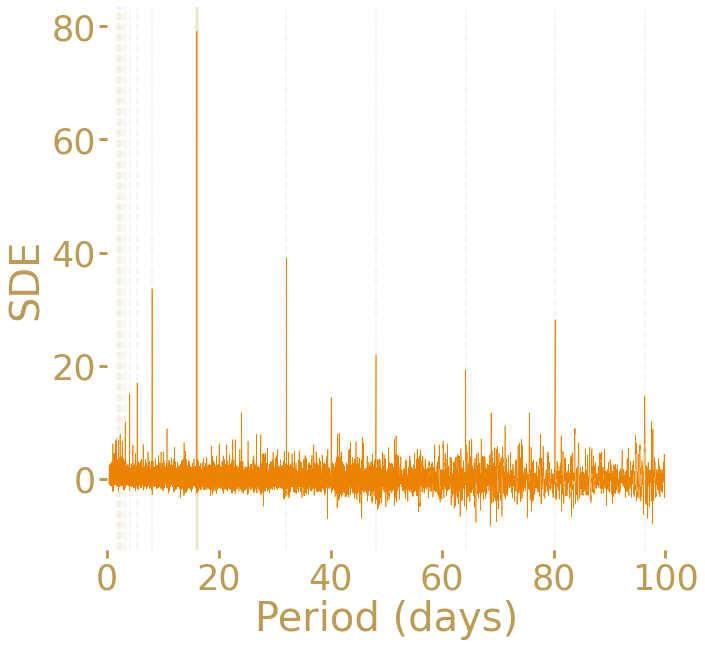

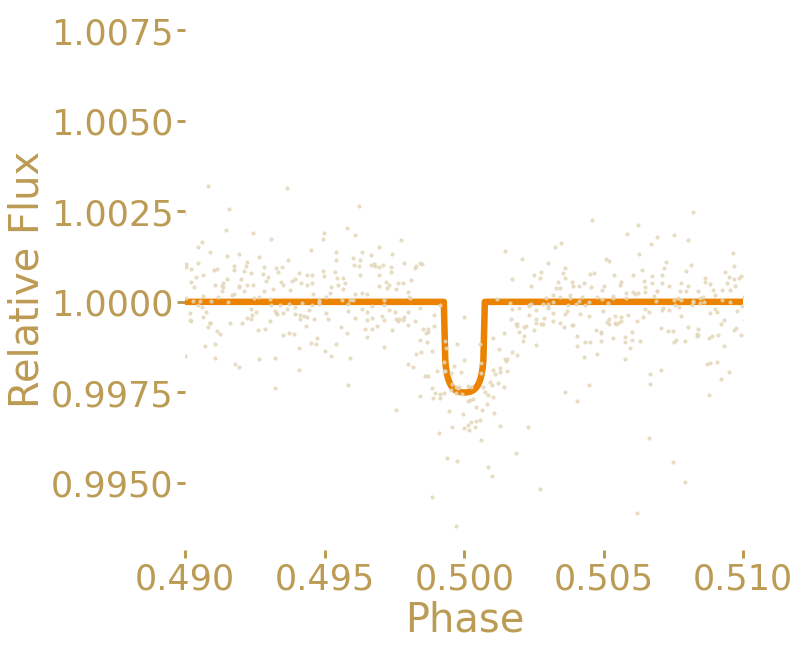

T0:  1340.0739108695298 duration:  0.009949328883795665 npoints_dur:  1.0
Transit Least Squares TLS 1.0.31 (22 Nov 2021)
max duration: 0.15945862285584095 d, min duration: 0.0004763524283299538 d
Creating model cache for 62 durations
Searching 37907 data points, 225665 periods from 0.331 to 99.999 days
Using all 12 CPU threads


100%|████████████████████████████████████| 225665/225665 periods | 1:03:23<00:00


No transits were fit:  False
Searching for best T0 for period 71.28496 days


100%|███████████████████████████████████████████████████████| 12228/12228 [00:14<00:00, 851.84it/s]


T0:  1344.6045386695337
model  [1.31901760e-05 3.95712238e-05 6.59522717e-05 ... 9.99960428e-01
 9.99986809e-01 1.00001319e+00]
SNR [ 1.05389133 -0.11046893  0.49105092  3.18961517  0.          0.
  0.          0.          0.          0.          8.13582758  0.
  0.          0.         -1.11454183]
planet radius 0.031034800744148074
Duration:  0.02885948470364912
done with multis!
lengths 1 1
running single transit search
Creating model cache for 23 durations
454 (454, 16) 16


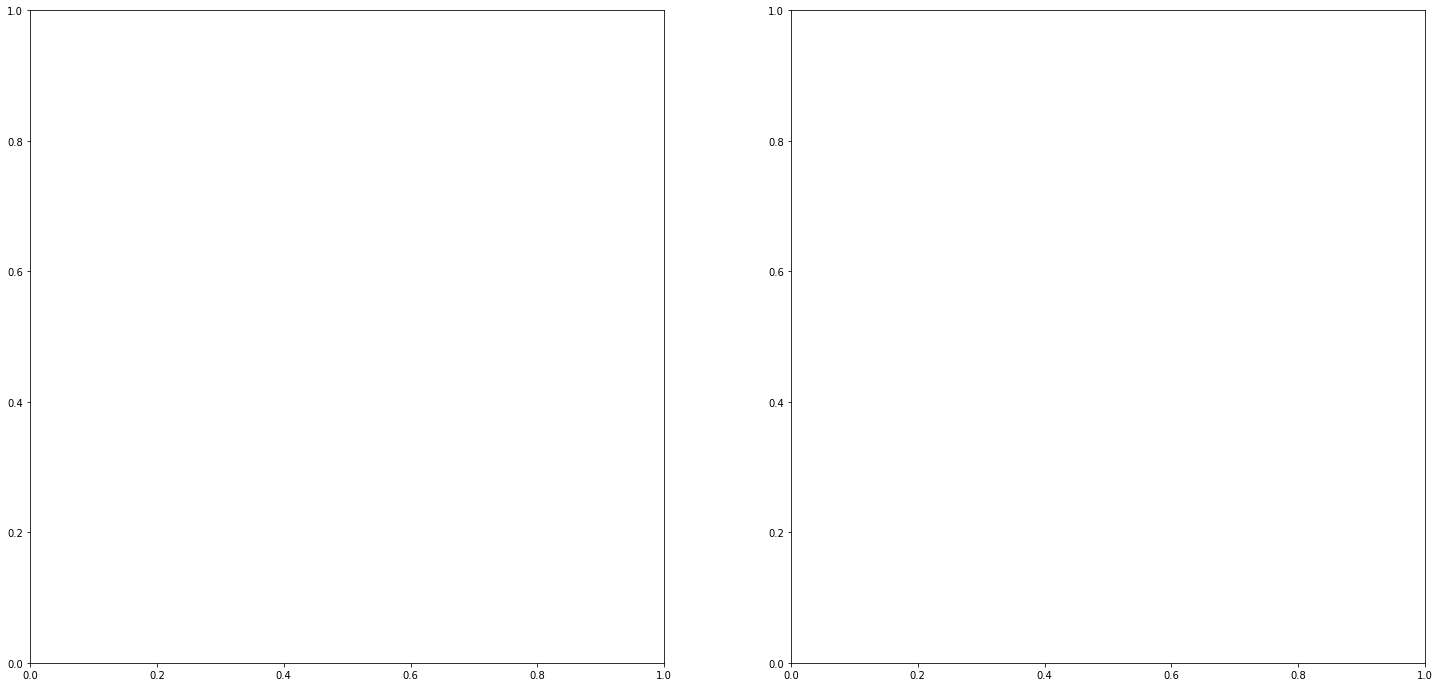

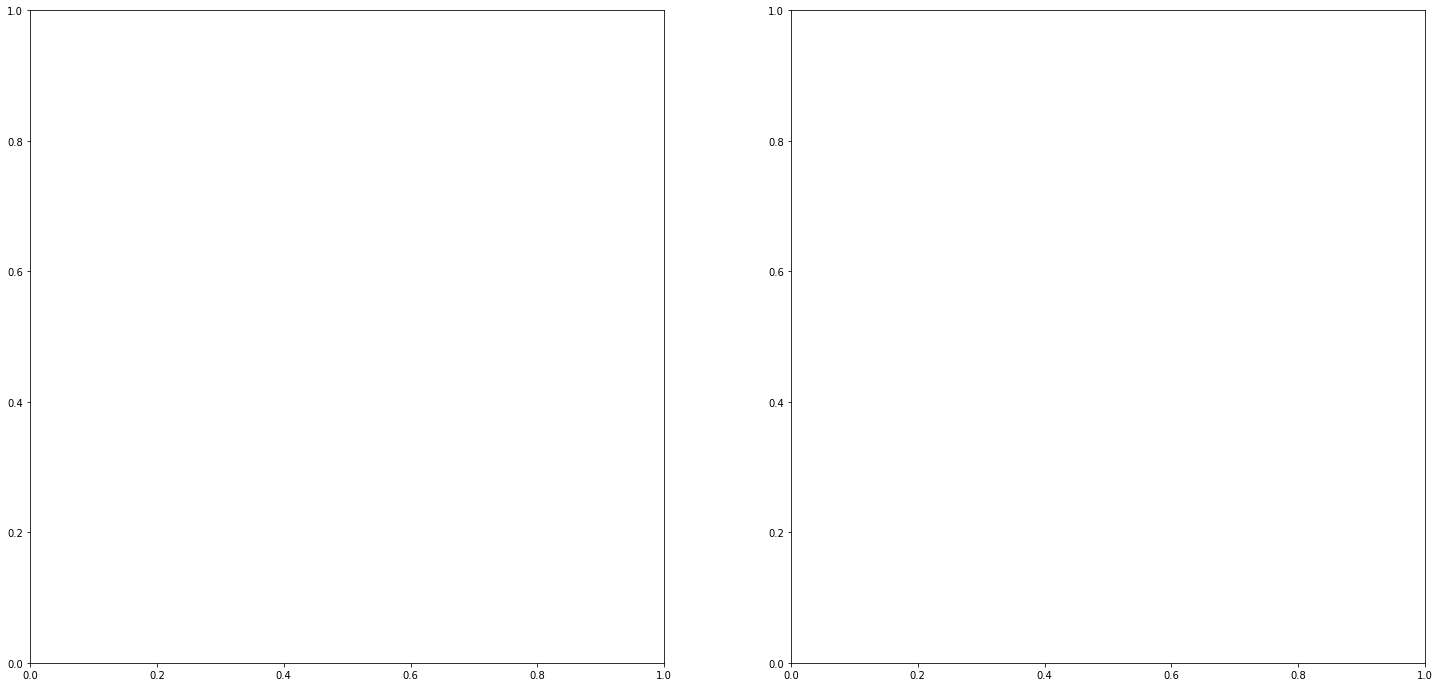

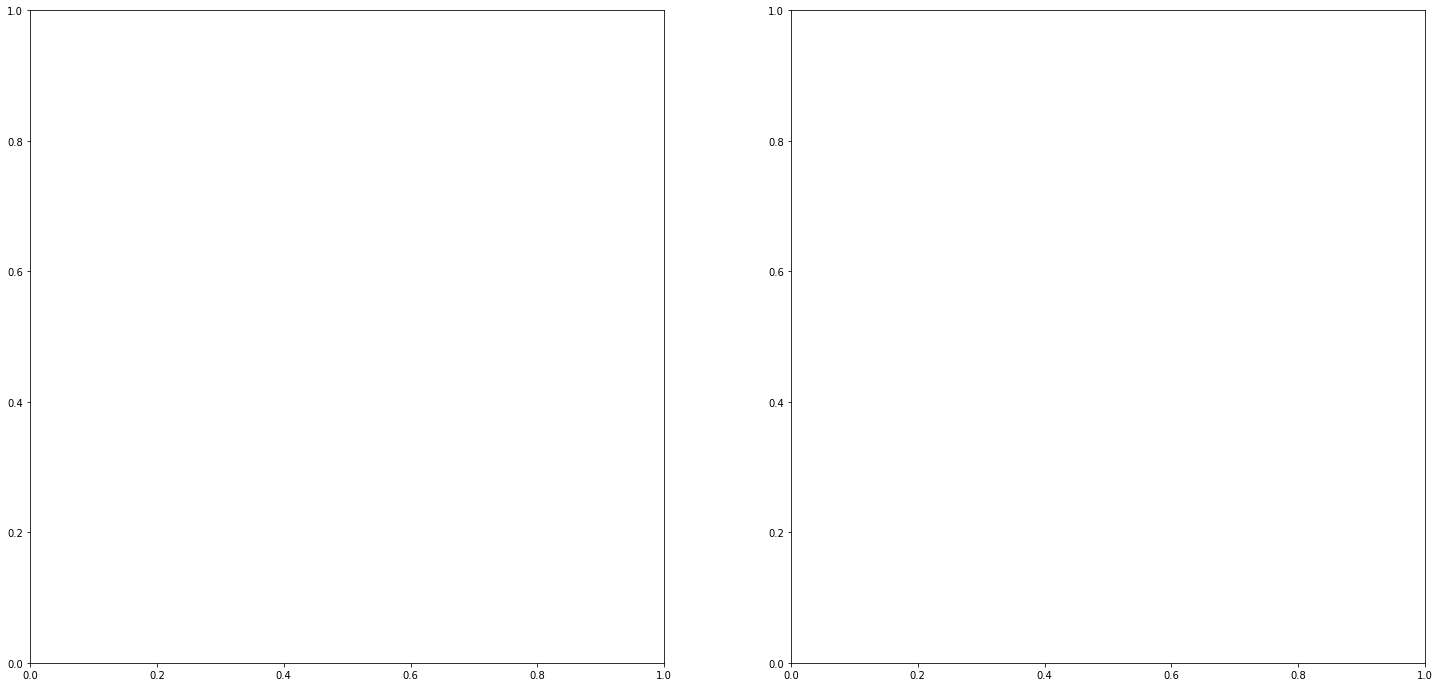

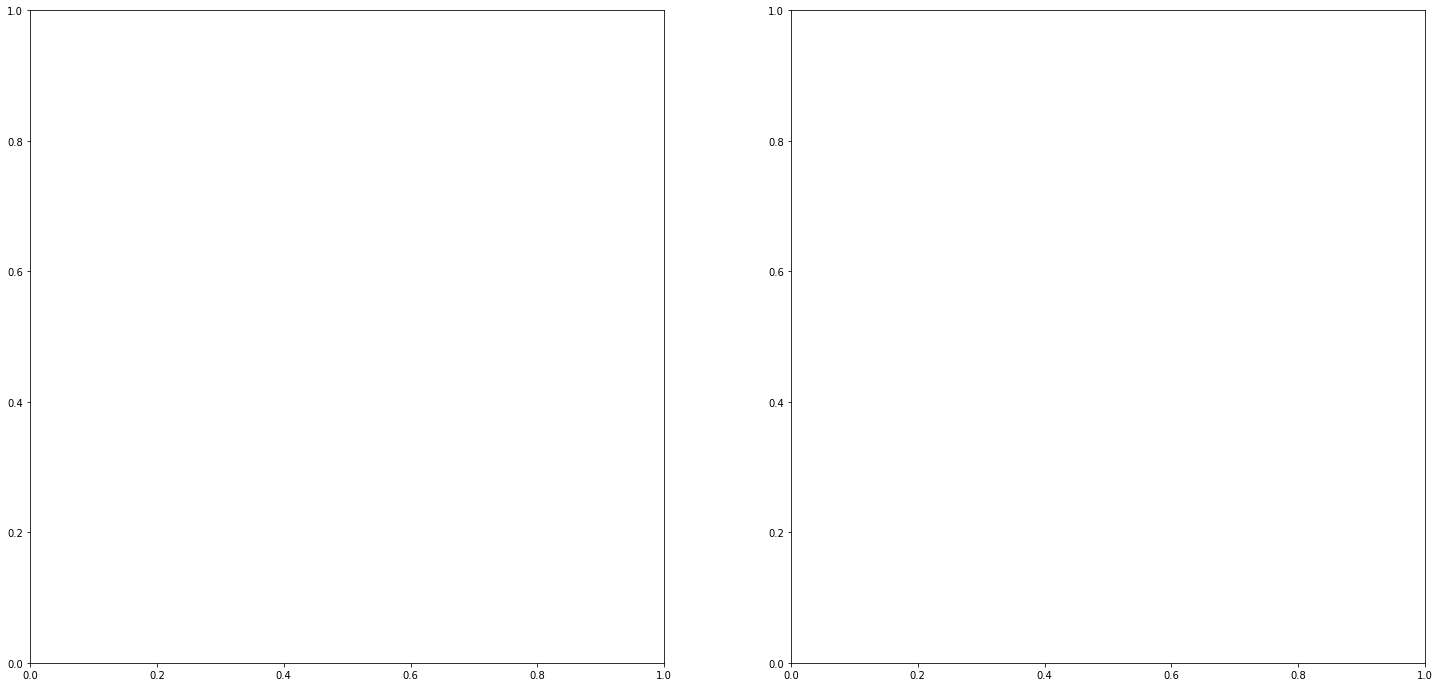

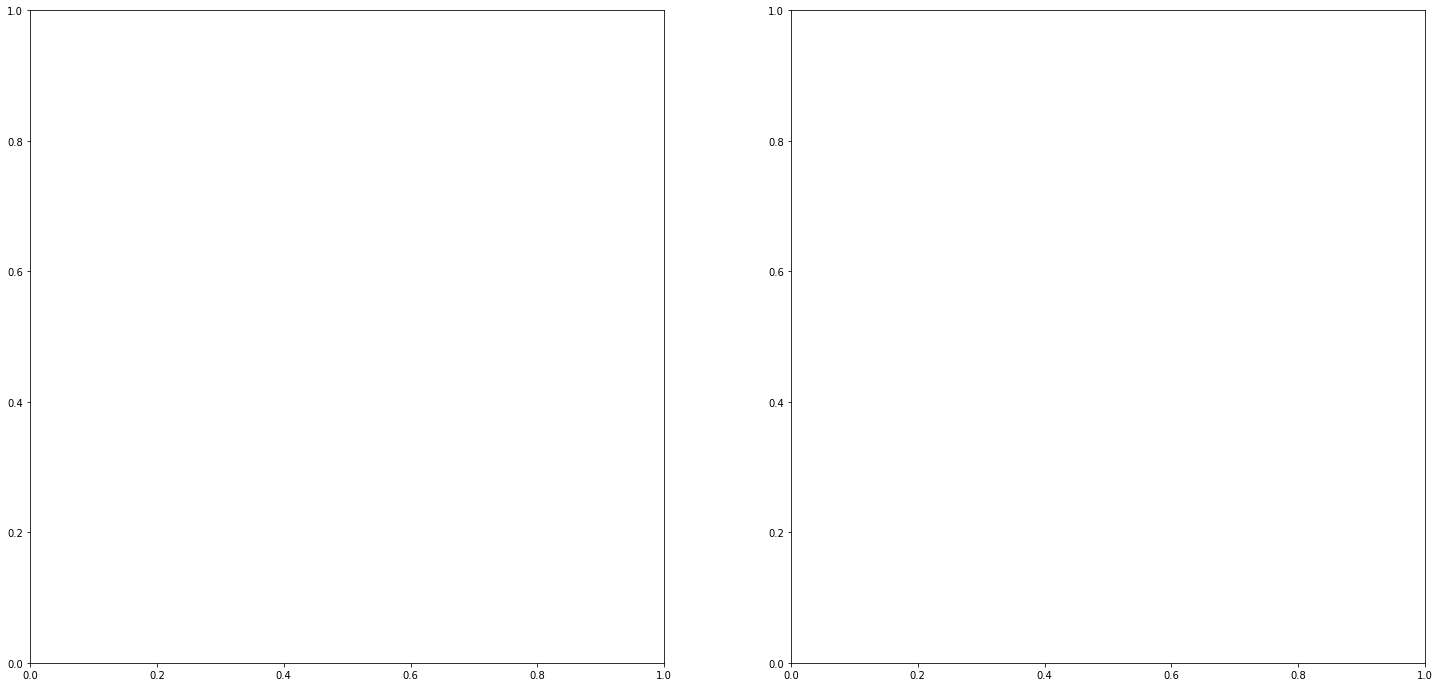

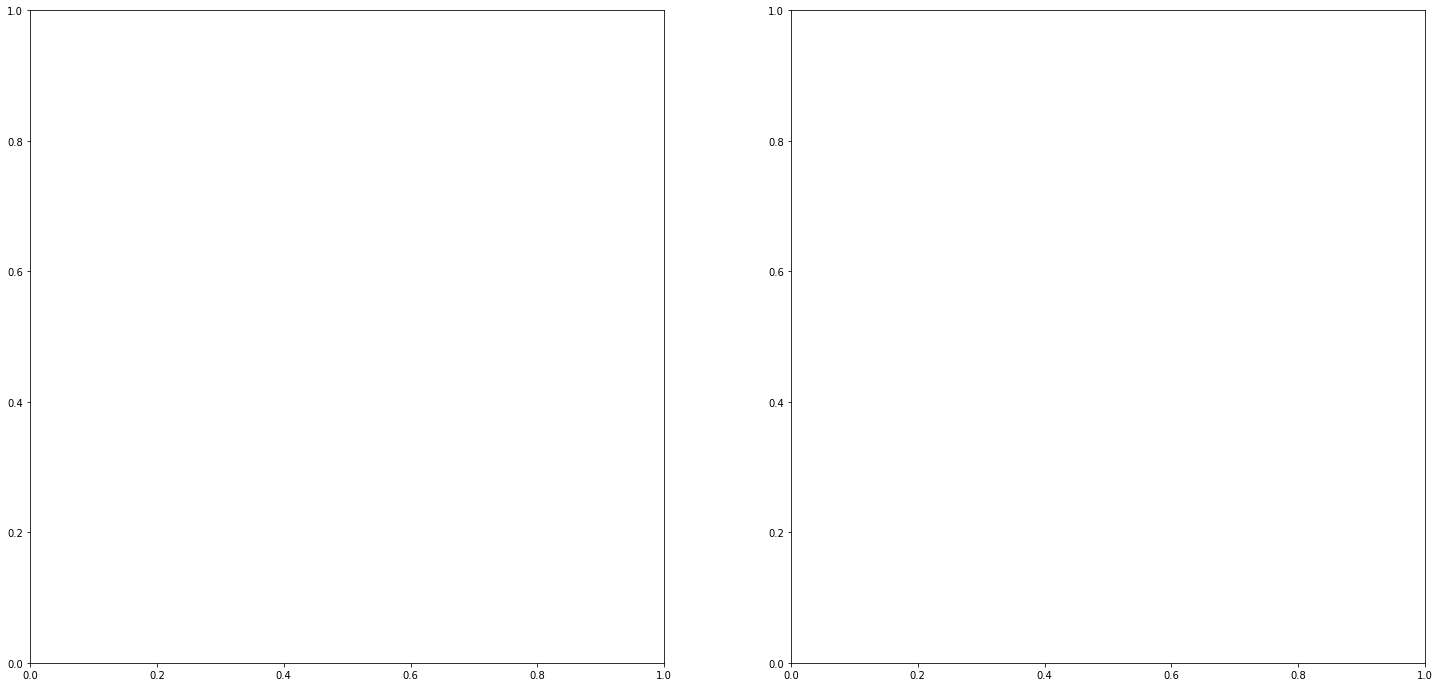

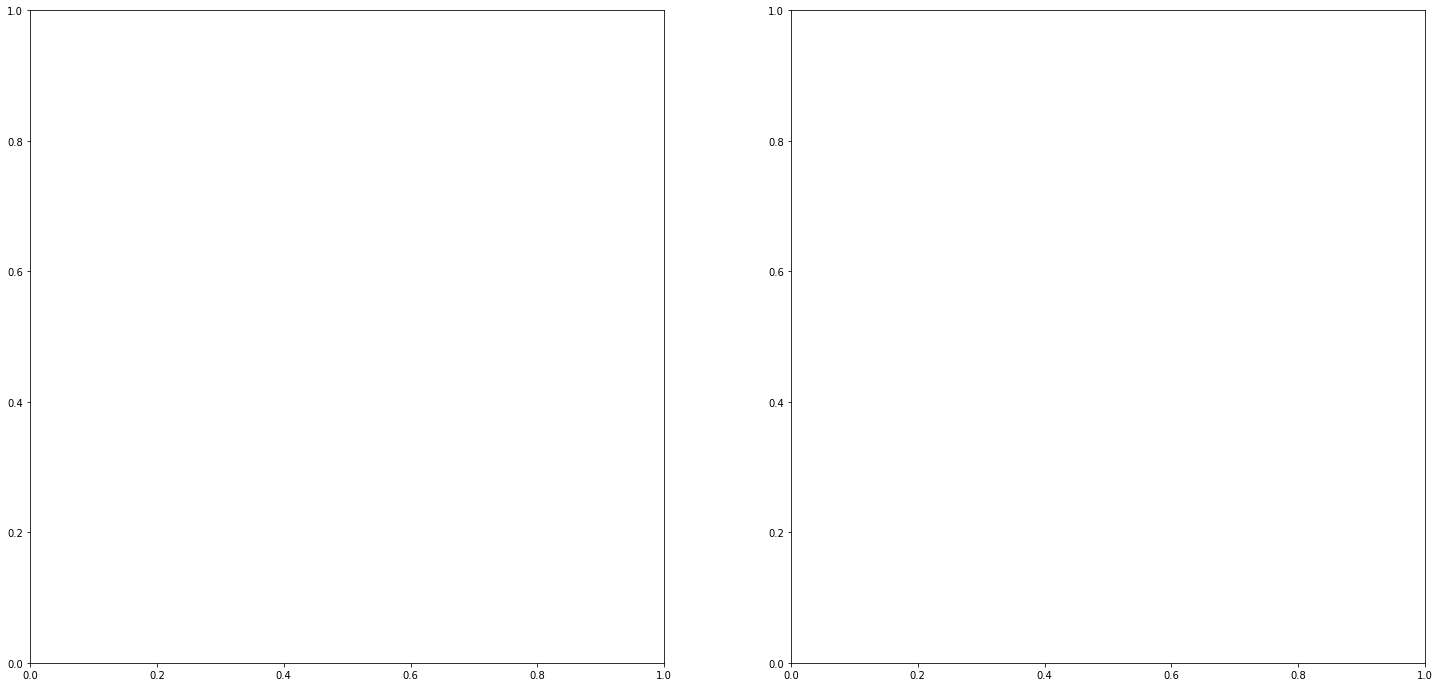

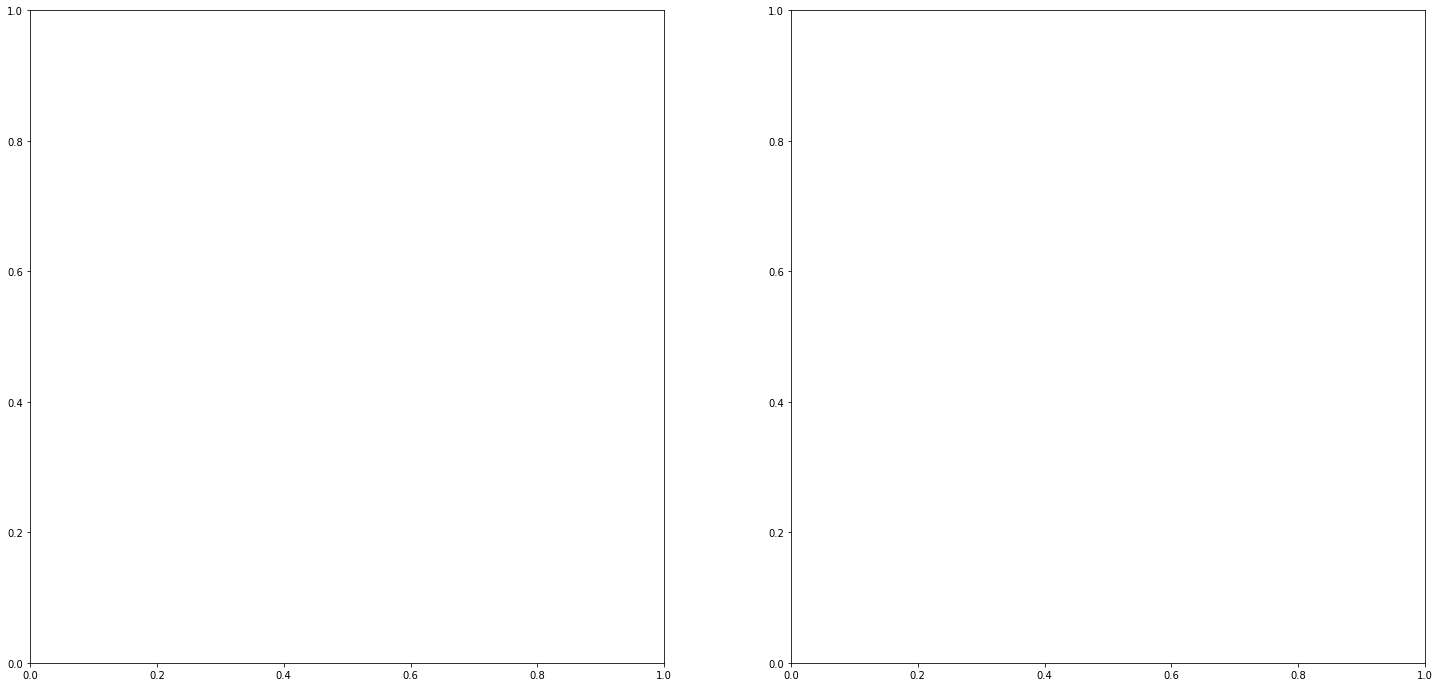

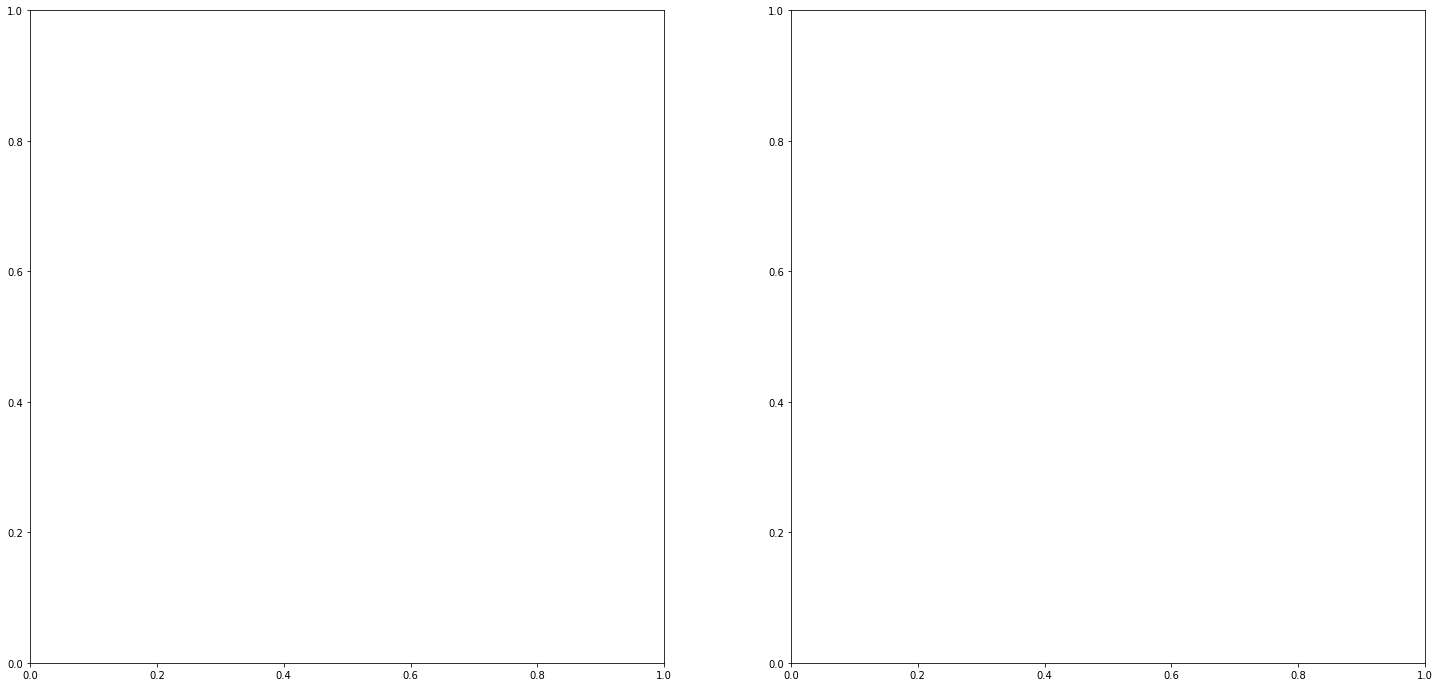

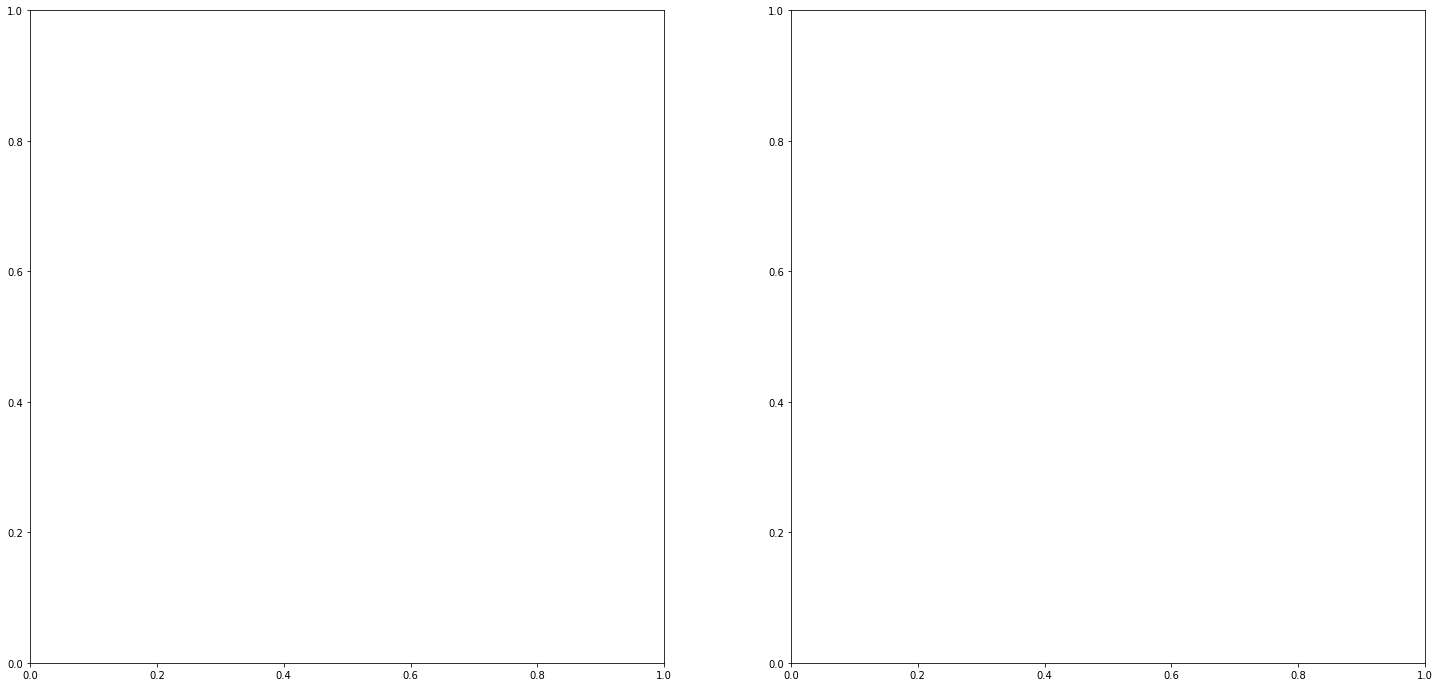

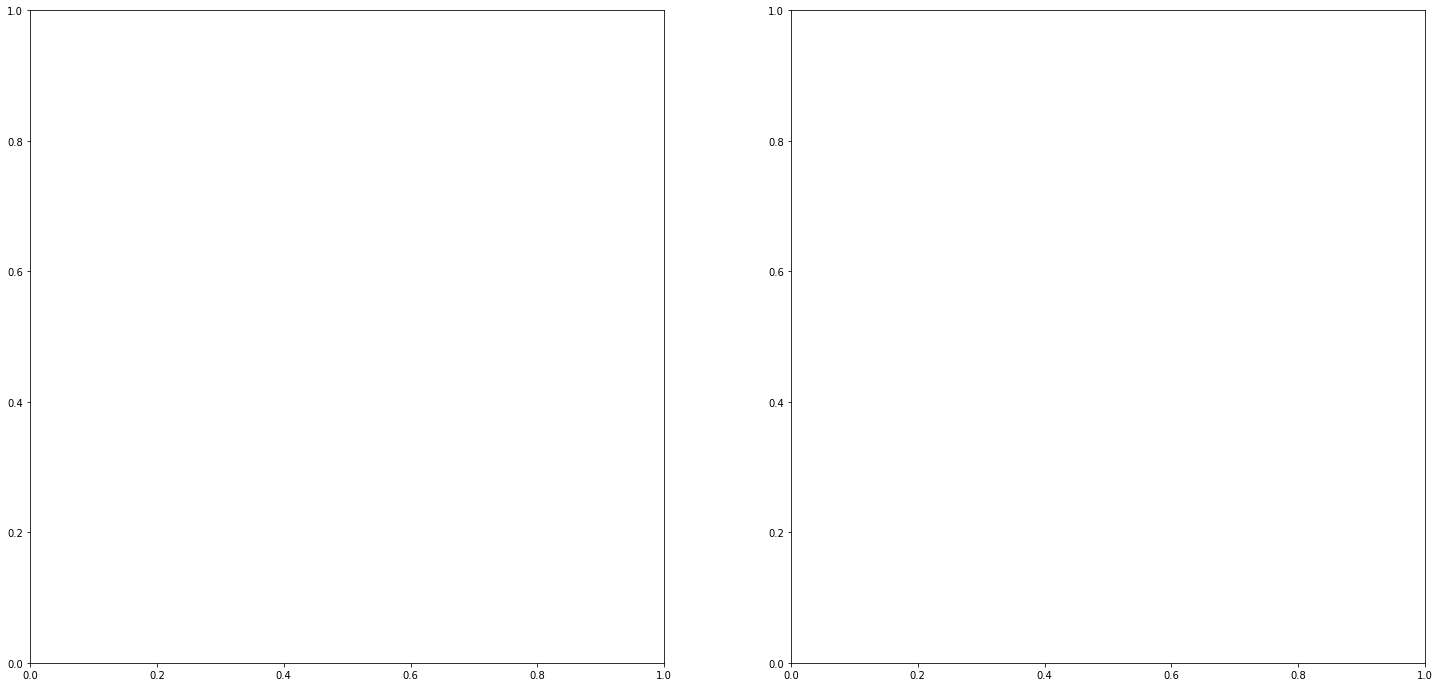

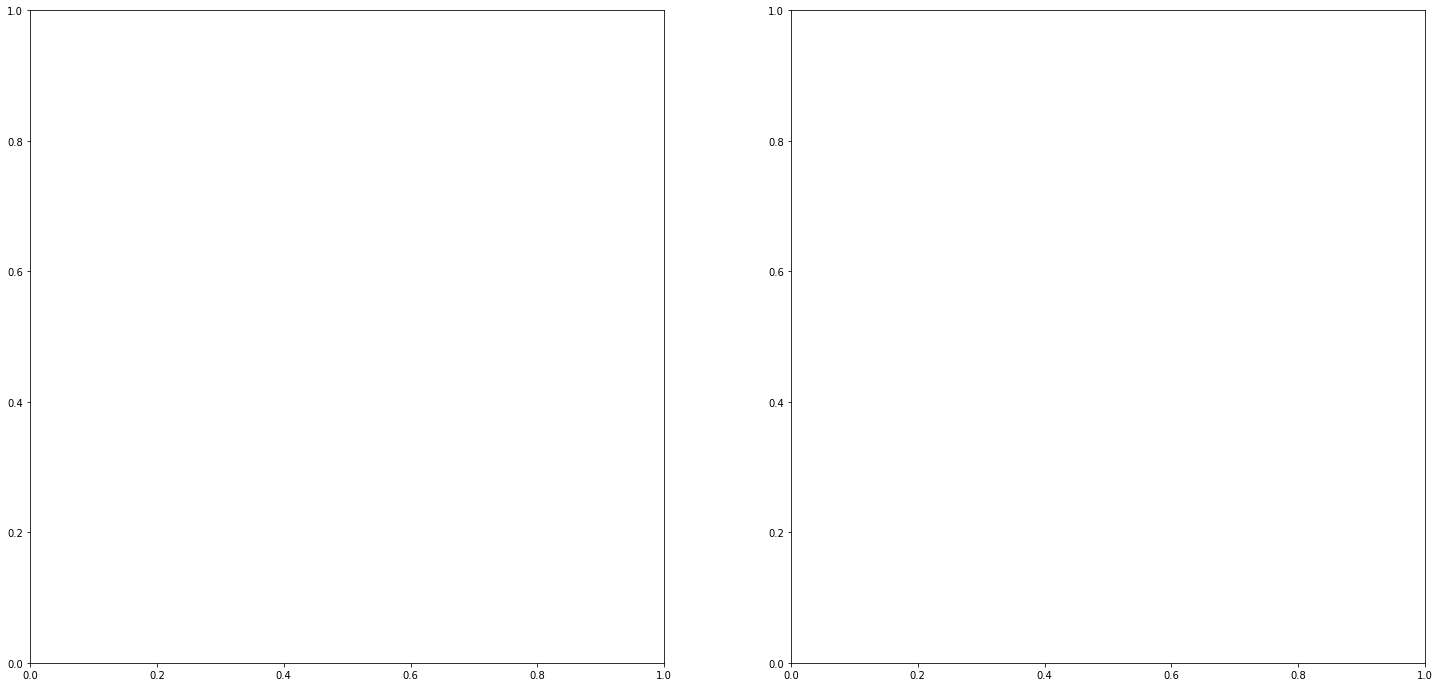

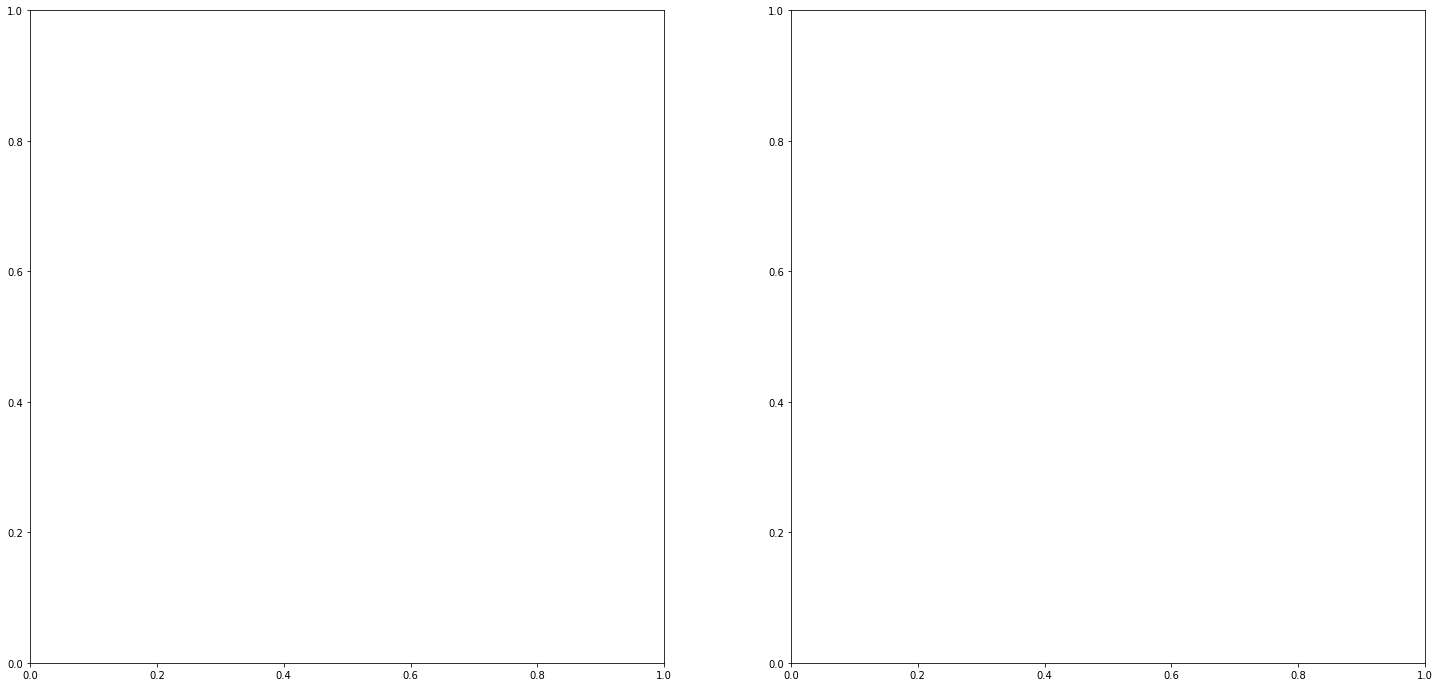

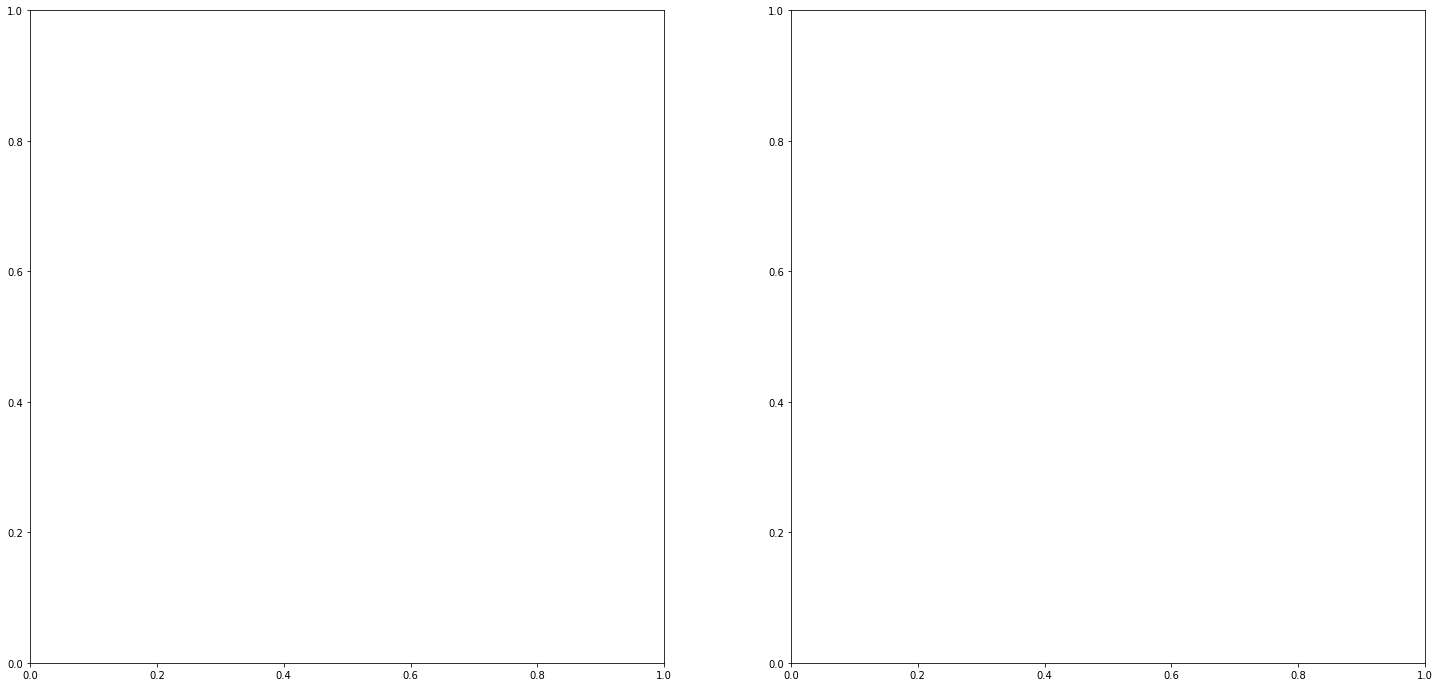

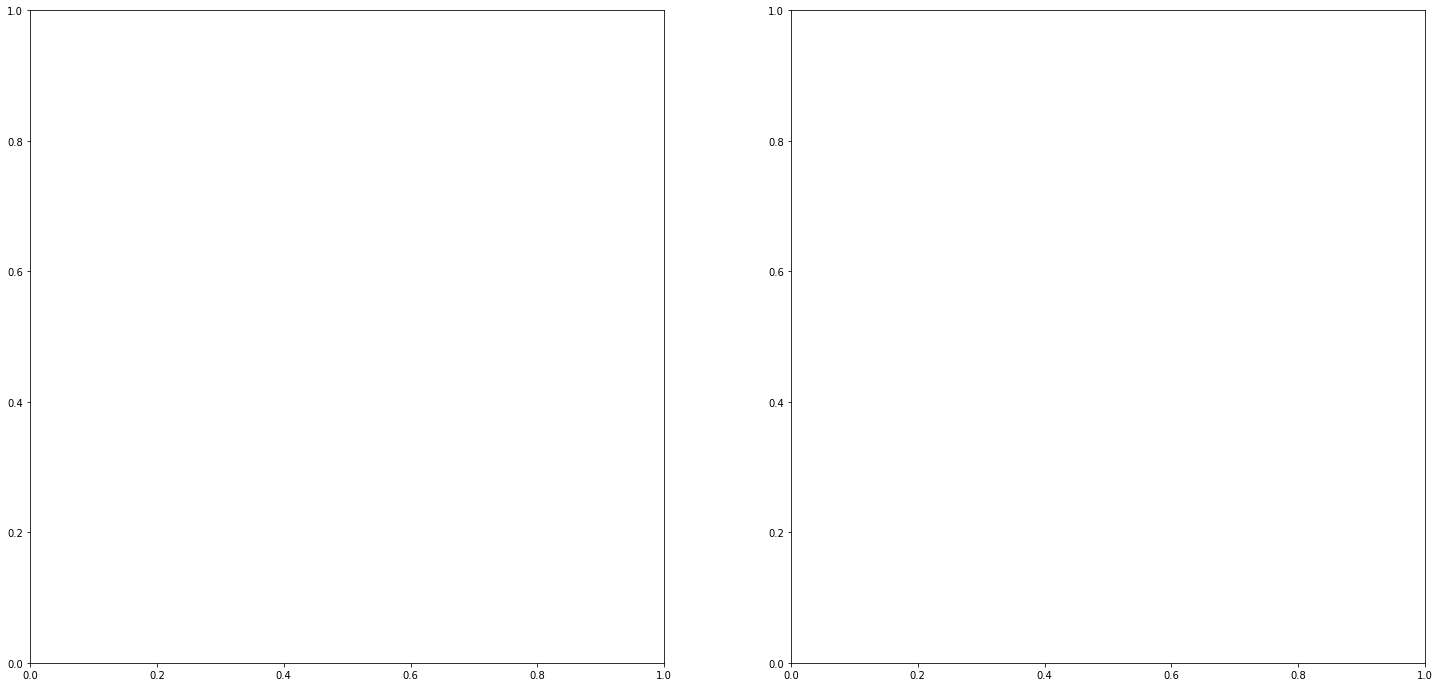

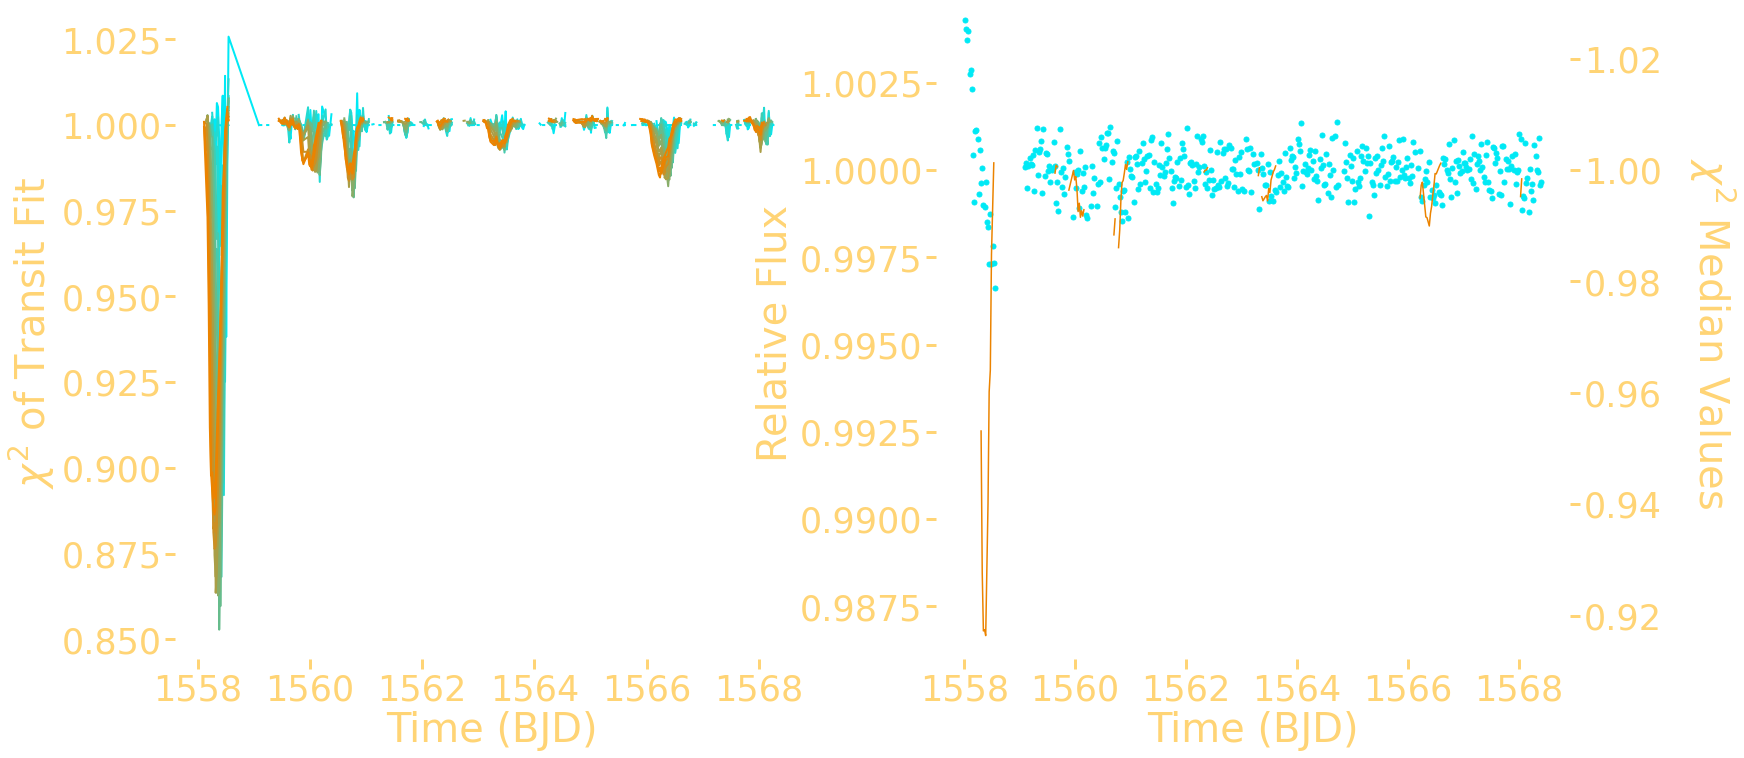

504 (504, 12) 12


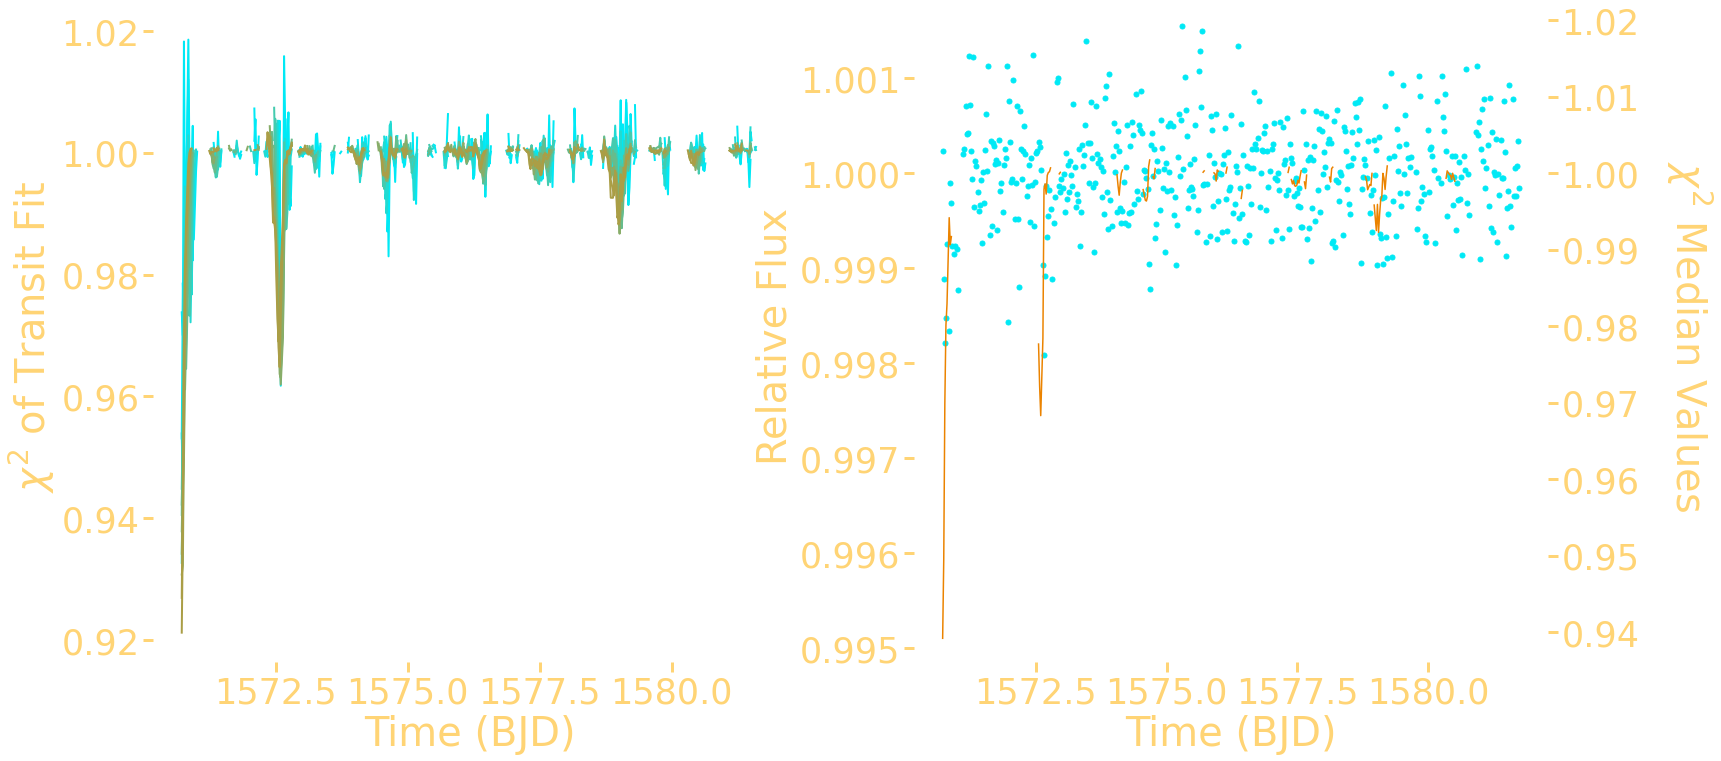

1600 (1600, 19) 19


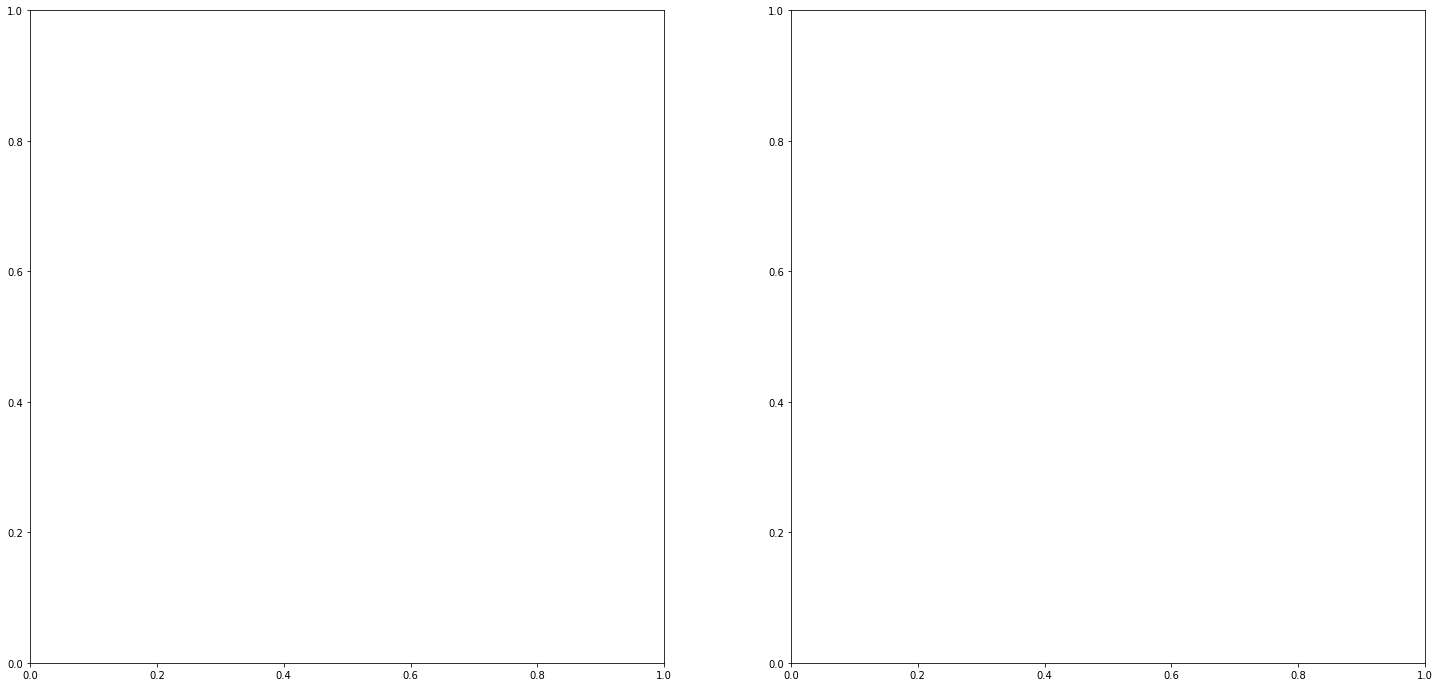

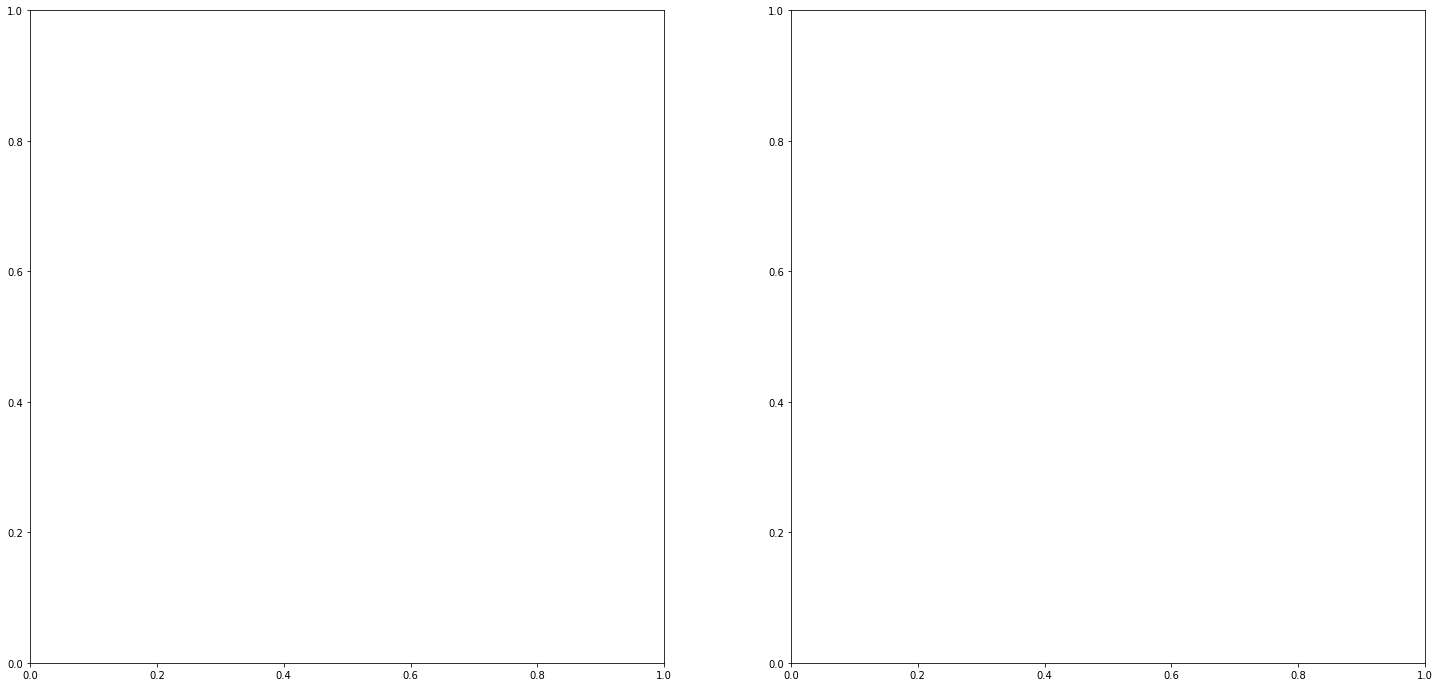

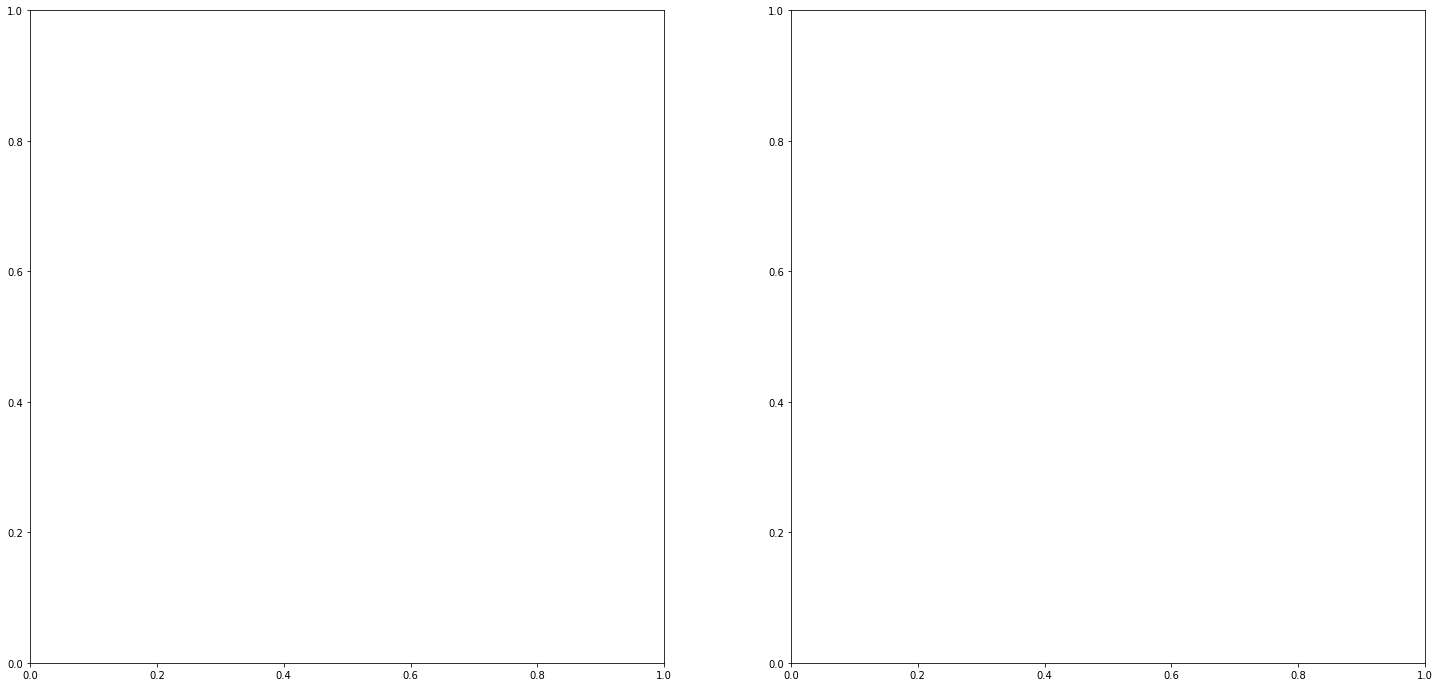

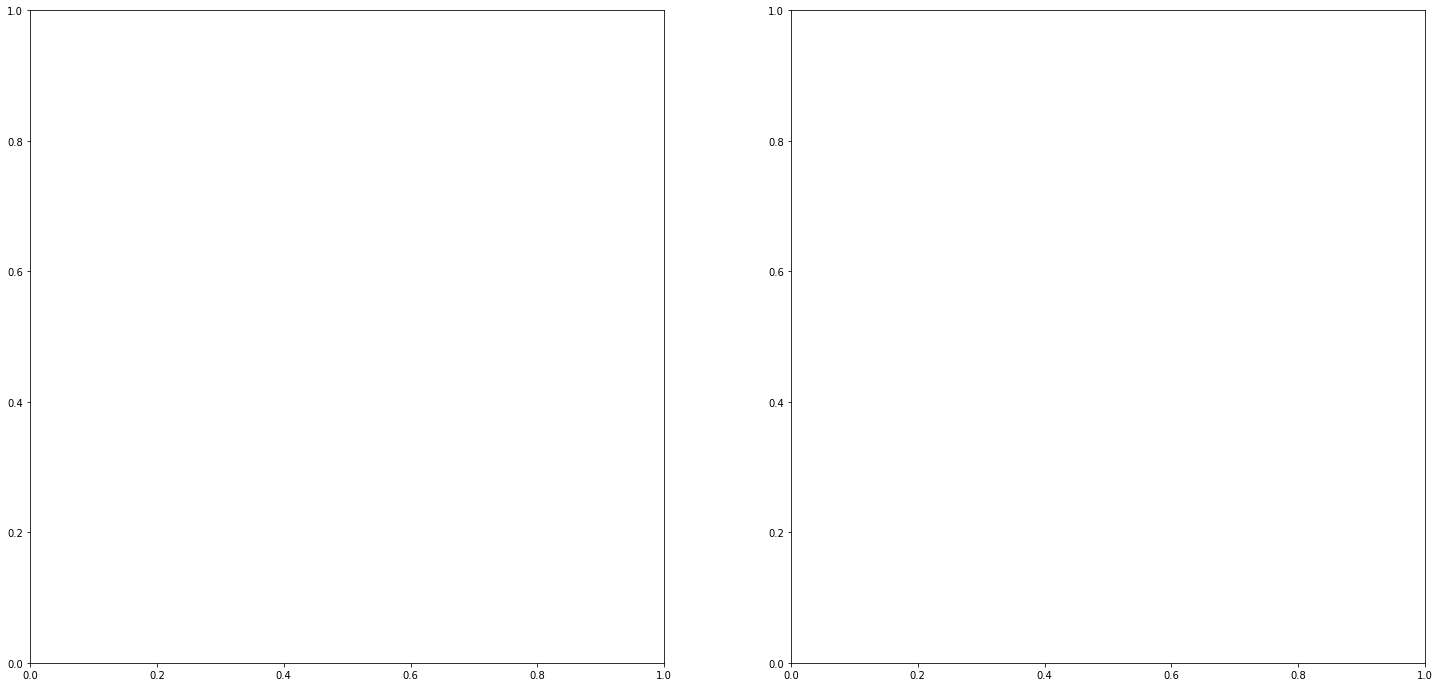

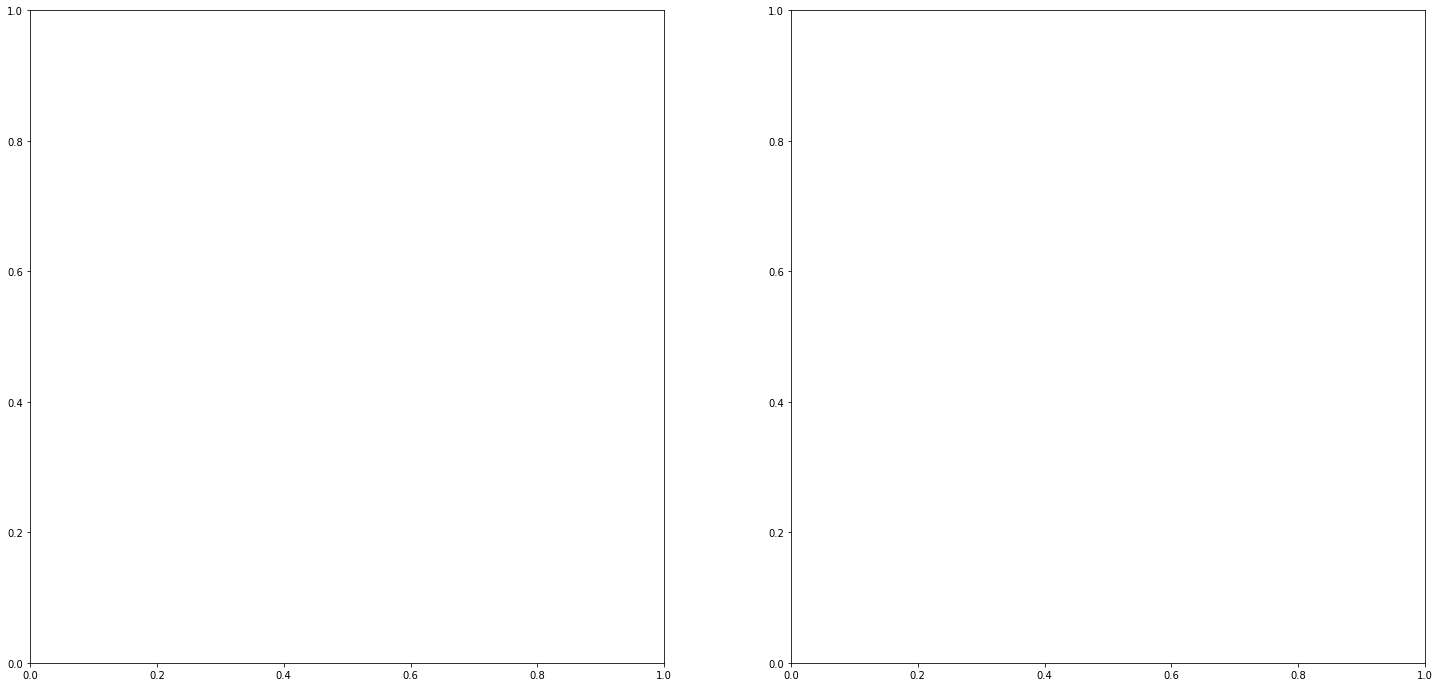

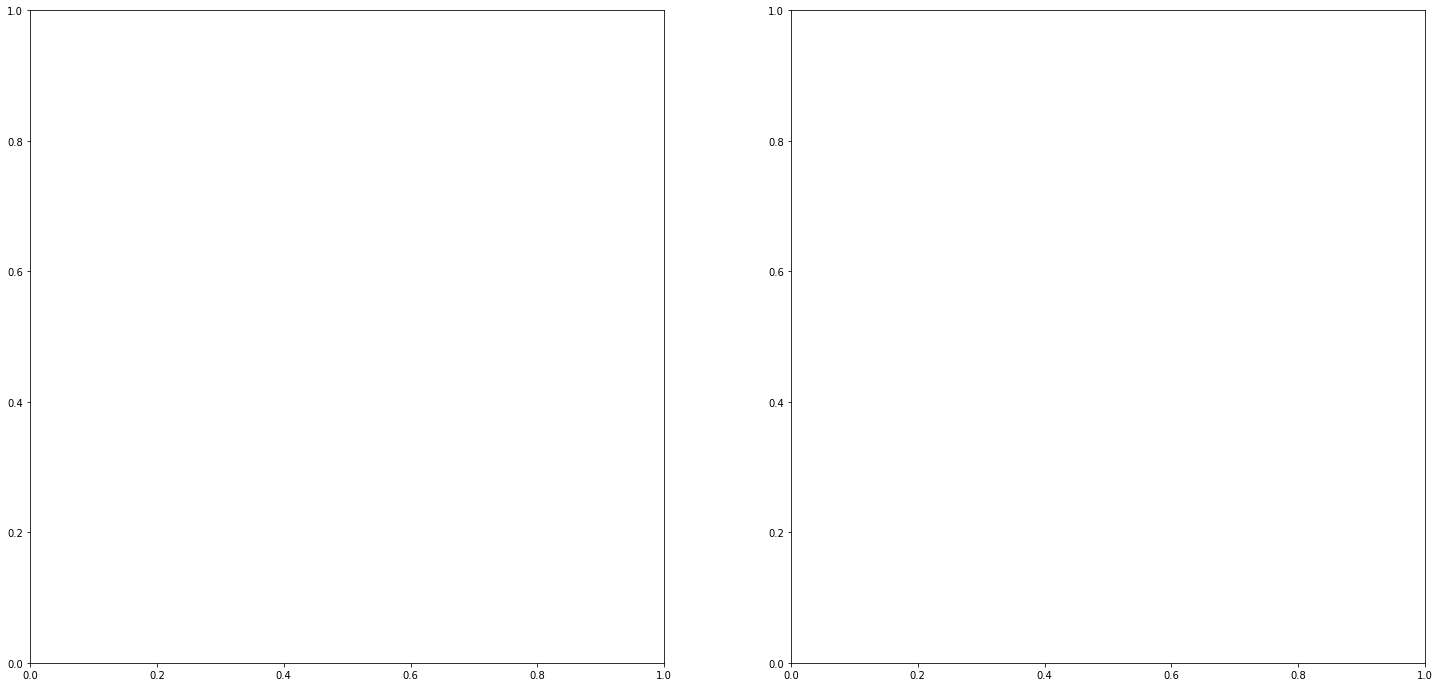

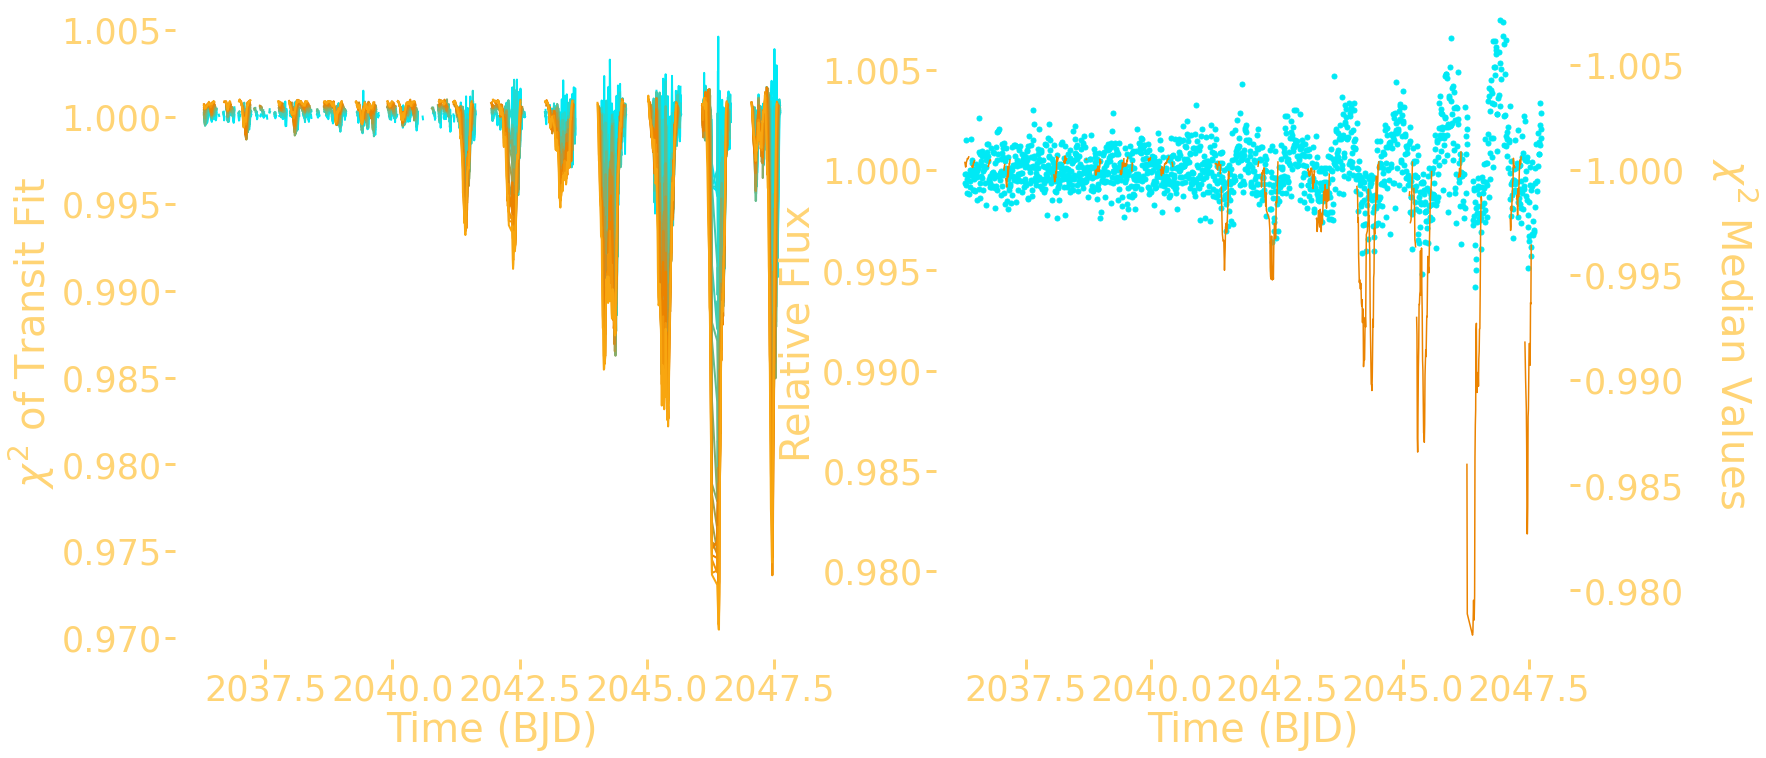

1500 (1500, 20) 20


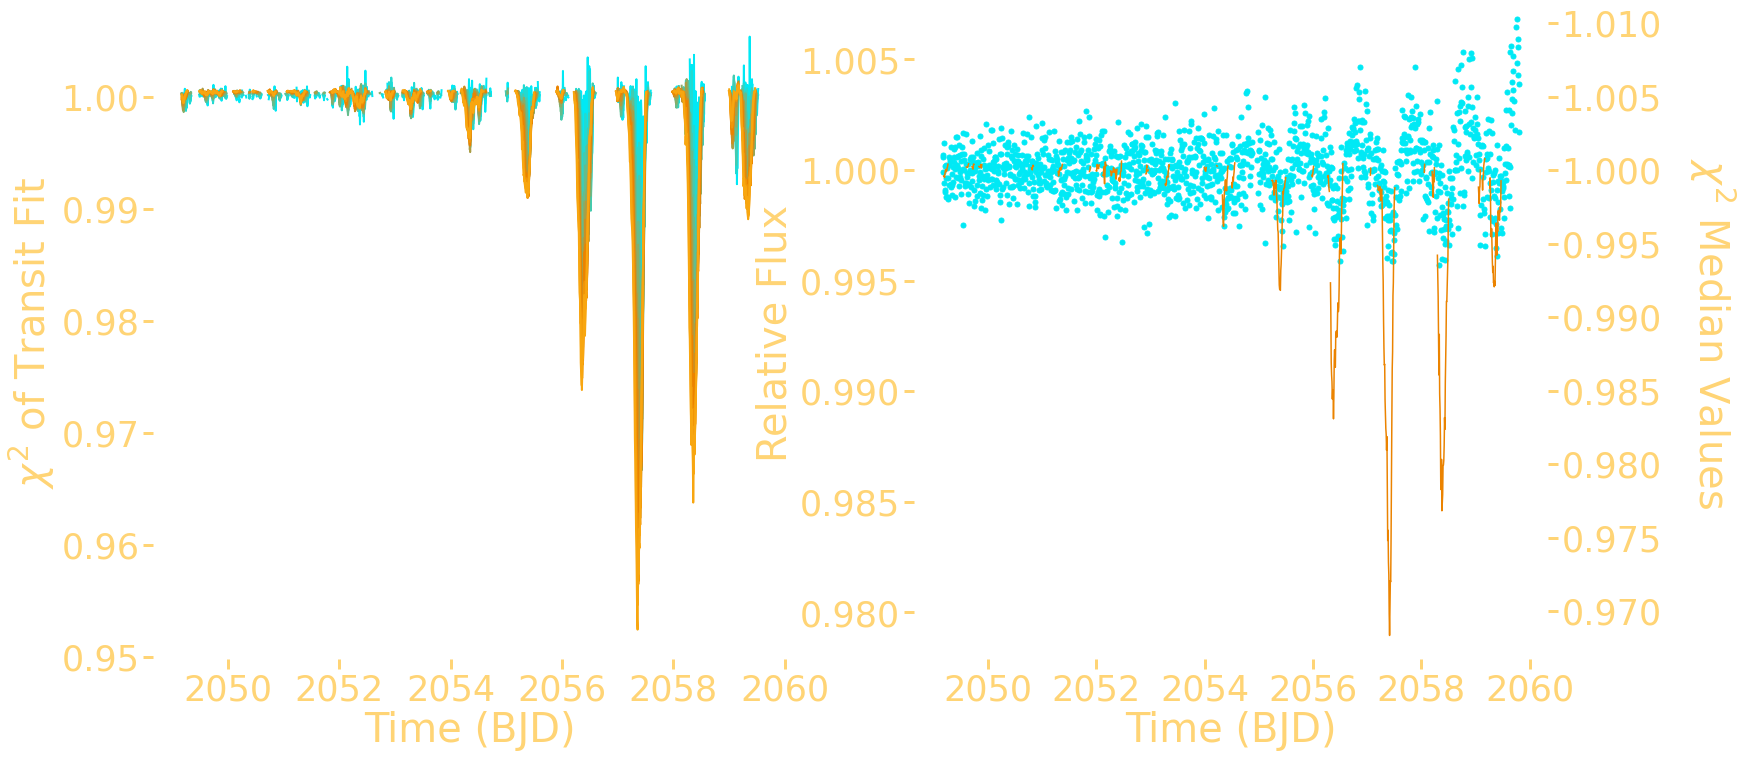

1445 (1445, 3) 3


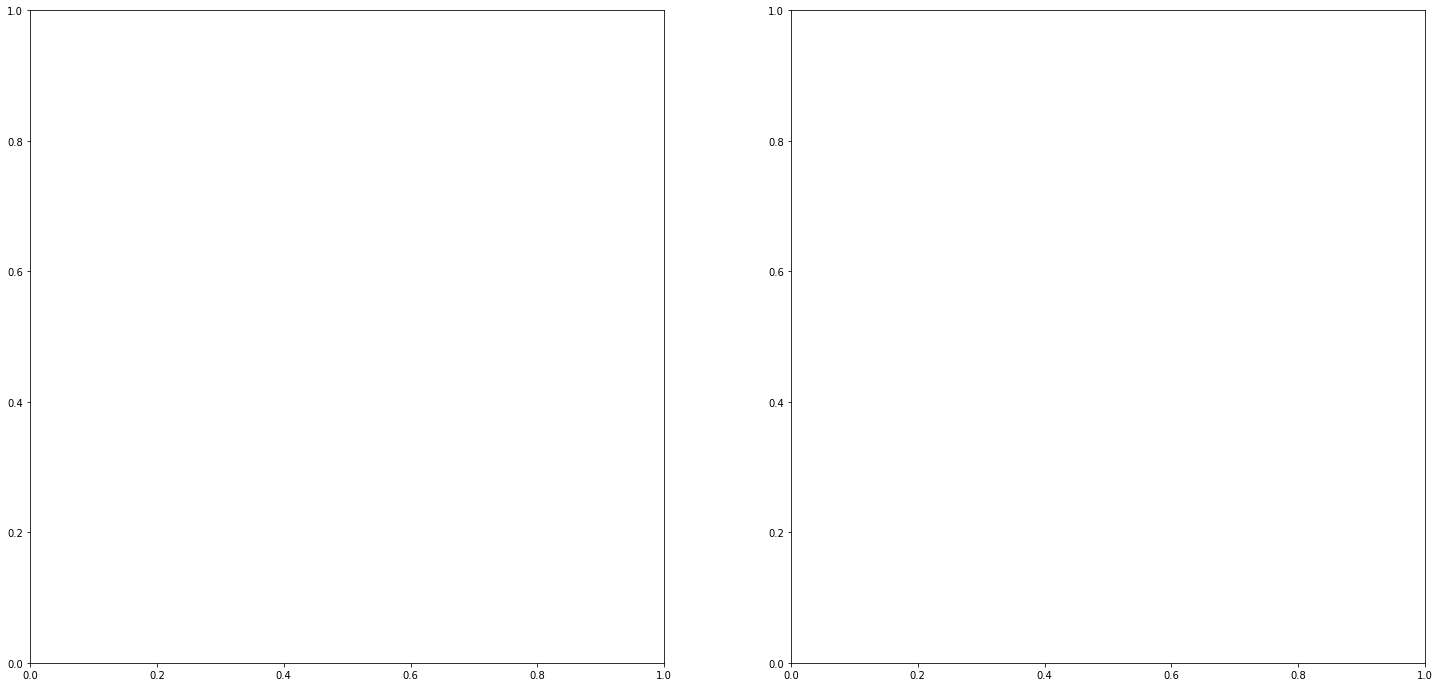

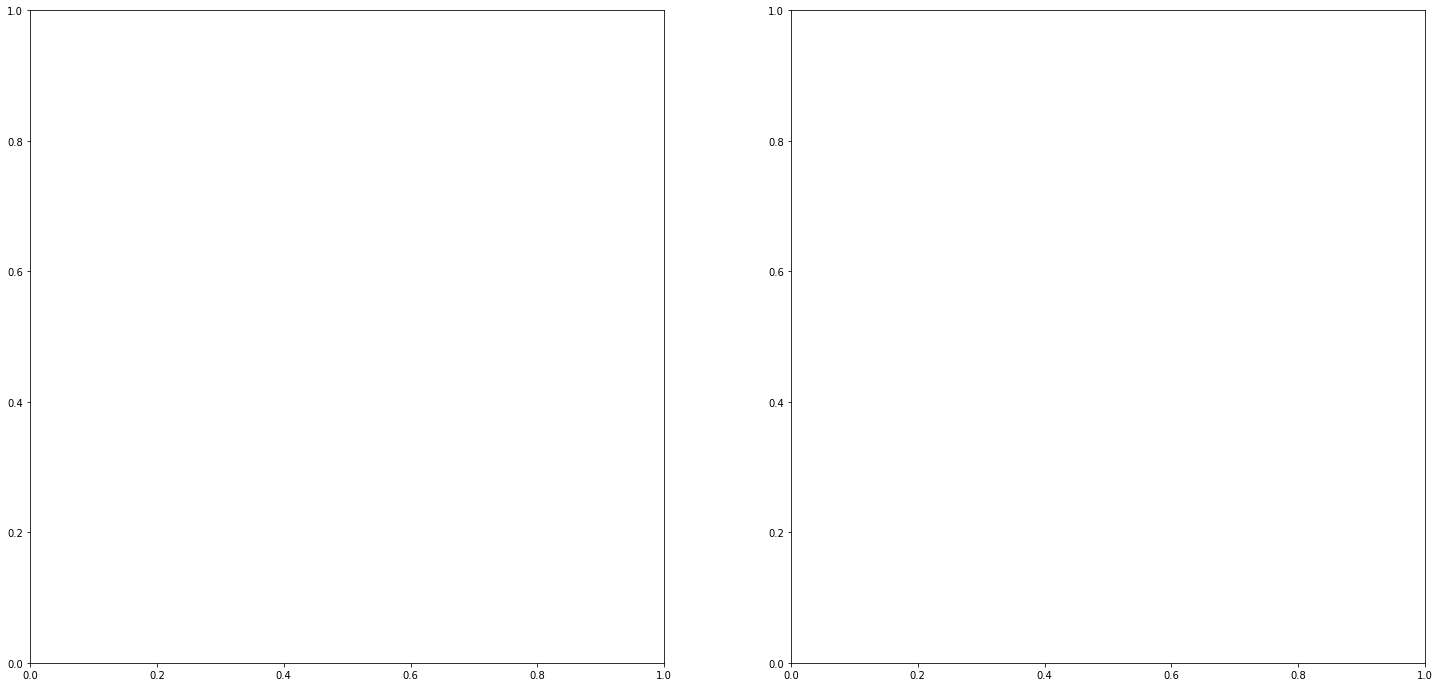

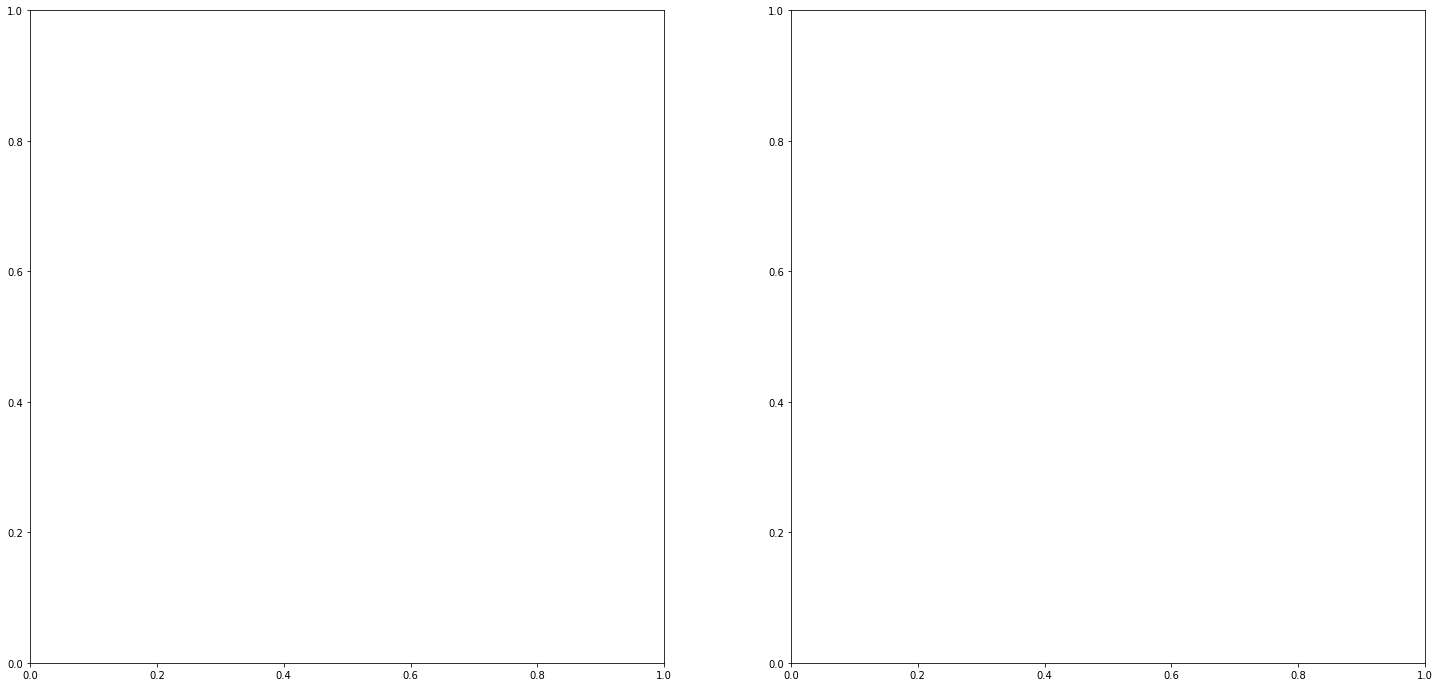

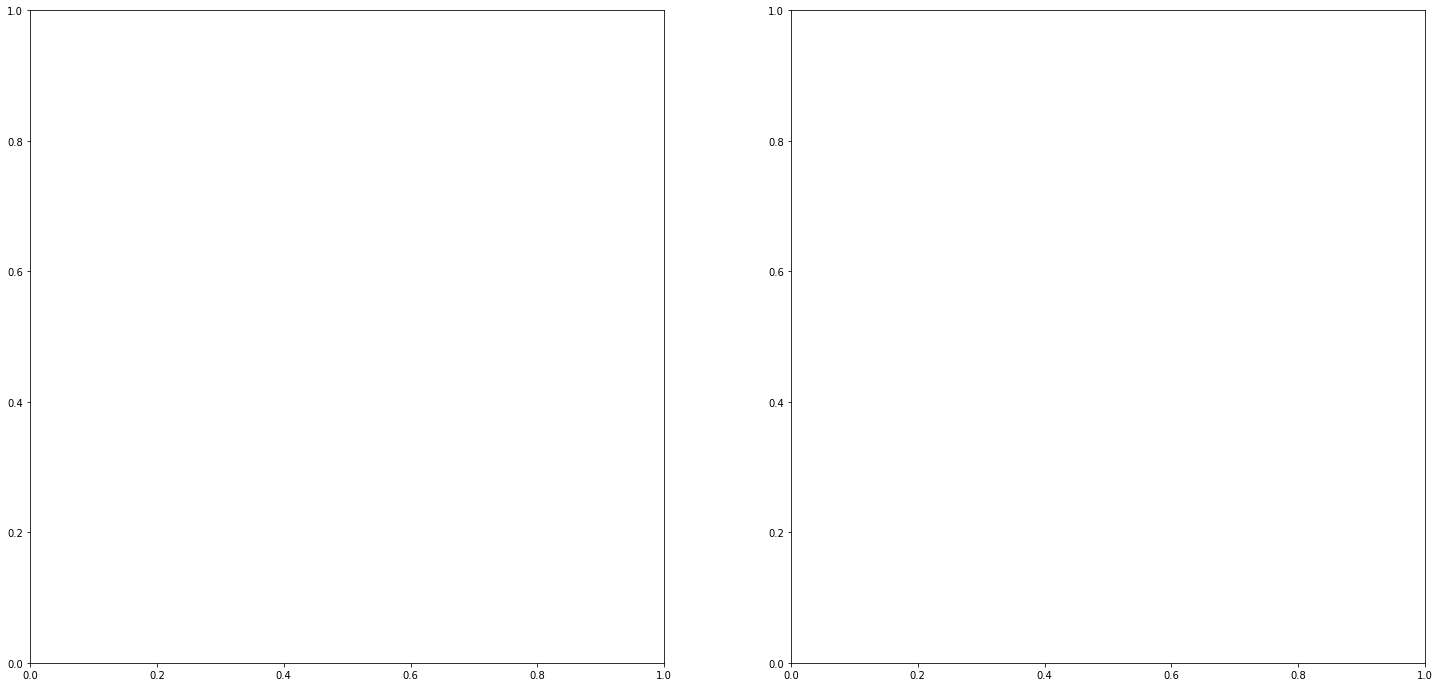

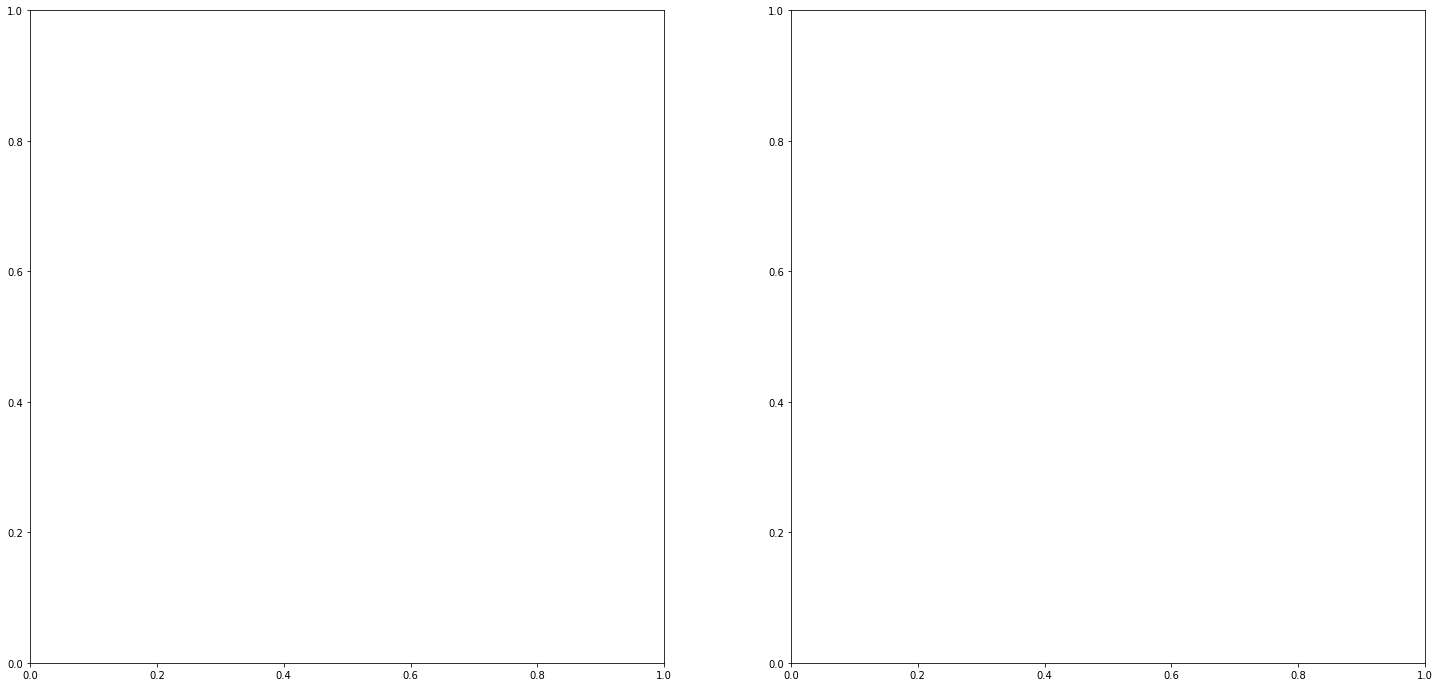

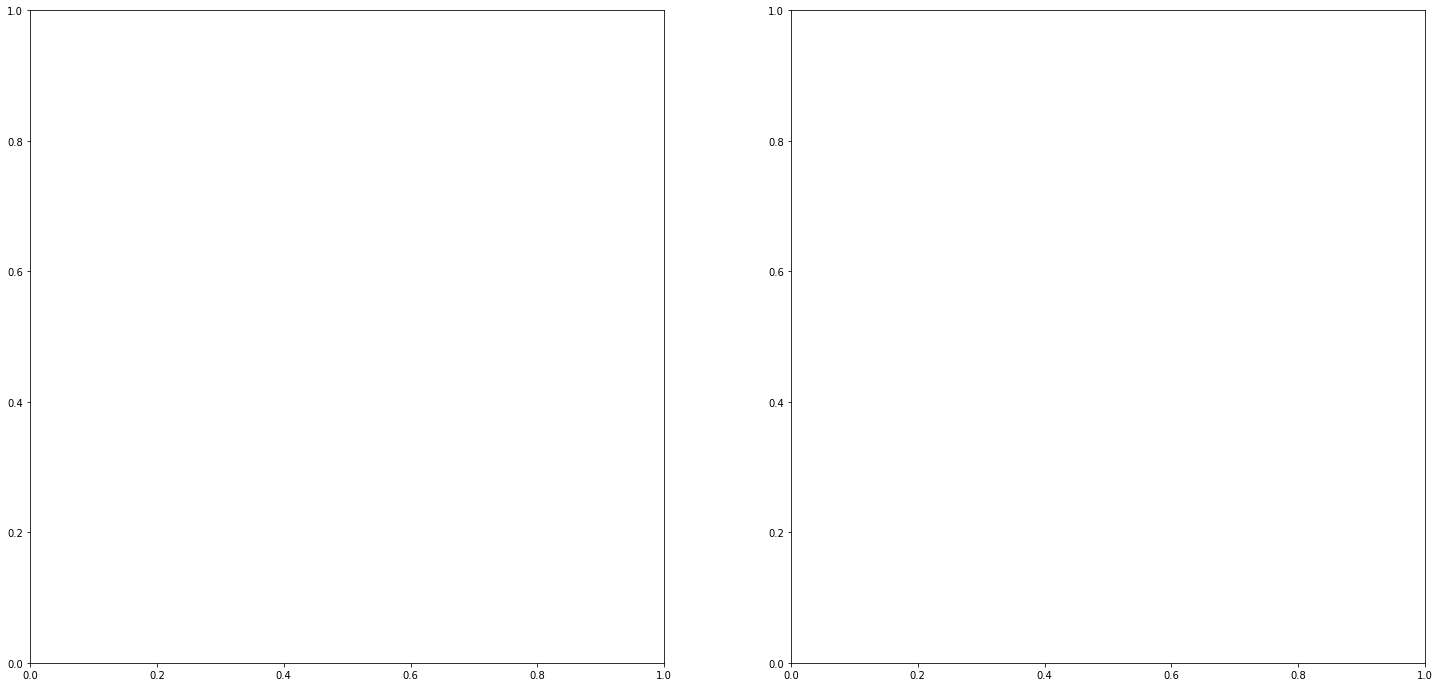

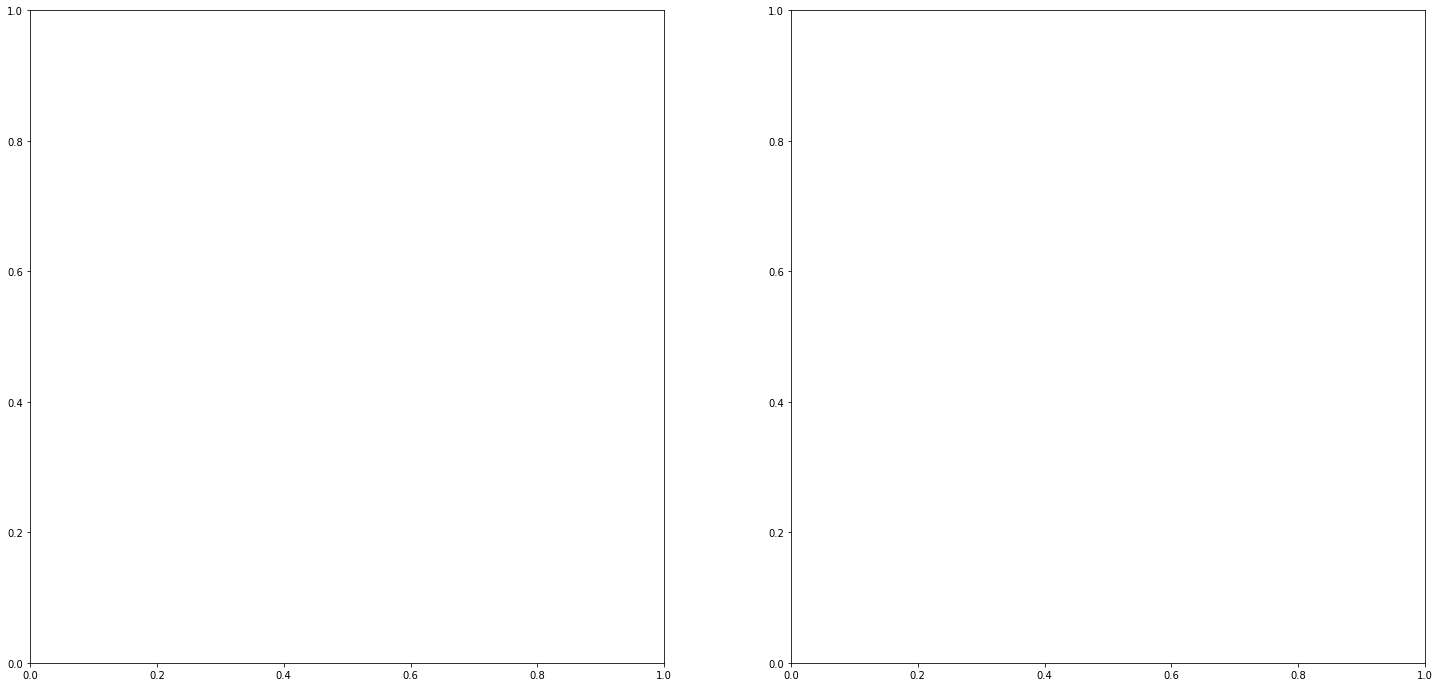

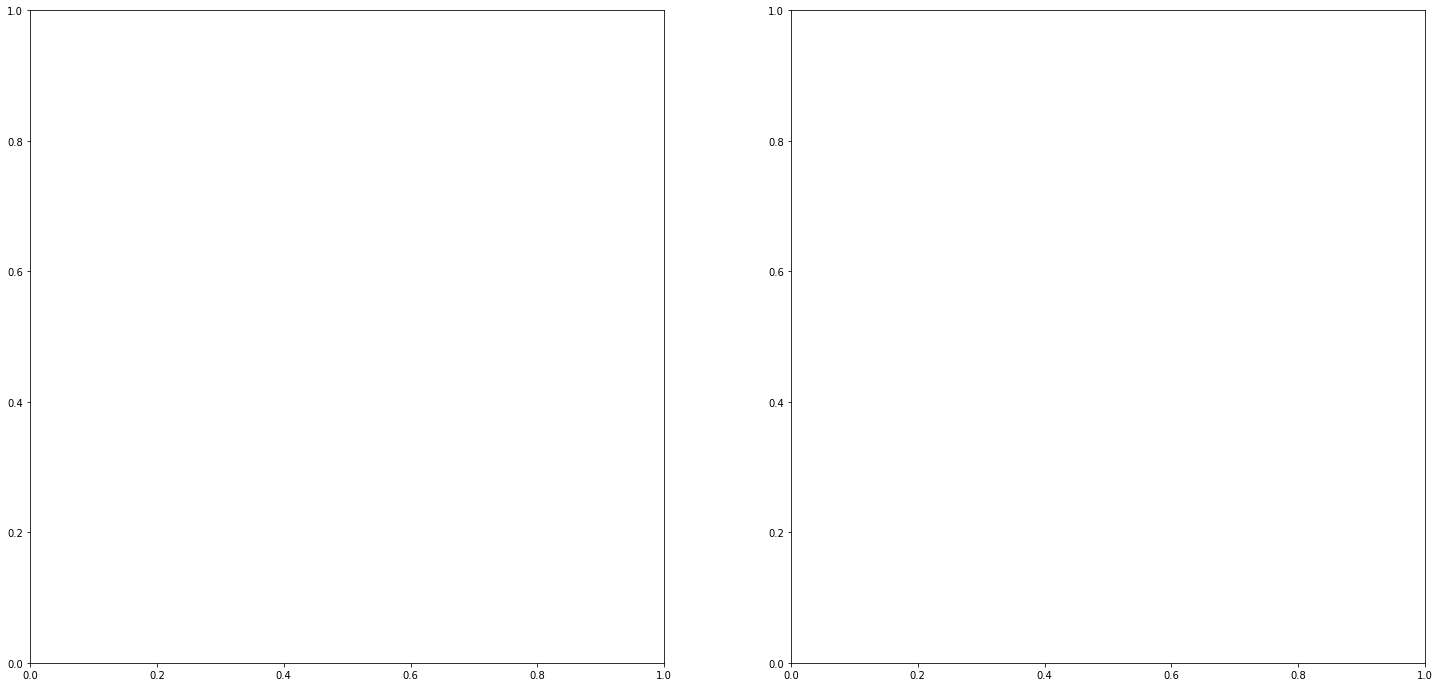

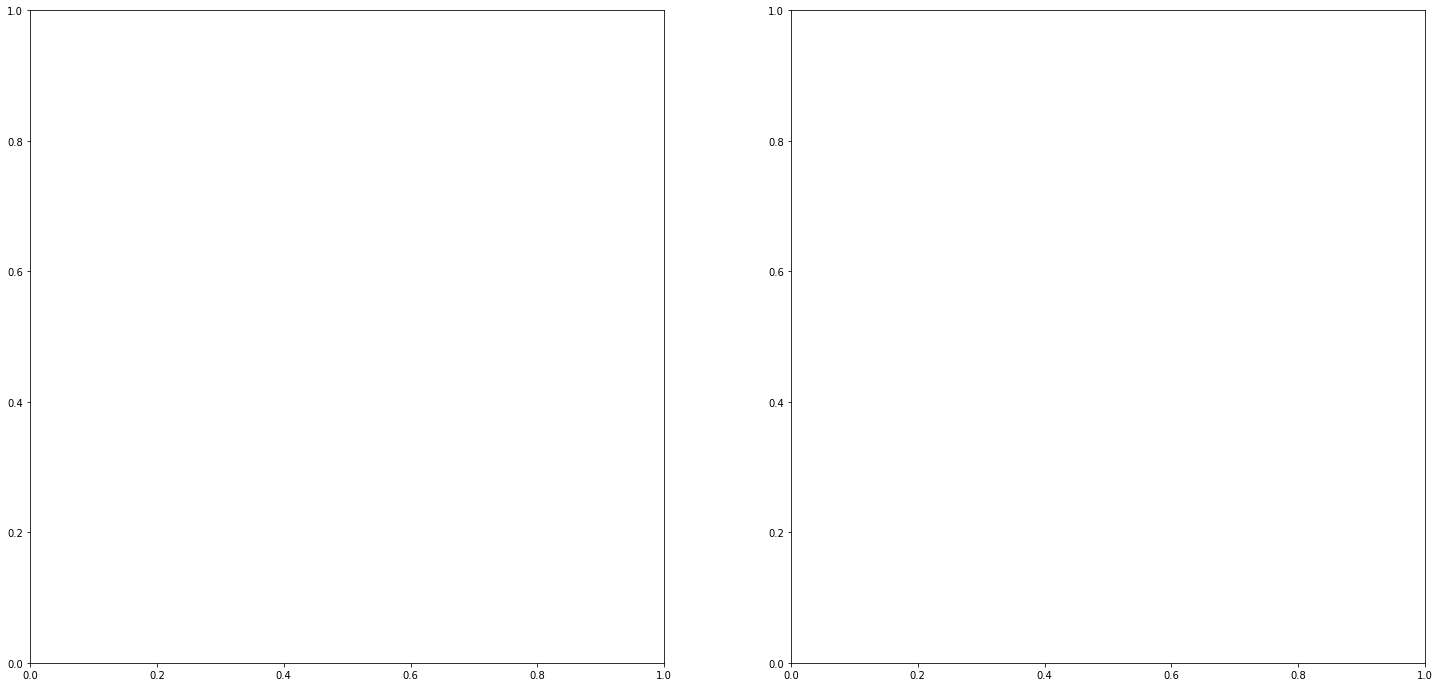

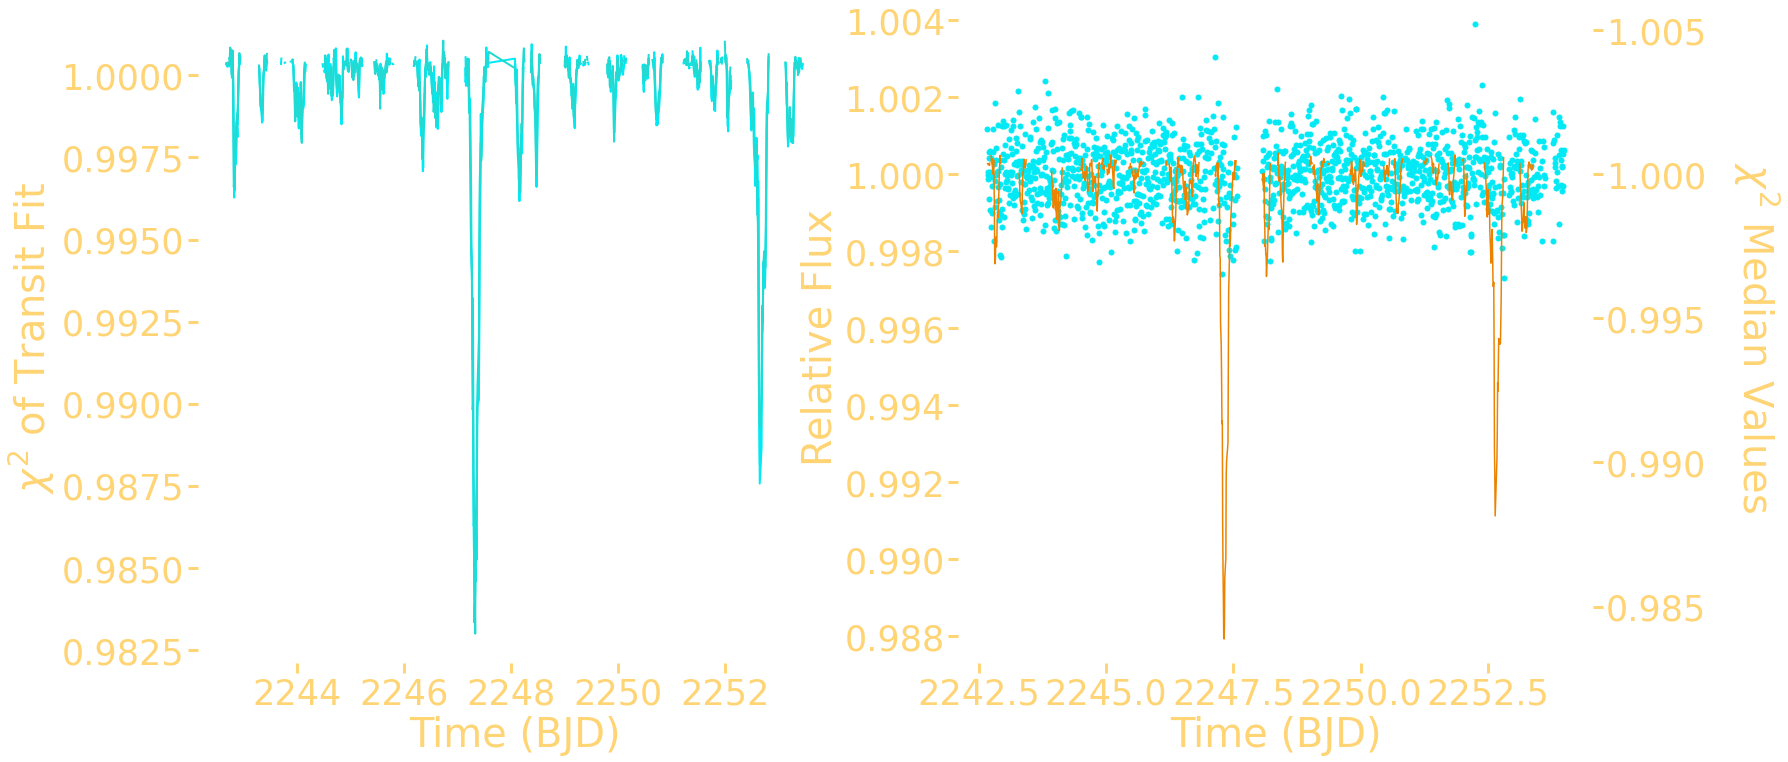

[1558.552902409362332, 1570.969544944796553, 2046.8785856353672443, 2047.8855233357621728, 2057.8160425812352514, 2247.7608987020626046]
periodic singles 0
sort_index [0 1 2 3 4 5]
checking singles T0
t0:  1558.552902409362332 , tdur:  4.0  hours
lenghs 1 38084 38084
t0:  1570.969544944796553 , tdur:  5.5  hours
lenghs 1 38084 38084
t0:  2046.8785856353672443 , tdur:  11.0  hours
lenghs 1 38084 38084
t0:  2047.8855233357621728 , tdur:  10.0  hours
lenghs 1 38084 38084
t0:  2057.8160425812352514 , tdur:  11.0  hours
lenghs 1 38084 38084
t0:  2247.7608987020626046 , tdur:  10.5  hours
lenghs 1 38084 38084
done  150428135        TICID   planet_name     period           T0       Tdur     depth
0  150428135  150428135.01  16.051384  1340.073911   0.009949  0.997497
1  150428135  150428135.02        NaN  1558.552902   4.000000  0.997591
2  150428135  150428135.03        NaN  1570.969545   5.500000  0.998883
3  150428135  150428135.04        NaN  2046.878586  11.000000  0.997337
4  150428135 

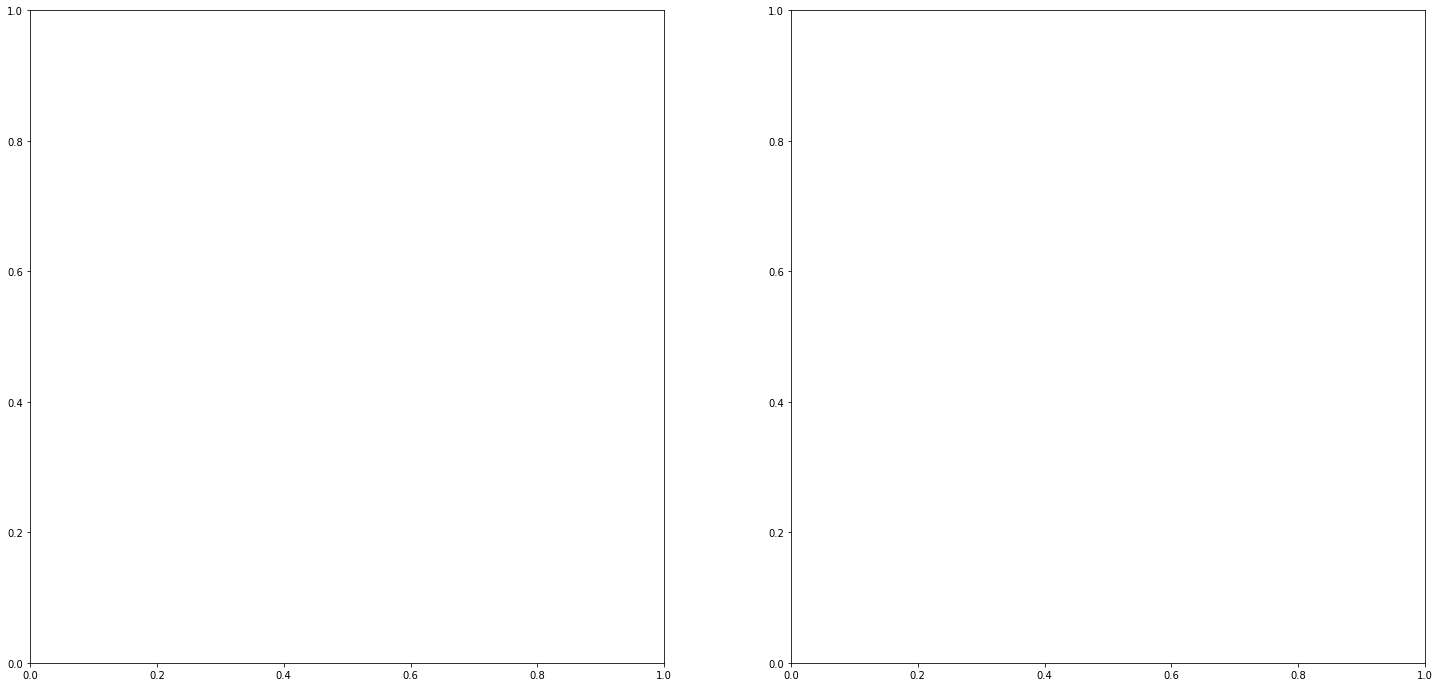

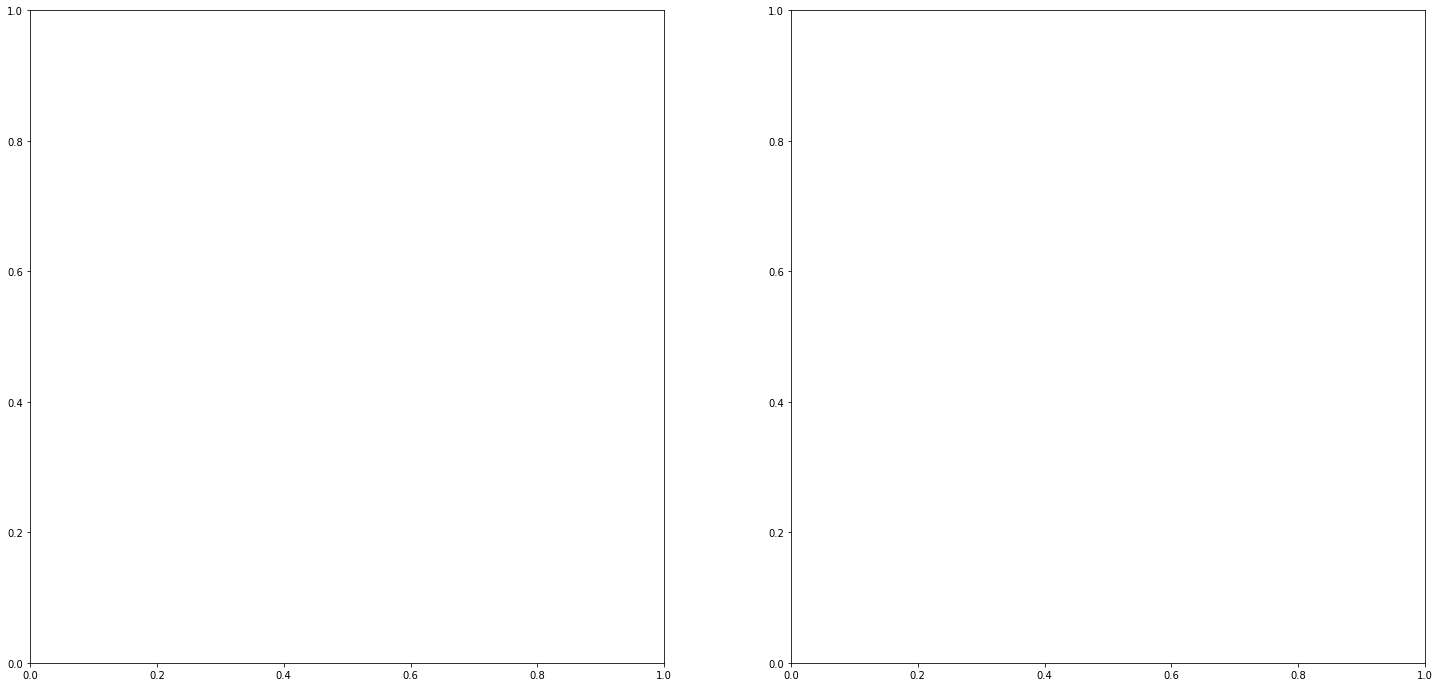

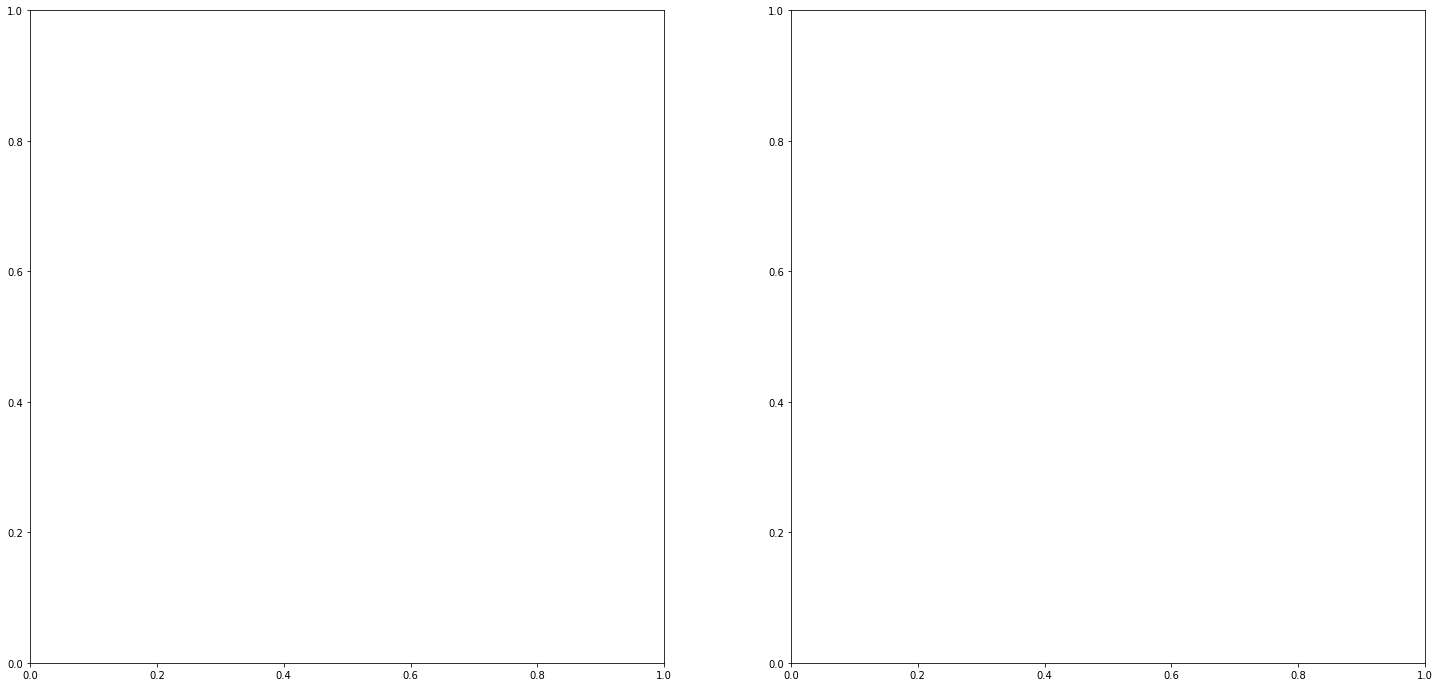

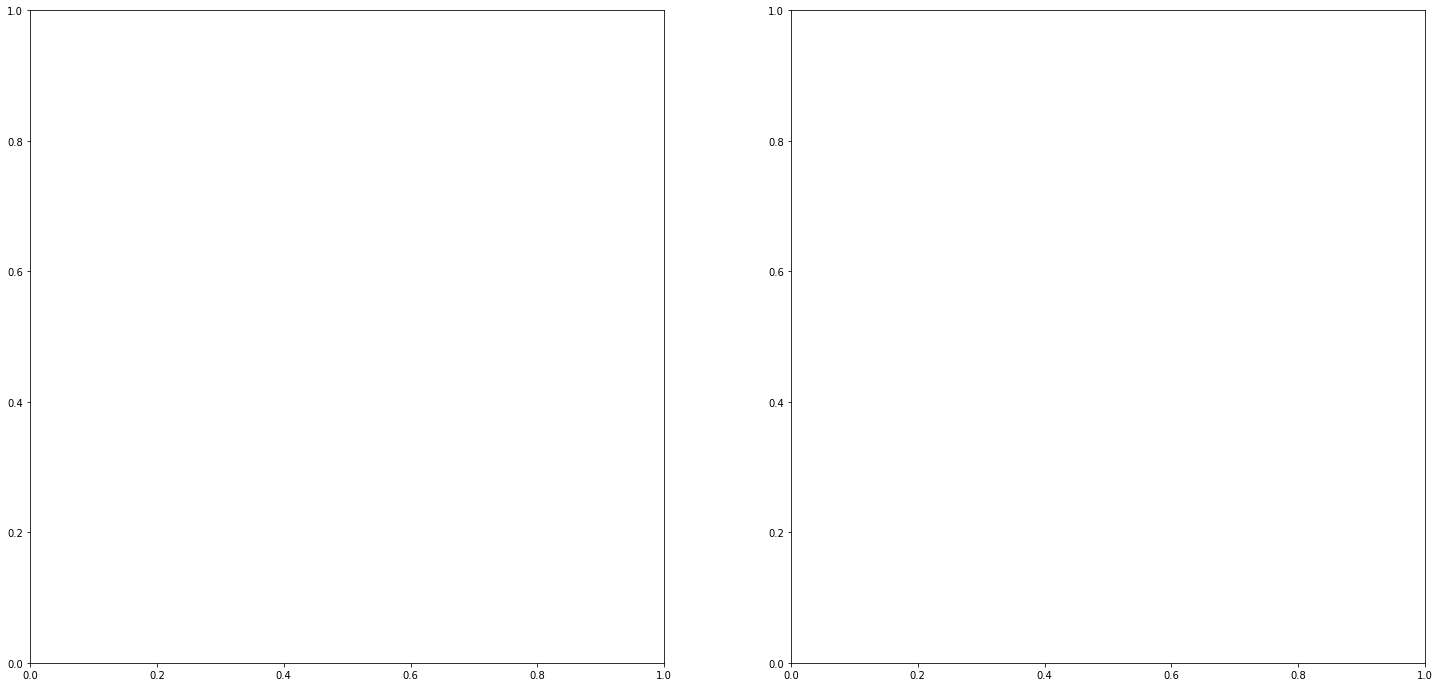

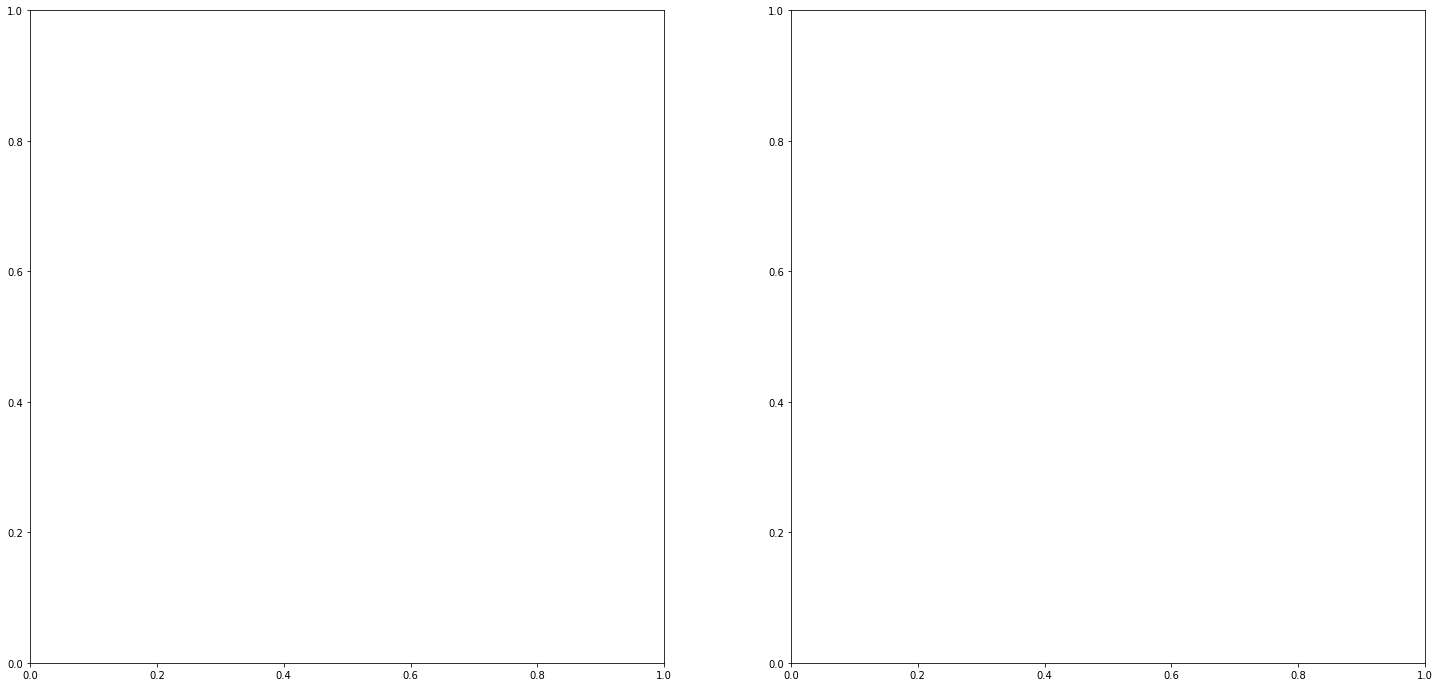

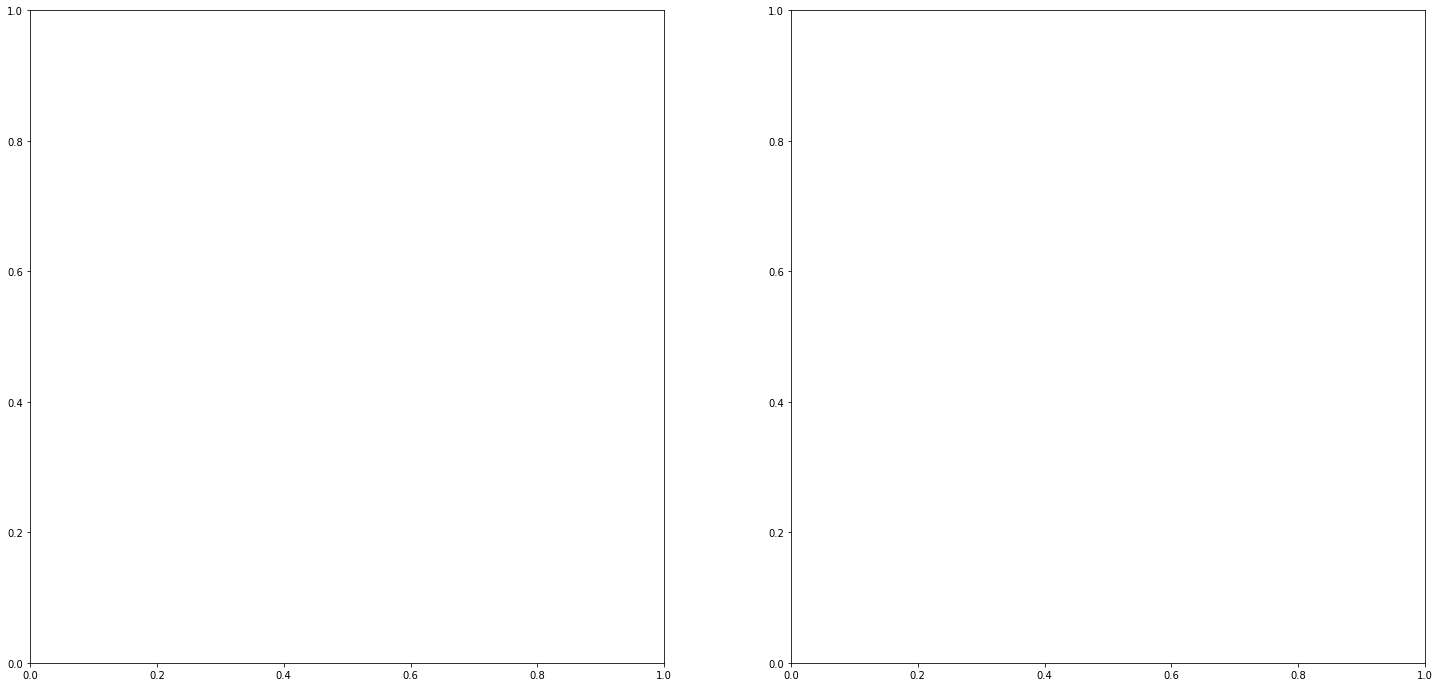

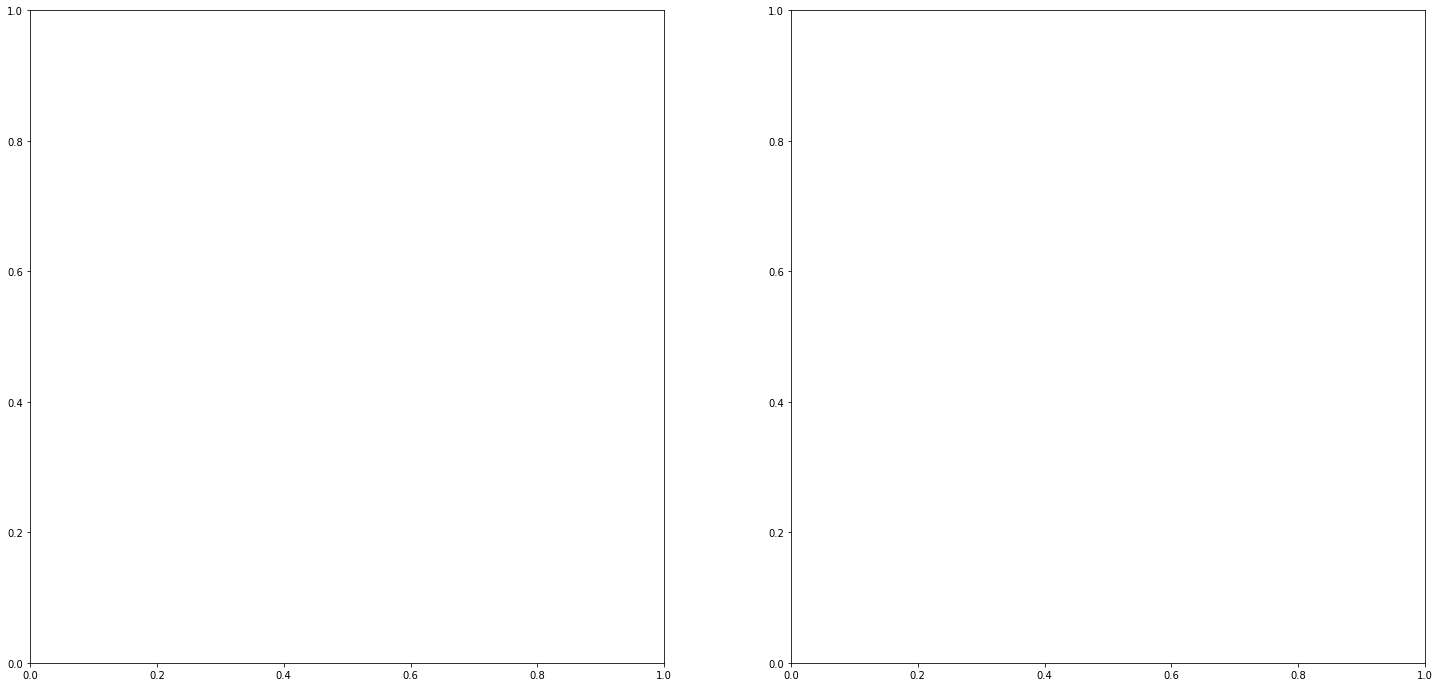

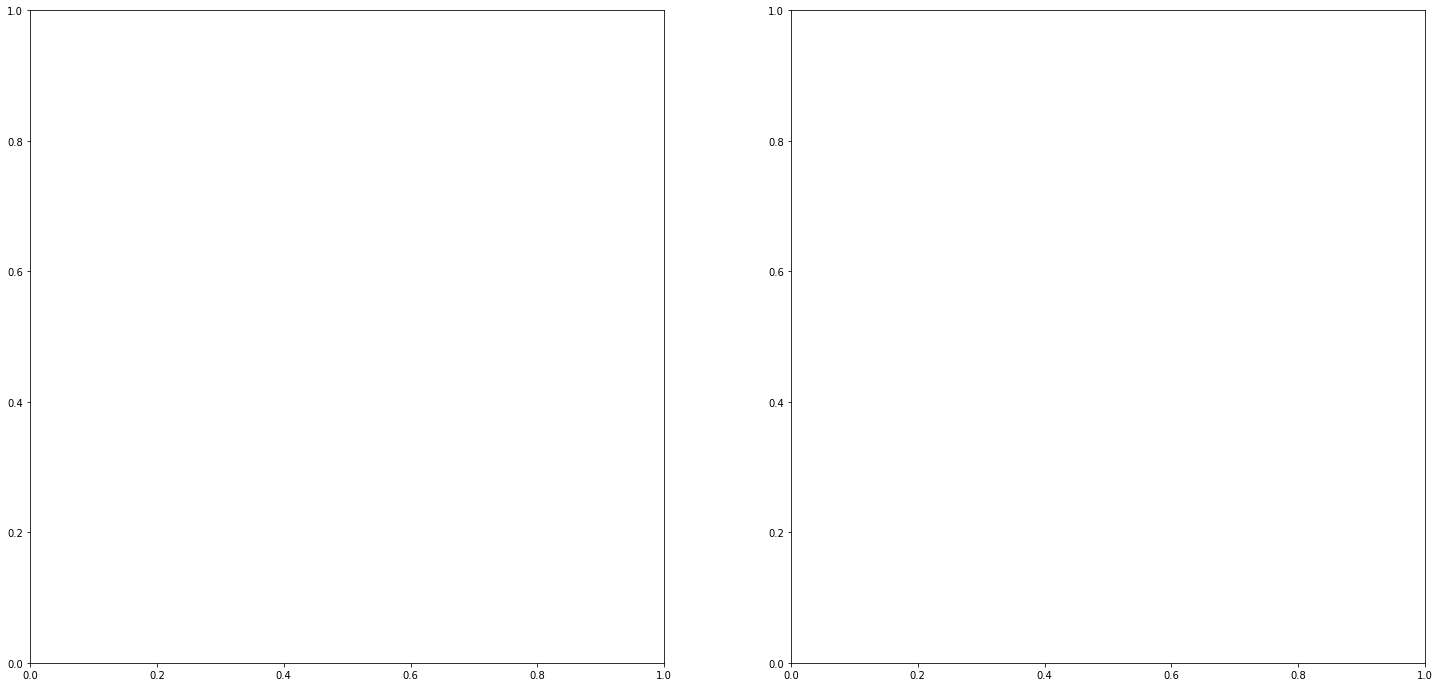

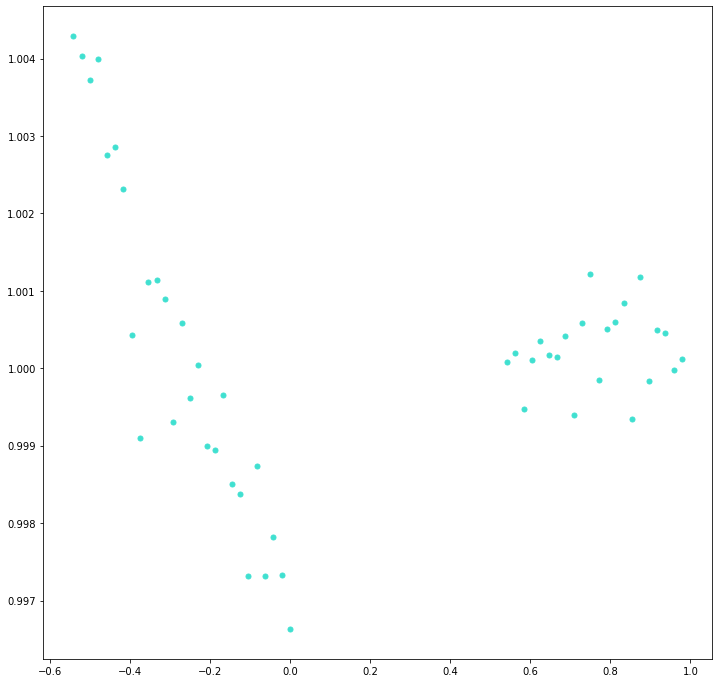

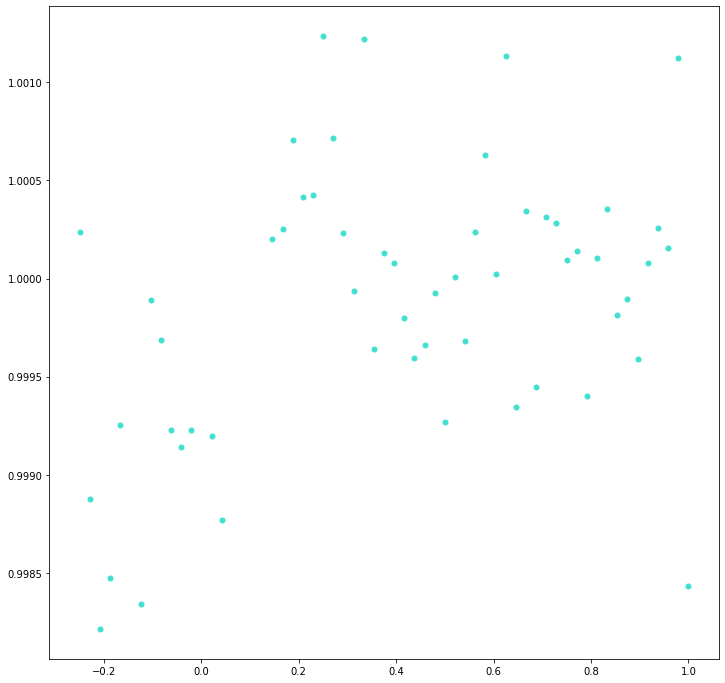

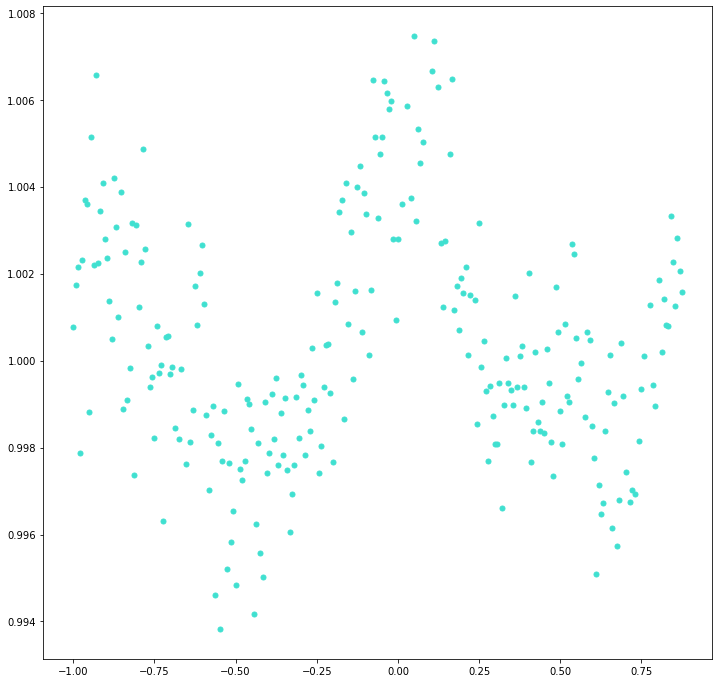

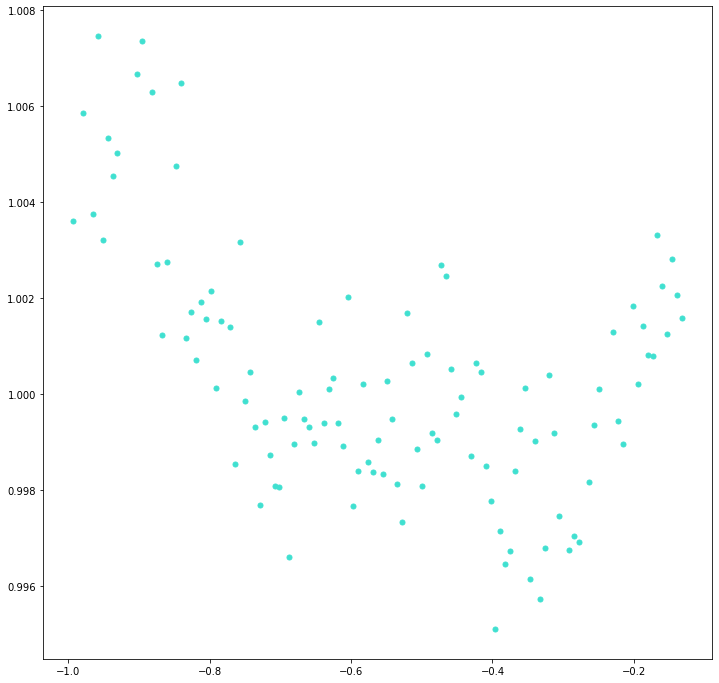

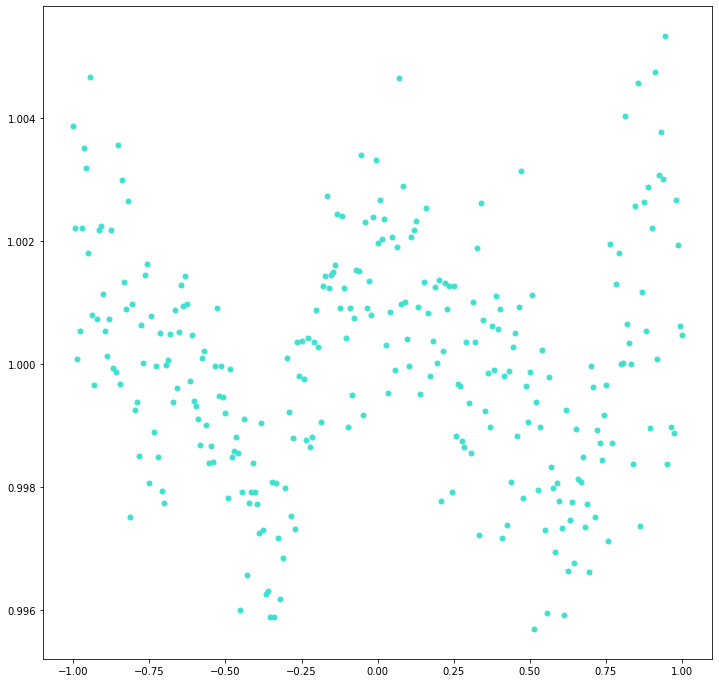

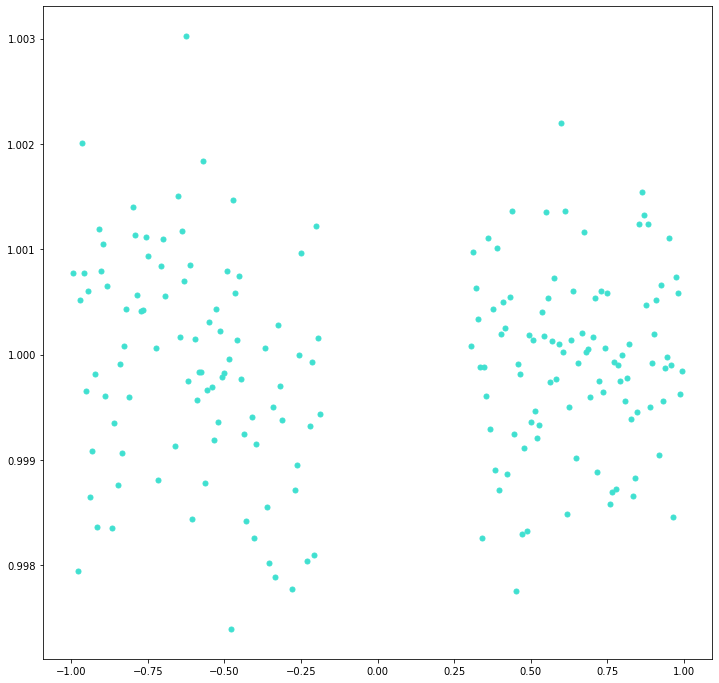

In [91]:
column_names = ['TICID', 'planet_name', 'period', 'T0', 'Tdur', 'depth']
start = time.time()

# final_file = './search_mdwarf_planets.csv'
new_planet_df = pd.DataFrame(columns=column_names)
print(new_planet_df)


for iii in ticids_mdwarfs:
    
    print(iii)
    fits_files = sorted(glob.glob('./known_Mdwarfs_data/FFI_data/all_target_data/tic_'+str(iii)+'_all/*/*/*/*.fits'))

#     fits_files = sorted(glob.glob('./known_Mdwarfs_data/FFI_data/*/*/*/*'+str(iii)+'*/*.fits'))
    if len(fits_files)>0:
    # print(tess_spoc_fits)
        print('num files', len(fits_files))
    #     fits_files
        ab, smass, smass_min, smass_max, sradius, sradius_min, sradius_max = get_catalog_info(iii, mdwarfs_known)
    #     print(ab)
        T0_all, Tdur_all, depth_all, periods_all = running_overall_TLS_code(fits_files, ab, smass, sradius, verbose = True)
        nnn = 0
        for jjj in range(len(T0_all)):
            nnn+=1
            planet_name = str(float(iii)+nnn/100)
            new_planet_df.loc[len(new_planet_df.index)] = [int(iii), planet_name, periods_all[jjj], T0_all[jjj], Tdur_all[jjj],depth_all[jjj]]
#             new_planet_df.to_csv(final_file, index = False, header = False, mode="a",)
        T0_all, Tdur_all, depth_all, periods_all = [], [], [], []
        print('done ', iii, new_planet_df)
        break
final_end = time.time()
print('done, time since start: ', (final_end-start)/60, 'minutes')

In [92]:
new_planet_df

,TICID,planet_name,period,T0,Tdur,depth
0,150428135,150428135.01,16.051384,1340.073911,0.009949,0.997497
1,150428135,150428135.02,NaN,1558.552902,4.000000,0.997591
2,150428135,150428135.03,NaN,1570.969545,5.500000,0.998883
3,150428135,150428135.04,NaN,2046.878586,11.000000,0.997337
4,150428135,150428135.05,NaN,2047.885523,10.000000,0.997427
5,150428135,150428135.06,NaN,2057.816043,11.000000,0.997033
6,150428135,150428135.07,NaN,2247.760899,10.500000,0.999005
